In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np

data = pd.read_excel('/Users/maxxtucker/Desktop/animated bubble chart/Formatted_Data.xlsx')
data.head()

Company     Year  Revenue Growth (%)  EBITDA Margin (%)  Revenue
0    ABNB  Q1'1997                 NaN                NaN      NaN
1    ABNB  Q2'1997                 NaN                NaN      NaN
2    ABNB  Q3'1997                 NaN                NaN      NaN
3    ABNB  Q4'1997                 NaN                NaN      NaN
4    ABNB  Q1'1998                 NaN                NaN      NaN

In [2]:
def convert_year(year_str):
    # Check if the year format includes a quarter
    if "Q" in year_str:
        # Extract the year and the quarter
        year_part = int(year_str.split("'")[1])  # Split on the apostrophe and convert to integer
        quarter_part = int(year_str[1])  # Assuming the format is 'QX'YYYY'
        return year_part + (quarter_part - 1) / 4  # Convert quarter to a fraction of the year
    else:
        # Assume the input is a standard year
        return int(year_str)
    
data['Numeric_Year'] = data['Year'].apply(convert_year)
print(data)

     Company     Year  Revenue Growth (%)  EBITDA Margin (%)  Revenue  \
0       ABNB  Q1'1997                 NaN                NaN      NaN   
1       ABNB  Q2'1997                 NaN                NaN      NaN   
2       ABNB  Q3'1997                 NaN                NaN      NaN   
3       ABNB  Q4'1997                 NaN                NaN      NaN   
4       ABNB  Q1'1998                 NaN                NaN      NaN   
...      ...      ...                 ...                ...      ...   
2745    TRIP  Q2'2023                 NaN                NaN      NaN   
2746    TRIP  Q3'2023                 NaN                NaN      NaN   
2747    TRIP  Q4'2023                 NaN                NaN      NaN   
2748    TRIP  Q1'2024                 NaN                NaN      NaN   
2749    TRIP  Q2'2024                 NaN                NaN      NaN   

      Numeric_Year  
0          1997.00  
1          1997.25  
2          1997.50  
3          1997.75  
4          1998.00

In [3]:
import numpy as np
import pandas as pd

# Assuming 'data' is already loaded and includes the 'Numeric_Year' transformation

interp_data = pd.DataFrame()

multiple = 30
for company in data['Company'].unique():
    temp_df = pd.DataFrame()
    company_df = data[data['Company'] == company]

    if len(company_df) < 2:
        print(f"Not enough data to interpolate for {company}")
        continue

    # Calculate the number of interpolation points
    num_points = len(company_df) * multiple - (multiple - 1)
    years = np.linspace(company_df['Numeric_Year'].min(), company_df['Numeric_Year'].max(), num_points)

    # Initialize the temporary DataFrame
    temp_df = pd.DataFrame({
        'Numeric_Year': years,
        'Revenue': np.nan,
        'EBITDA Margin (%)': np.nan,
        'Revenue Growth (%)': np.nan,
        'Company': company
    })

    # Handle each field separately
    for field in ['Revenue', 'EBITDA Margin (%)', 'Revenue Growth (%)']:
        field_values = company_df.dropna(subset=[field])  # Drop rows where the field is NaN
        if len(field_values) > 1:
            valid_years = field_values['Numeric_Year']
            valid_values = field_values[field]
            interp_values = np.interp(years, valid_years, valid_values)

            # Create indices for placing interpolated values but only within the bounds of the first and last non-NaN data
            first_valid_index = valid_years.min()
            last_valid_index = valid_years.max()
            
            # Apply interpolation only between the first and last actual data points
            bounded_indices = (temp_df['Numeric_Year'] >= first_valid_index) & (temp_df['Numeric_Year'] <= last_valid_index)
            temp_df.loc[bounded_indices, field] = interp_values[bounded_indices]

    # Concatenate the interpolated data to the main DataFrame
    interp_data = pd.concat([interp_data, temp_df], ignore_index=True)

# Print the head of the dataframe to check the interpolation results
print(interp_data.head())




   Numeric_Year  Revenue  EBITDA Margin (%)  Revenue Growth (%) Company
0   1997.000000      NaN                NaN                 NaN    ABNB
1   1997.008333      NaN                NaN                 NaN    ABNB
2   1997.016667      NaN                NaN                 NaN    ABNB
3   1997.025000      NaN                NaN                 NaN    ABNB
4   1997.033333      NaN                NaN                 NaN    ABNB


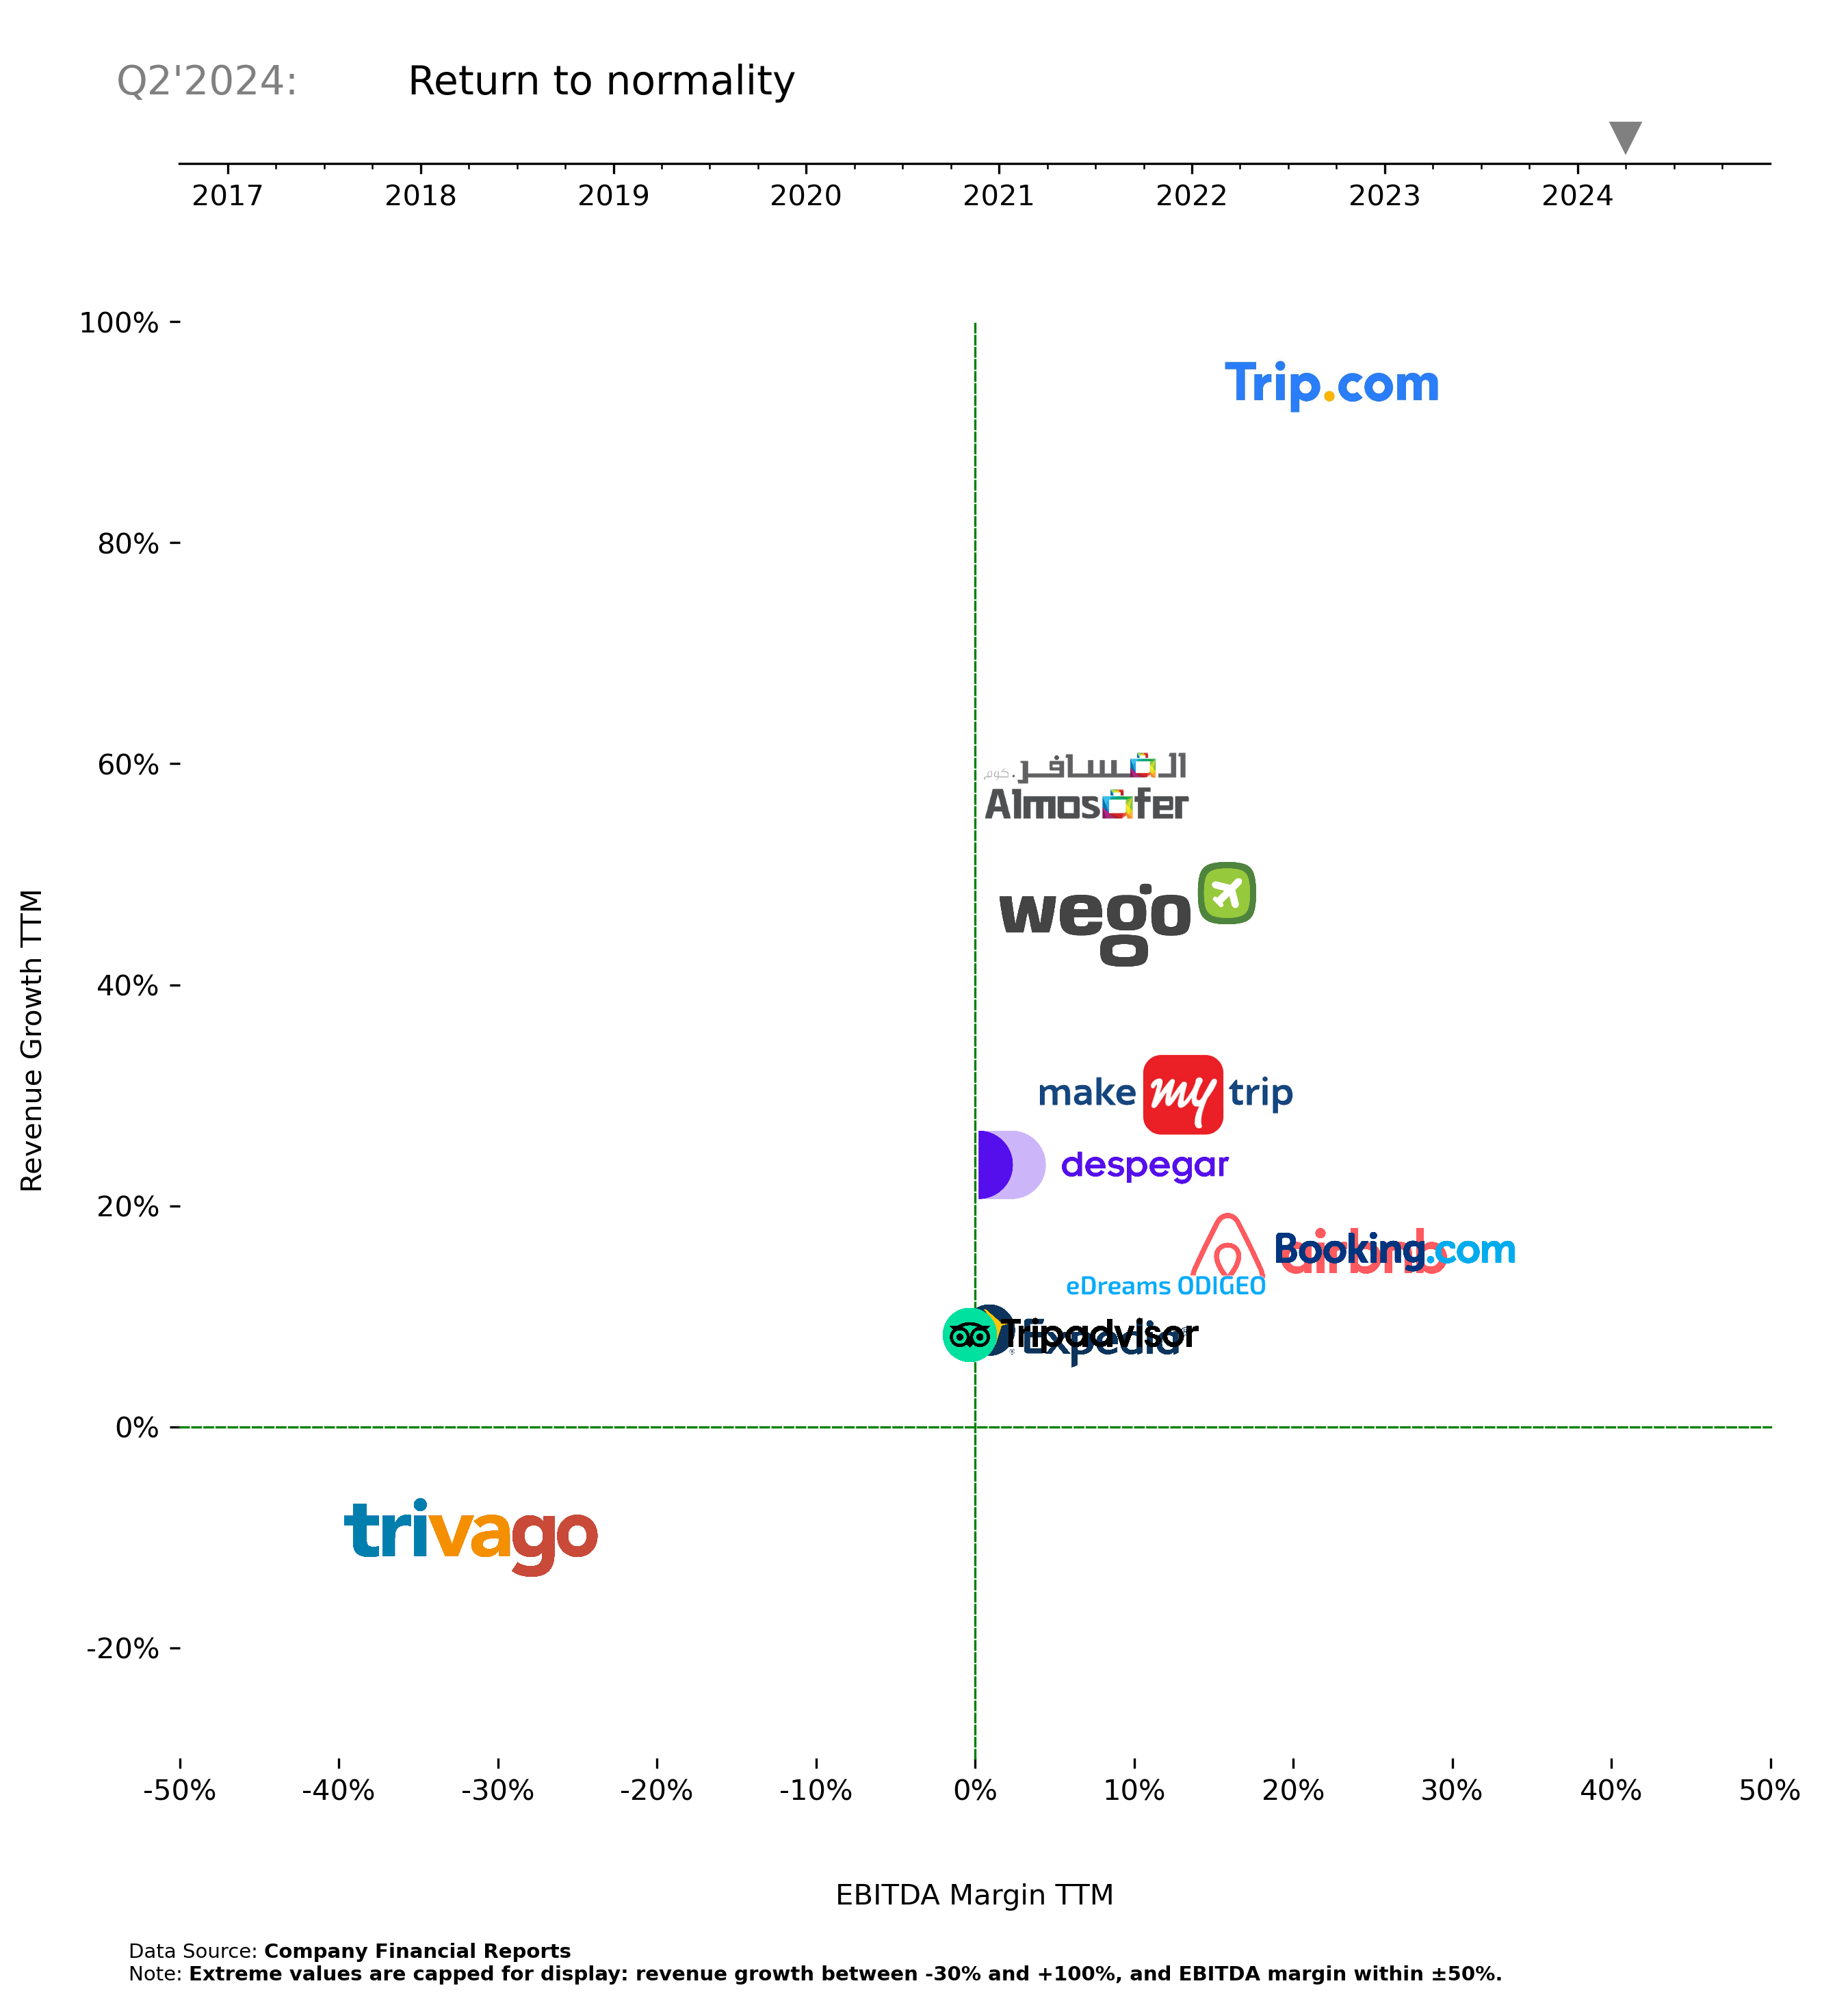

In [87]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import ax_text, fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

# Setup the figure and axis
fig, (ax_timeline, ax) = plt.subplots(2,1,figsize=(10, 11), dpi=300, gridspec_kw={'height_ratios': [1, 10]})


# Assuming interp_data is already defined and contains the necessary data
# Prepare the color mapping and load logos
unique_companies = interp_data['Company'].unique()
colors = plt.cm.get_cmap('Accent', len(unique_companies))
color_dict = {company: colors(i) for i, company in enumerate(unique_companies)}
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.01

def percent_formatter(x, pos):
    """Convert number to percentage string."""
    return f"{x:.0f}%"  # Change .0f to control the number of decimal places

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Calculate the number of data units per inch
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    fig_width = fig.get_size_inches()[0]
    scale = data_width / (fig_width * fig.dpi)
    # Calculate zoom factor to achieve the desired width in inches
    native_width_in_pixels = image.shape[1]
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    return zoom_factor

def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    
    # Set symmetric axes limits around zero
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)
    
    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    ax_timeline.set_xlim(2016.75, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(plt.MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(2017, 2025, 1))
    ax_timeline.set_xticks(np.arange(2017, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    
    # Moving marker on timeline
    ax_timeline.plot([frame], [0.15], marker='v', color='grey', markersize=10)

    # Scatter plot for that year
    sc = ax.scatter(
        x=yearly_data['EBITDA Margin (%)'],
        y=yearly_data['Revenue Growth (%)'],
        c=yearly_data['color'],  # Use the mapped colors
        s=100,  # Constant size for bubbles
        cmap="Accent", 
        alpha=0, 
        edgecolors="white", 
        linewidths=2
    )

    # Replace text with logo images
    for i, point in yearly_data.iterrows():
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)']), frameon=False)
        ax.add_artist(ab)

    


    ## Adjust spines to put zero in the middle
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

    # Configure secondary axes and hide spines
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.spines['top'].set_visible(False)
    ax2_x.spines['bottom'].set_visible(False)
    ax2_y.spines['left'].set_visible(False)
    ax2_y.spines['right'].set_visible(False)

    # Define a custom formatter function
    def percentage_formatter(x, pos):
        return f'{x:.0f}%'

    # Create a FuncFormatter object
    formatter = FuncFormatter(percentage_formatter)

    # Apply the formatter to secondary x-axis
    ax2_x.xaxis.set_major_formatter(formatter)

    # Apply the formatter to secondary y-axis
    ax2_y.yaxis.set_major_formatter(formatter)
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))  

    # Optionally, hide ticks on the axes crossing at zero
    ax.set_xlabel("EBITDA Margin TTM", horizontalalignment='center', x=0.5, labelpad=160)
    ax.set_ylabel("Revenue Growth TTM", verticalalignment='center', y=0.5, labelpad=330)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        # Assuming time_value is a floating point year with fractional part representing the quarter
        year = int(time_value)
        # Calculate which quarter
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text
    text = "Data Source: <Company Financial Reports>"
    fig_text(0.1, 0.02, text, ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    text_2 = "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>"
    fig_text(0.1, 0.01, text_2, ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    

    # Time display
    quarter_year = get_quarter_year(frame)
    ax.annotate(f"{quarter_year}:", xy=(-0.04, 1.18), xycoords='axes fraction',
            color="grey", ha='left', fontsize=14, va='top', backgroundcolor='white', transform=ax.transAxes, clip_on=False)

    # Annotation for specific timeframe

    if 2017 <= frame <= 2017.999:
    # Annotate with a note about the economy and travel market, continuing from the previous text
        ax.annotate('Good economy worldwide, growing travel market', xy=(-0.04, 1.18), xycoords='axes fraction',
                fontsize=14, color='black', ha='left', va='top', backgroundcolor='white', transform=ax.transAxes,
                xytext=(80, 0), textcoords='offset points', clip_on=False)  # Offset moves the start right from the initial text


    if 2018 <= frame <= 2018.999:
    # Annotate with a note about the economy and travel market, continuing from the previous text
        ax.annotate('Trivago stumbles after dispute with Booking. Cut-throat competition in India', xy=(-0.04, 1.18), xycoords='axes fraction',
                fontsize=14, color='black', ha='left', va='top', backgroundcolor='white', transform=ax.transAxes,
                xytext=(80, 0), textcoords='offset points')  # Offset moves the start right from the initial text
        
    if 2019 <= frame <= 2019.999:
    # Annotate with a note about the economy and travel market, continuing from the previous text
        ax.annotate('High growth in China / Trip.com', xy=(-0.04, 1.18), xycoords='axes fraction',
                fontsize=14, color='black', ha='left', va='top', backgroundcolor='white', transform=ax.transAxes,
                xytext=(80, 0), textcoords='offset points')  # Offset moves the start right from the initial text
        
    if 2020 <= frame <= 2021.2:
    # Annotate with a note about the economy and travel market, continuing from the previous text
        ax.annotate('Covid-19 pandemic decimates the travel industry', xy=(-0.04, 1.18), xycoords='axes fraction',
                fontsize=14, color='black', ha='left', va='top', backgroundcolor='white', transform=ax.transAxes,
                xytext=(80, 0), textcoords='offset points')  # Offset moves the start right from the initial text       

  
    if 2021.201 <= frame <= 2022.8:
    # Annotate with a note about the economy and travel market, continuing from the previous text
        ax.annotate('Post-pandemic rebound', xy=(-0.04, 1.18), xycoords='axes fraction',
                fontsize=14, color='black', ha='left', va='top', backgroundcolor='white', transform=ax.transAxes,
                xytext=(80, 0), textcoords='offset points')  # Offset moves the start right from the initial text 


    if 2022.801 <= frame <= 2023.999:
    # Annotate with a note about the economy and travel market, continuing from the previous text
        ax.annotate('China reopens boosting Trip.com', xy=(-0.04, 1.18), xycoords='axes fraction',
                fontsize=14, color='black', ha='left', va='top', backgroundcolor='white', transform=ax.transAxes,
                xytext=(80, 0), textcoords='offset points')  # Offset moves the start right from the initial text 
    
        

    if 2024 <= frame <= 2024.5:
    # Annotate with a note about the economy and travel market, continuing from the previous text
        ax.annotate('Return to normality', xy=(0, 1.18), xycoords='axes fraction',
                fontsize=14, color='black', ha='left', va='top', backgroundcolor='white', transform=ax.transAxes,
                xytext=(80, 0), textcoords='offset points')  # Offset moves the start right from the initial text 
          
    

    
    
    return sc, ax_timeline

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)


plt.show()


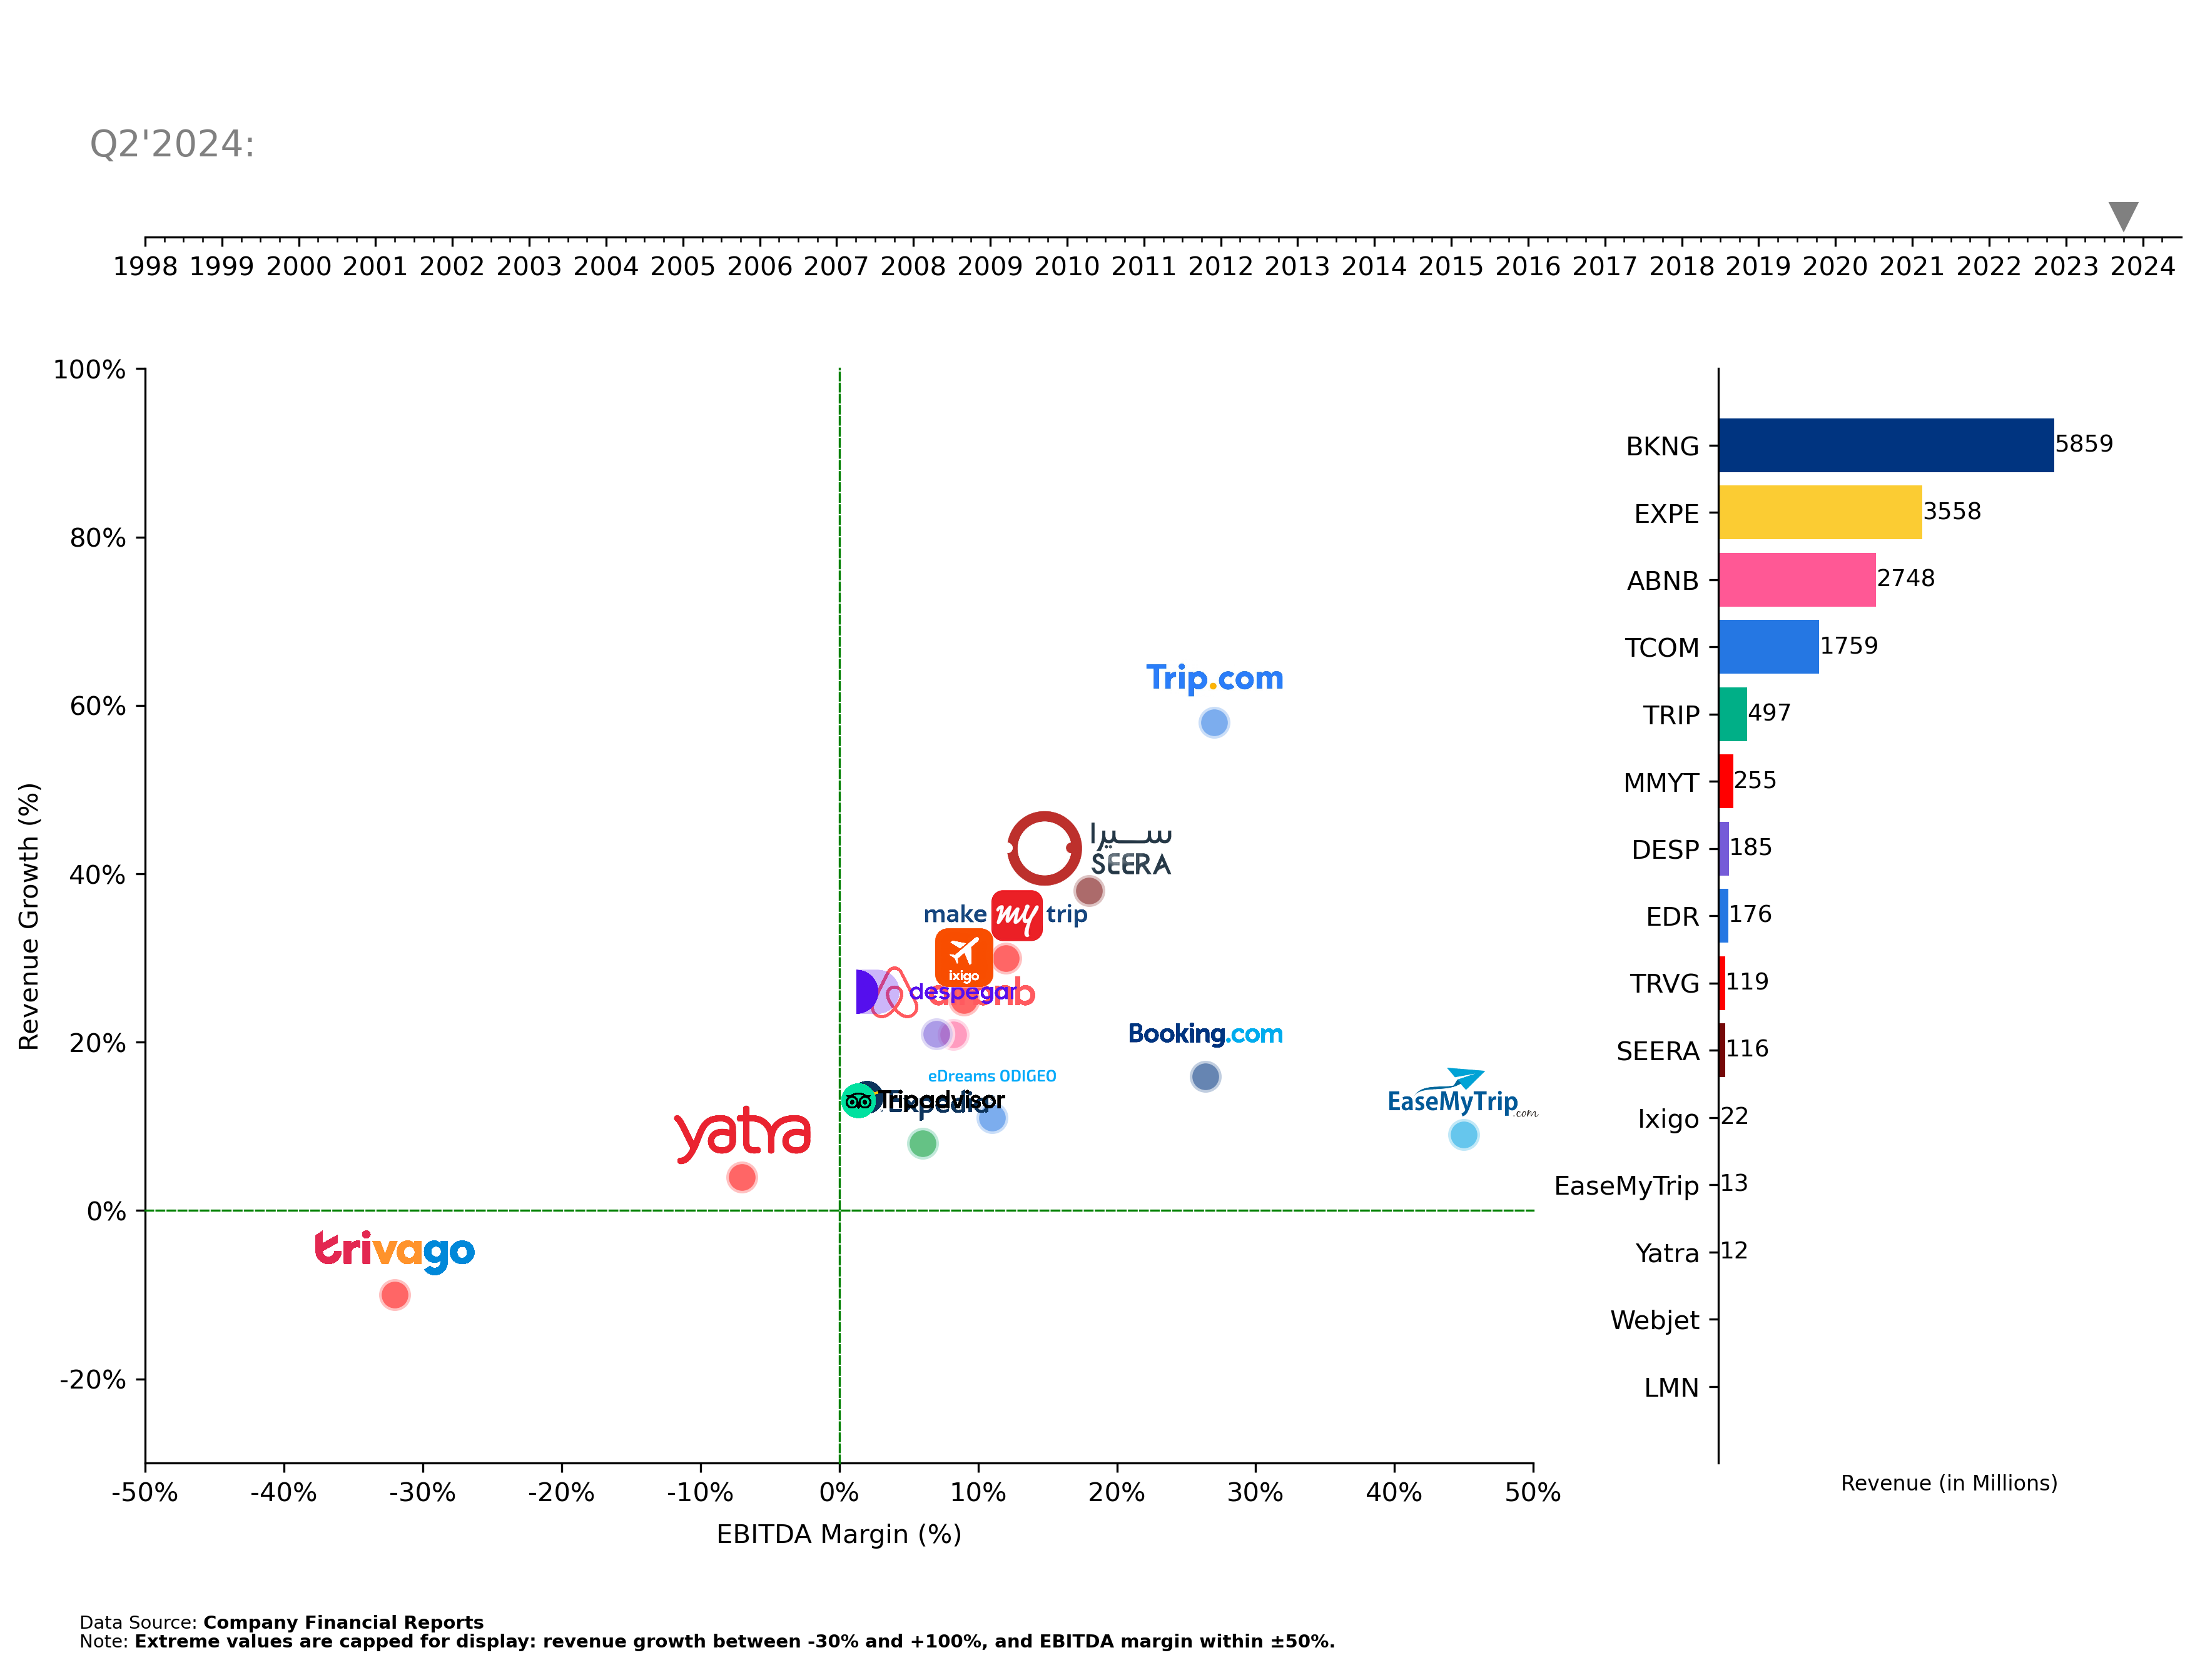

In [76]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EaseMyTrip': '#00a0e2',
    'Ixigo': 'red',  # 'red' is already a valid color name in matplotlib
    'MMYT': 'red',  # 'red' is valid
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'Yatra': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    fig_width = fig.get_size_inches()[0]
    scale = data_width / (fig_width * fig.dpi)
    native_width_in_pixels = image.shape[1]
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    return zoom_factor

def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    
    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1998.75, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1998.5, 2025, 1))
    ax_timeline.set_xticks(np.arange(1998.5, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    ax_timeline.plot([frame], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Plot the colored dot for each company using the color from the color_dict
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=150,  # Size of the colored dot
            alpha=0.6,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        
        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax.set_xlabel("EBITDA Margin (%)", horizontalalignment='center', x=0.5, labelpad=120)
    ax.set_ylabel("Revenue Growth (%)", verticalalignment='center', y=0.5, labelpad=310)

    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
             highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
             ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)
    
    # Adjust comment to be higher to avoid overlap with the timeline
    ax.annotate(f"{quarter_year}:", xy=(-0.04, 1.22), xycoords='axes fraction', color="grey", ha='left', fontsize=14, 
                va='top', backgroundcolor='white', transform=ax.transAxes, clip_on=False)

    # Bar chart race: Filter and sort data by revenue, including all companies to ensure consistent bar width
    # Filter companies with non-zero revenue
    filtered_data = yearly_data[yearly_data['Revenue'] > 0]
    
    # Sort filtered data by revenue
    sorted_data = filtered_data.set_index('Company').reindex(all_companies).fillna(0).sort_values(by='Revenue', ascending=True)

    # Use the color_dict to map company names to colors
    bar_colors = sorted_data.index.map(color_dict)

    # Create horizontal bar chart for revenue with custom colors
    bars = ax_barchart.barh(
        sorted_data.index, 
        sorted_data['Revenue'], 
        color=bar_colors  # Apply the custom colors
    )

    # Add revenue labels to the bars in the bar chart
    for bar in bars:
        width = bar.get_width()
        if not np.isnan(width) and width > 0:  # Only add text if width is valid and greater than 0
            ax_barchart.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='left', fontsize=9)
    
    # Set axis limits and labels for the bar chart race (fixed width for absolute size)
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)  # Fixed axis limit based on max revenue in the data

    # Hide axes and ticks for the bar chart except for the left axis (company names)
    # Show the x-axis label but hide the x-axis ticks and tick labels
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)

    # Set the x-axis label (This will be shown)
    ax_barchart.set_xlabel('Revenue (in Millions)', fontsize=8)

    # Hide the x-axis ticks and tick labels
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis tick marks and labels

    return dots_and_logos + [ax_timeline, ax_barchart]

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()


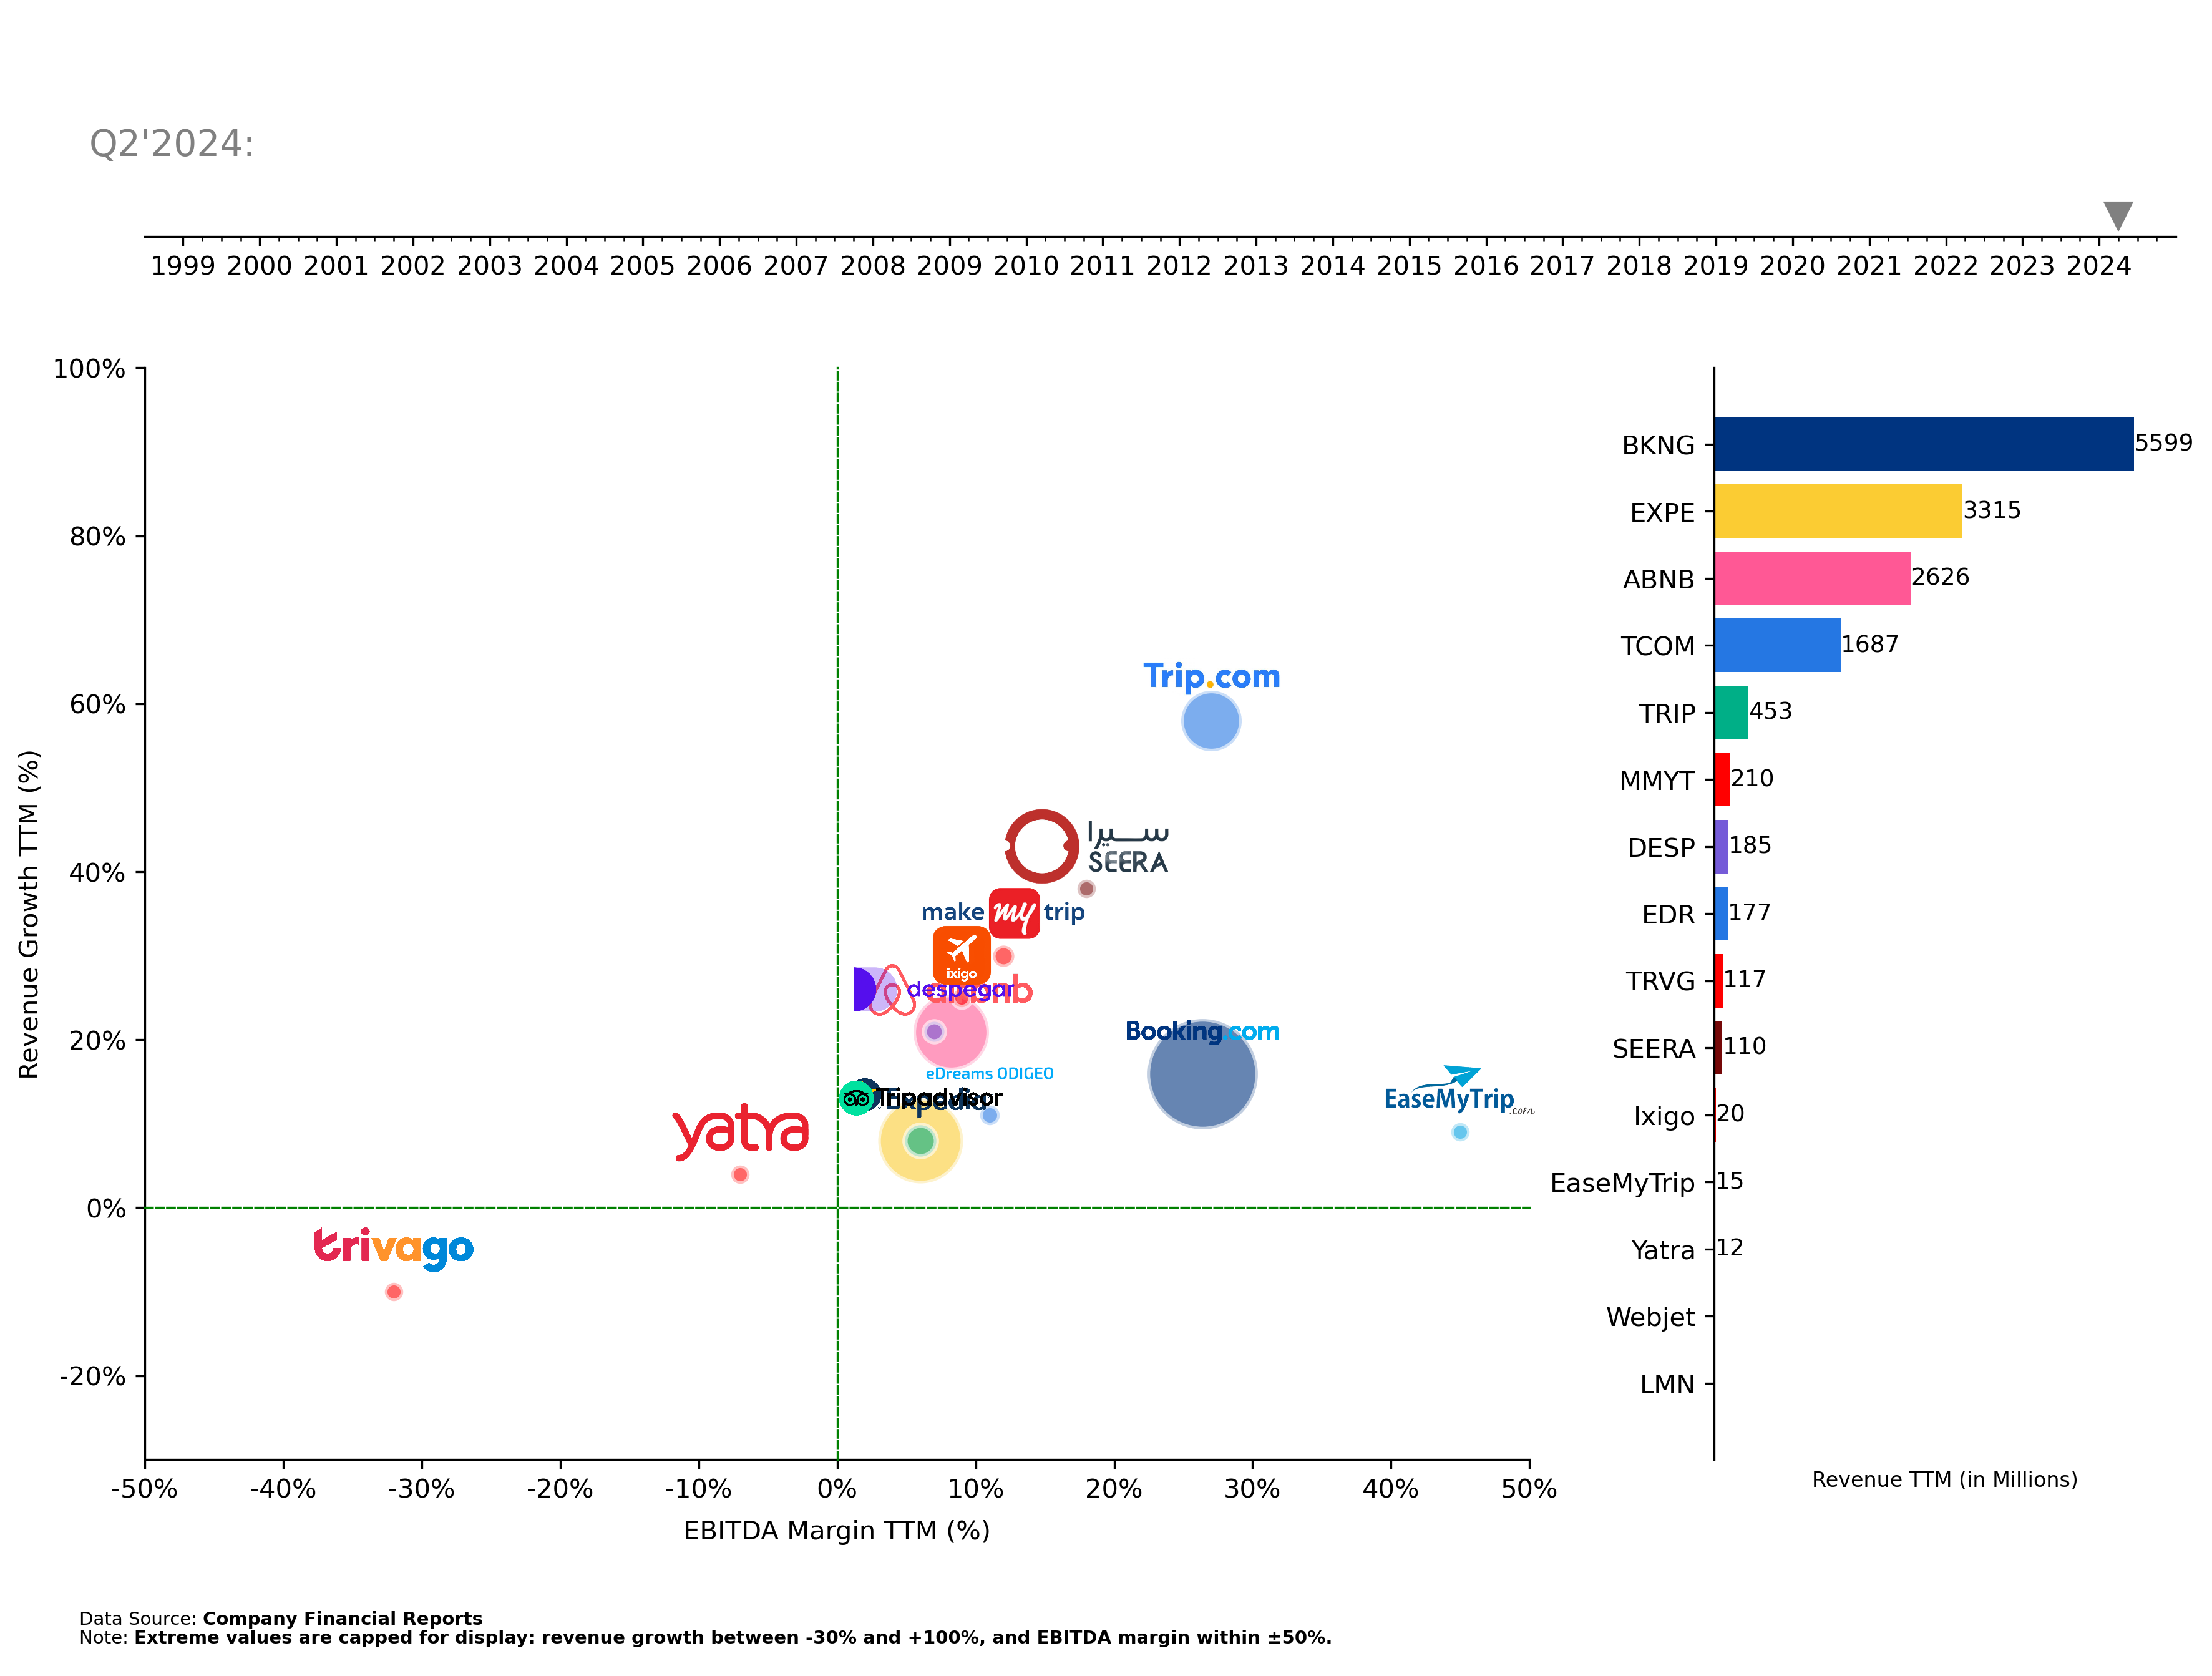

In [32]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EaseMyTrip': '#00a0e2',
    'Ixigo': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'Yatra': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    fig_width = fig.get_size_inches()[0]
    scale = data_width / (fig_width * fig.dpi)
    native_width_in_pixels = image.shape[1]
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    return zoom_factor

def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    
    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1998.5, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue
            # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1800, 50)  # 1500 is the scale, 100 is the minimum size

        
        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.6,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        
        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=120)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=310)

    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
             highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
             ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)
    
    # Adjust comment to be higher to avoid overlap with the timeline
    ax.annotate(f"{quarter_year}:", xy=(-0.04, 1.22), xycoords='axes fraction', color="grey", ha='left', fontsize=14, 
                va='top', backgroundcolor='white', transform=ax.transAxes, clip_on=False)

    # Bar chart race: Filter and sort data by revenue, including all companies to ensure consistent bar width
    # Filter companies with non-zero revenue
    filtered_data = yearly_data[yearly_data['Revenue'] > 0]
    
    # Sort filtered data by revenue
    sorted_data = filtered_data.set_index('Company').reindex(all_companies).fillna(0).sort_values(by='Revenue', ascending=True)

    # Use the color_dict to map company names to colors
    bar_colors = sorted_data.index.map(color_dict)

    # Create horizontal bar chart for revenue with custom colors
    bars = ax_barchart.barh(
        sorted_data.index, 
        sorted_data['Revenue'], 
        color=bar_colors  # Apply the custom colors
    )

    # Add revenue labels to the bars in the bar chart
    for bar in bars:
        width = bar.get_width()
        if not np.isnan(width) and width > 0:  # Only add text if width is valid and greater than 0
            ax_barchart.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='left', fontsize=9)
    
    # Set axis limits and labels for the bar chart race (fixed width for absolute size)
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)  # Fixed axis limit based on max revenue in the data

    # Hide axes and ticks for the bar chart except for the left axis (company names)
    # Show the x-axis label but hide the x-axis ticks and tick labels
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)

    # Set the x-axis label (This will be shown)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8)

    # Hide the x-axis ticks and tick labels
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis tick marks and labels

    return dots_and_logos + [ax_timeline, ax_barchart]

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()


ValueError: Invalid RGBA argument: nan

Error in callback <function _draw_all_if_interactive at 0x10fee40e0> (for post_execute):


ValueError: Invalid RGBA argument: nan

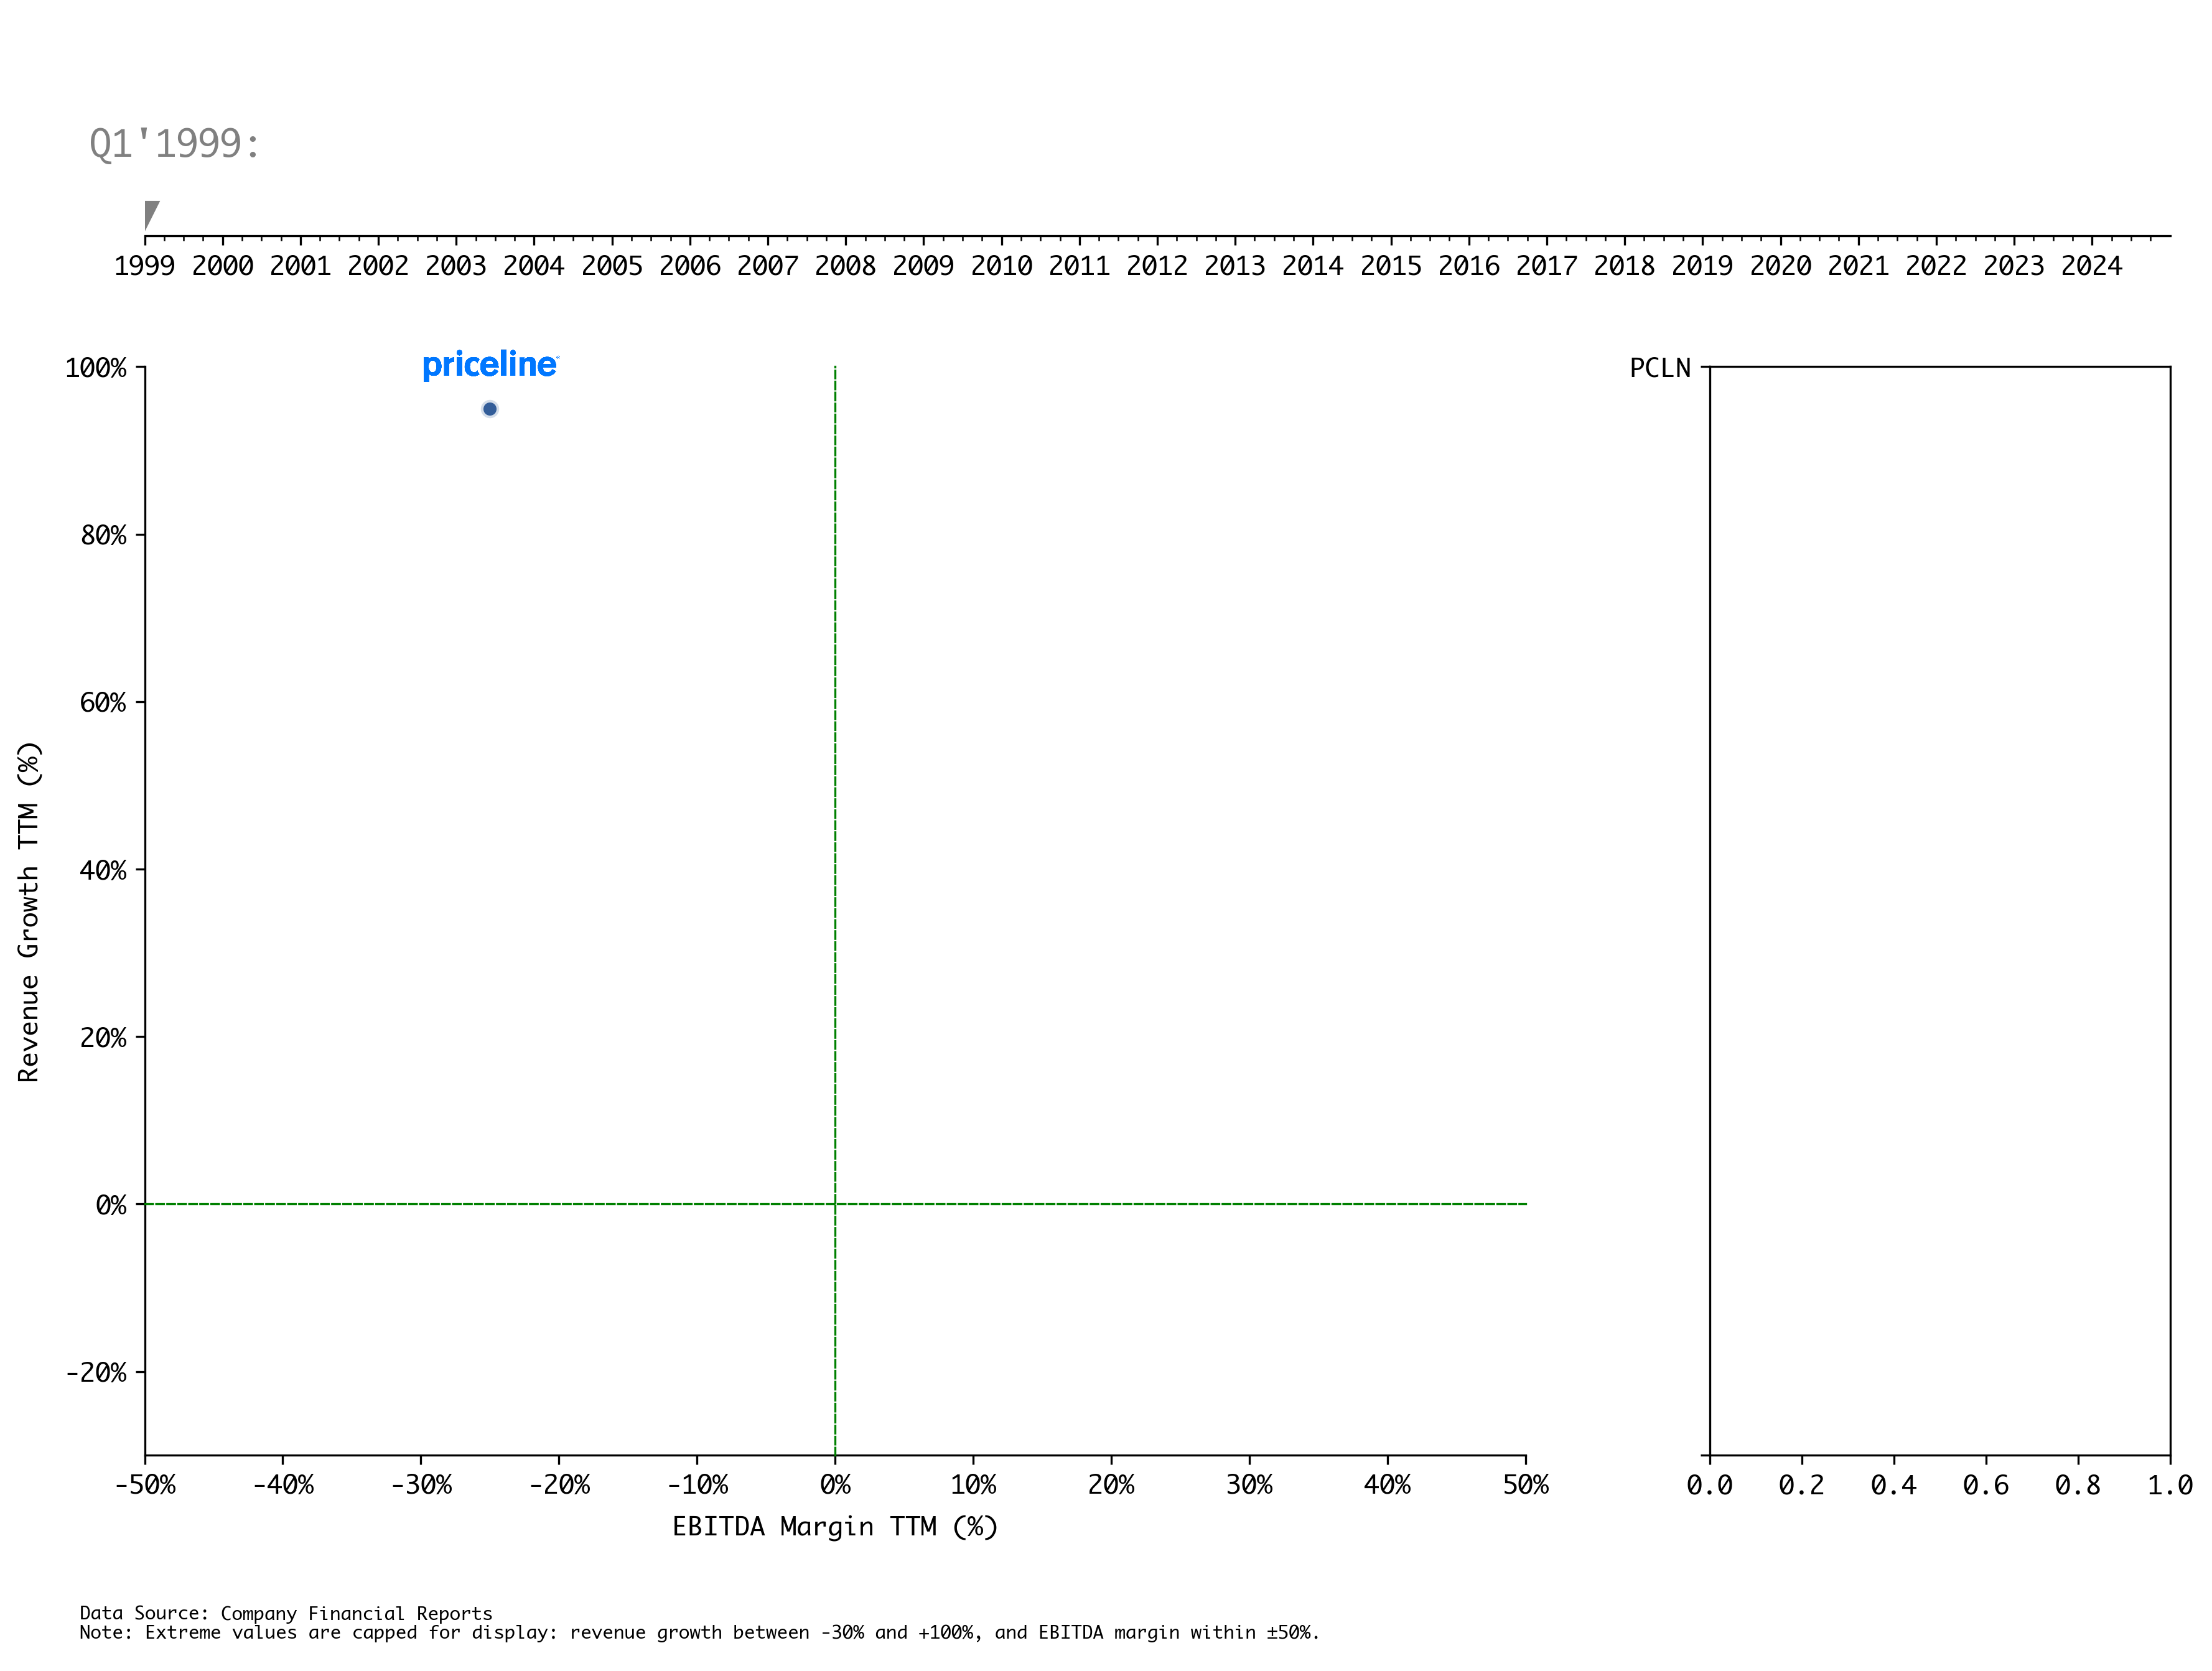

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EaseMyTrip': '#00a0e2',
    'Ixigo': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'Yatra': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480'
}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    fig_width = fig.get_size_inches()[0]
    scale = data_width / (fig_width * fig.dpi)
    native_width_in_pixels = image.shape[1]
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    return zoom_factor

def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    
    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1800, 50)  # 1500 is the scale, 100 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        
        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=120)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=310)

    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
             highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
             ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)
    
    # Adjust comment to be higher to avoid overlap with the timeline
    ax.annotate(f"{quarter_year}:", xy=(-0.04, 1.22), xycoords='axes fraction', color="grey", ha='left', fontsize=14, 
                va='top', backgroundcolor='white', transform=ax.transAxes, clip_on=False)

    # Bar chart race: Filter and sort data by revenue, ensuring constant bar width
    # Filter companies with non-zero revenue
    filtered_data = yearly_data[yearly_data['Revenue'] > 0]
    
    # Sort filtered data by revenue and keep all companies, assigning zero revenue to companies not in the top 12
    sorted_data = filtered_data.set_index('Company').reindex(all_companies).fillna(0).sort_values(by='Revenue', ascending=True)

    # Hide company names with zero revenue by setting their names to empty strings
    sorted_data['Company_name'] = sorted_data.index.where(sorted_data['Revenue'] > 0, '')

    # Use the color_dict to map company names to colors
    bar_colors = sorted_data.index.map(color_dict)

    # Create horizontal bar chart for revenue with constant width for all companies
    bars = ax_barchart.barh(
        sorted_data['Company_name'],  # Use the modified company names (empty for zero-revenue)
        sorted_data['Revenue'], 
        color=bar_colors,  # Apply the custom colors
        height=0.8  # Set a constant height for the bars
    )

    # Add revenue labels to the bars in the bar chart
    for bar in bars:
        width = bar.get_width()
        if not np.isnan(width) and width > 0:  # Only add text if width is valid and greater than 0
            ax_barchart.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='left', fontsize=9)
    
    # Set axis limits and labels for the bar chart race (fixed width for absolute size)
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)  # Fixed axis limit based on max revenue in the data

    # Hide axes and ticks for the bar chart except for the left axis (company names)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)

    # Set the x-axis label (This will be shown)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8)

    # Hide the x-axis ticks and tick labels
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis tick marks and labels

    return dots_and_logos + [ax_timeline, ax_barchart]


# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()


KeyboardInterrupt: 

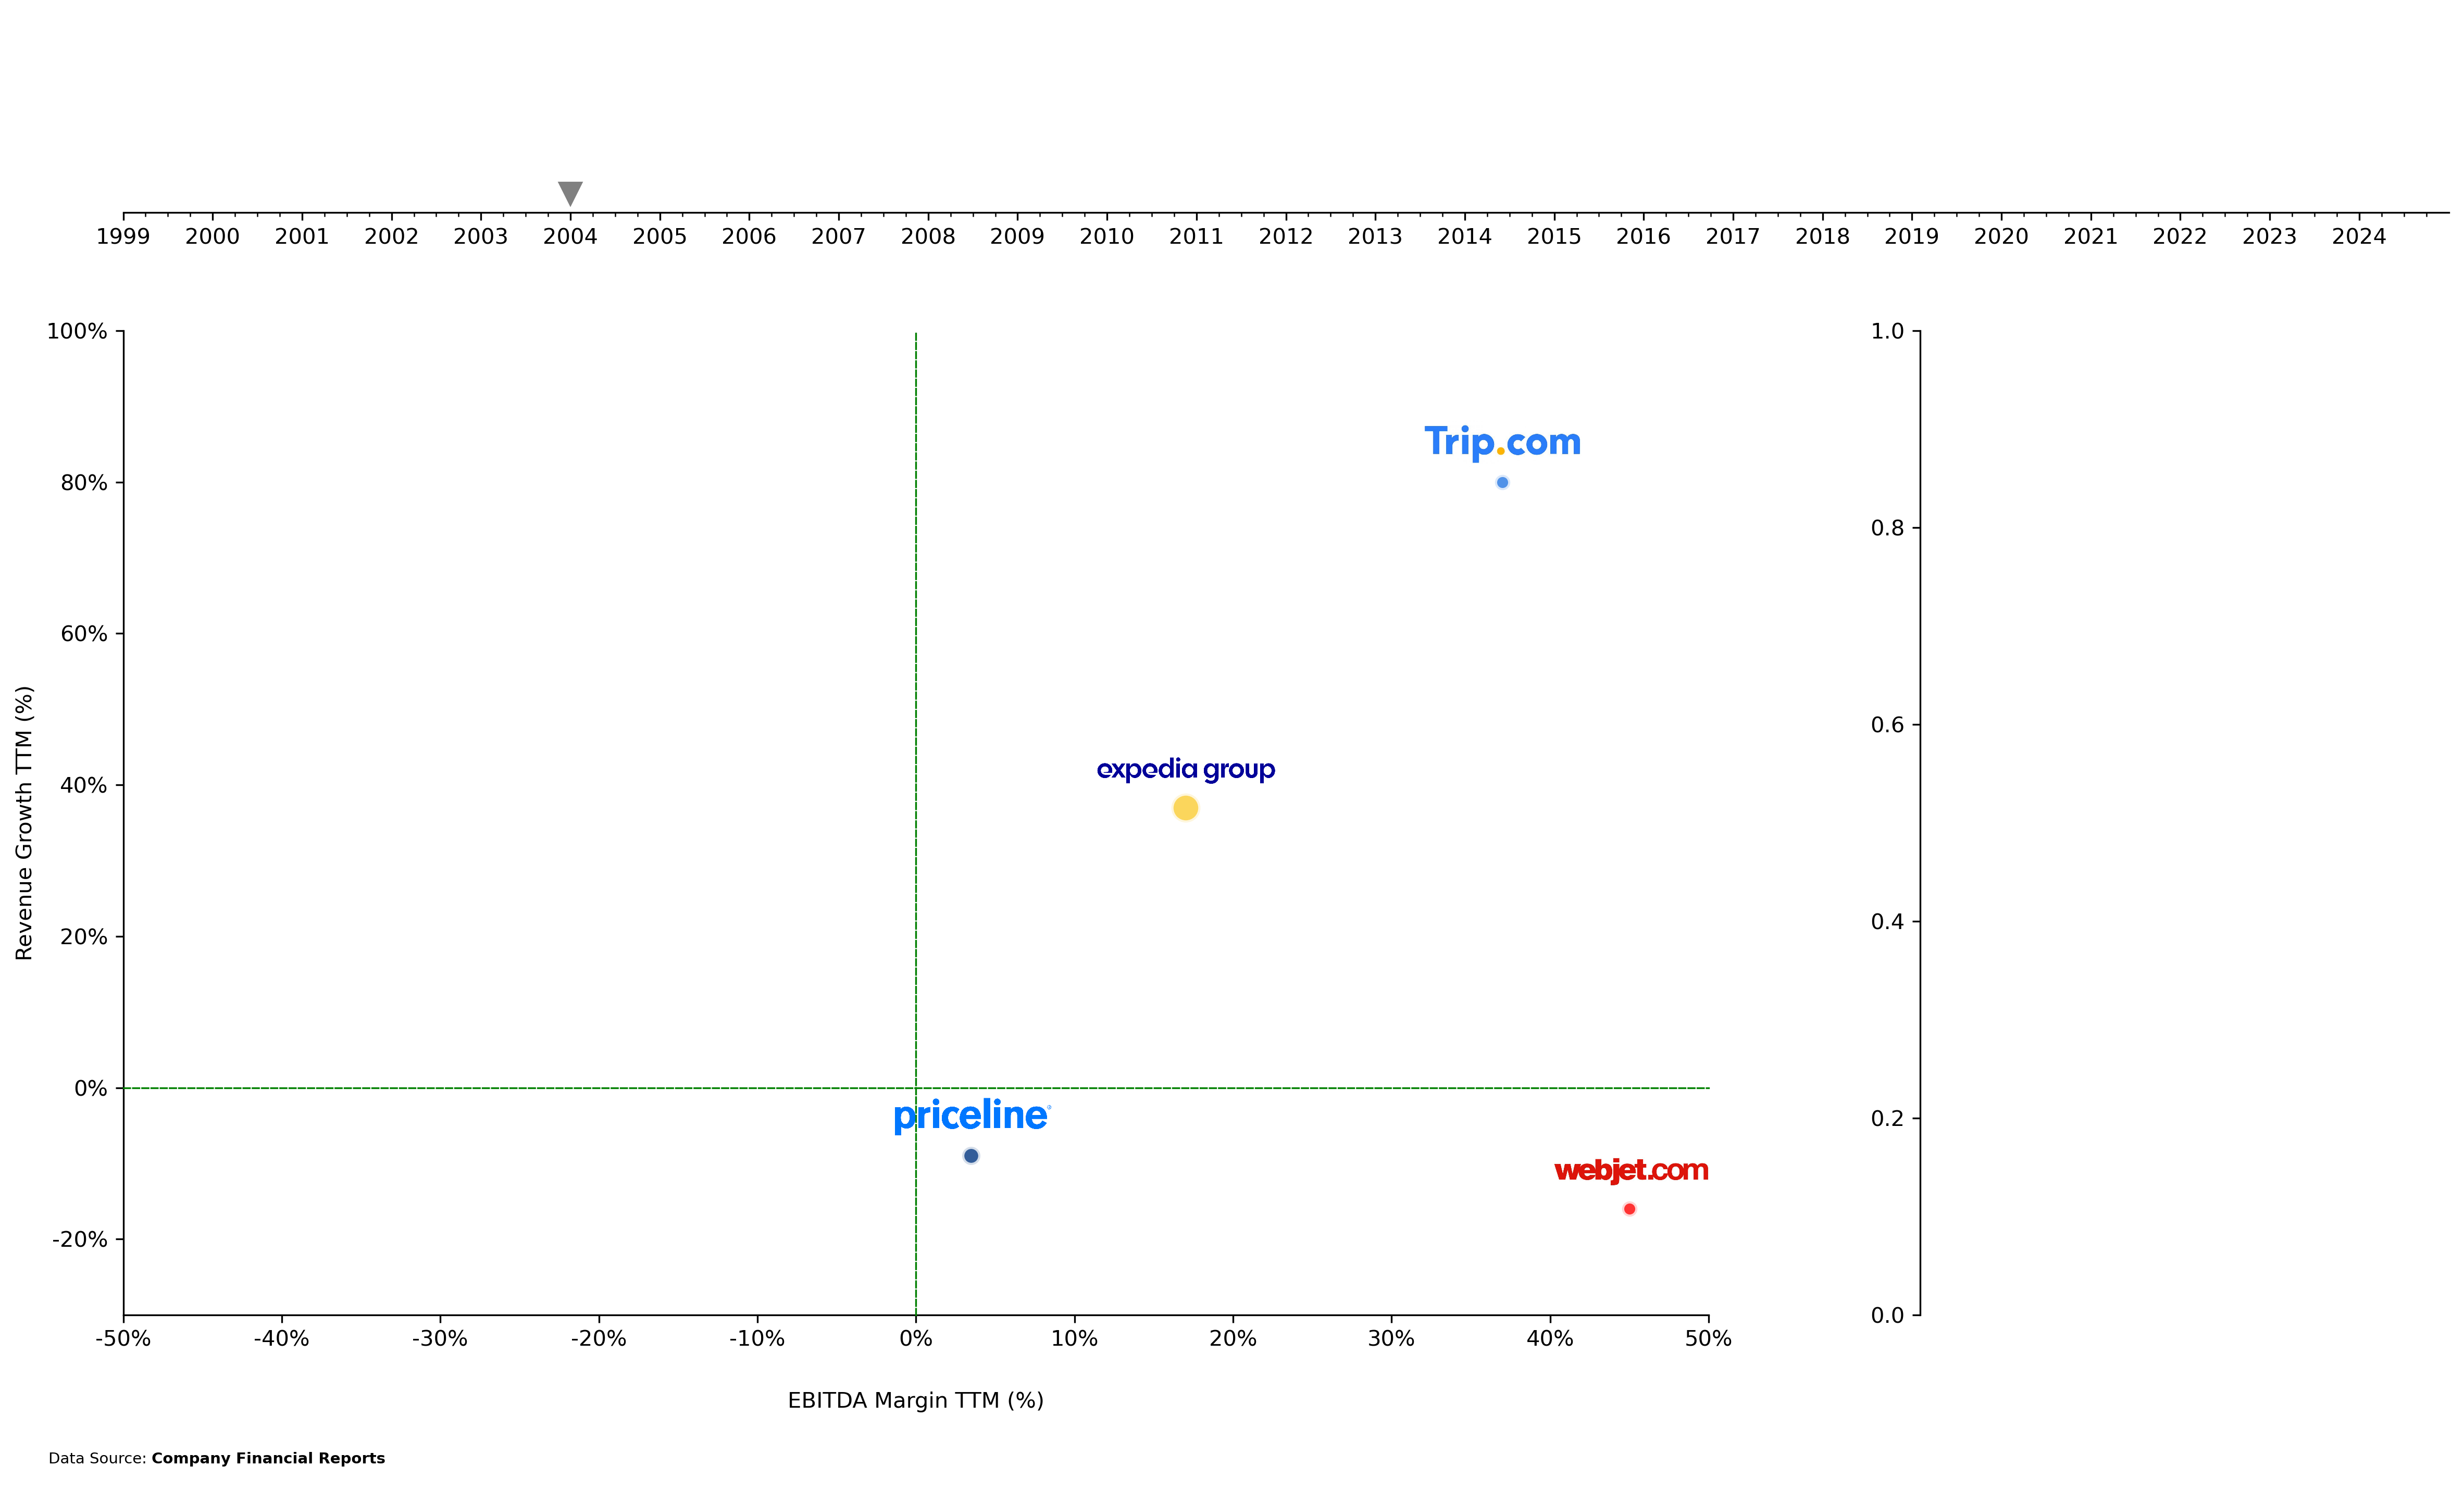

In [52]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EaseMyTrip': '#00a0e2',
    'Ixigo': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'Yatra': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480'
}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    fig_width = fig.get_size_inches()[0]
    scale = data_width / (fig_width * fig.dpi)
    native_width_in_pixels = image.shape[1]
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    return zoom_factor

def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    
    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1800, 50)  # 1500 is the scale, 100 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        
        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410)

    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
             highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
             ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)
    
    # Adjust comment to be higher to avoid overlap with the timeline
    ax.annotate(f"{quarter_year}:", xy=(-0.04, 1.22), xycoords='axes fraction', color="grey", ha='left', fontsize=14, 
                va='top', backgroundcolor='white', transform=ax.transAxes, clip_on=False)

    # Bar chart race: Filter and sort data by revenue, ensuring constant bar width
    # Filter companies with non-zero revenue
    filtered_data = yearly_data[yearly_data['Revenue'] > 0]
    
    # Sort filtered data by revenue and keep all companies, assigning zero revenue to companies not in the top 12
    sorted_data = filtered_data.set_index('Company').reindex(all_companies).fillna(0).sort_values(by='Revenue', ascending=True)

    # Hide company names with zero revenue by setting their names to empty strings
    sorted_data['Company_name'] = sorted_data.index.where(sorted_data['Revenue'] > 0, '')

    # Use the color_dict to map company names to colors
    bar_colors = sorted_data.index.map(color_dict)

    # Create horizontal bar chart for revenue with constant width for all companies
    bars = ax_barchart.barh(
        sorted_data['Company_name'],  # Use the modified company names (empty for zero-revenue)
        sorted_data['Revenue'], 
        color=bar_colors,  # Apply the custom colors
        height=0.8  # Set a constant height for the bars
    )

    # Add revenue labels to the bars in the bar chart
    for bar in bars:
        width = bar.get_width()
        if not np.isnan(width) and width > 0:  # Only add text if width is valid and greater than 0
            ax_barchart.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='left', fontsize=9)
    
    # Set axis limits and labels for the bar chart race (fixed width for absolute size)
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)  # Fixed axis limit based on max revenue in the data

    # Hide axes and ticks for the bar chart except for the left axis (company names)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)

    # Set the x-axis label (This will be shown)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8)

    # Hide the x-axis ticks and tick labels
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis tick marks and labels

    return dots_and_logos + [ax_timeline, ax_barchart]


# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()


In [64]:
import emoji

ValueError: Invalid RGBA argument: nan

Error in callback <function _draw_all_if_interactive at 0x10fee40e0> (for post_execute):


ValueError: Invalid RGBA argument: nan

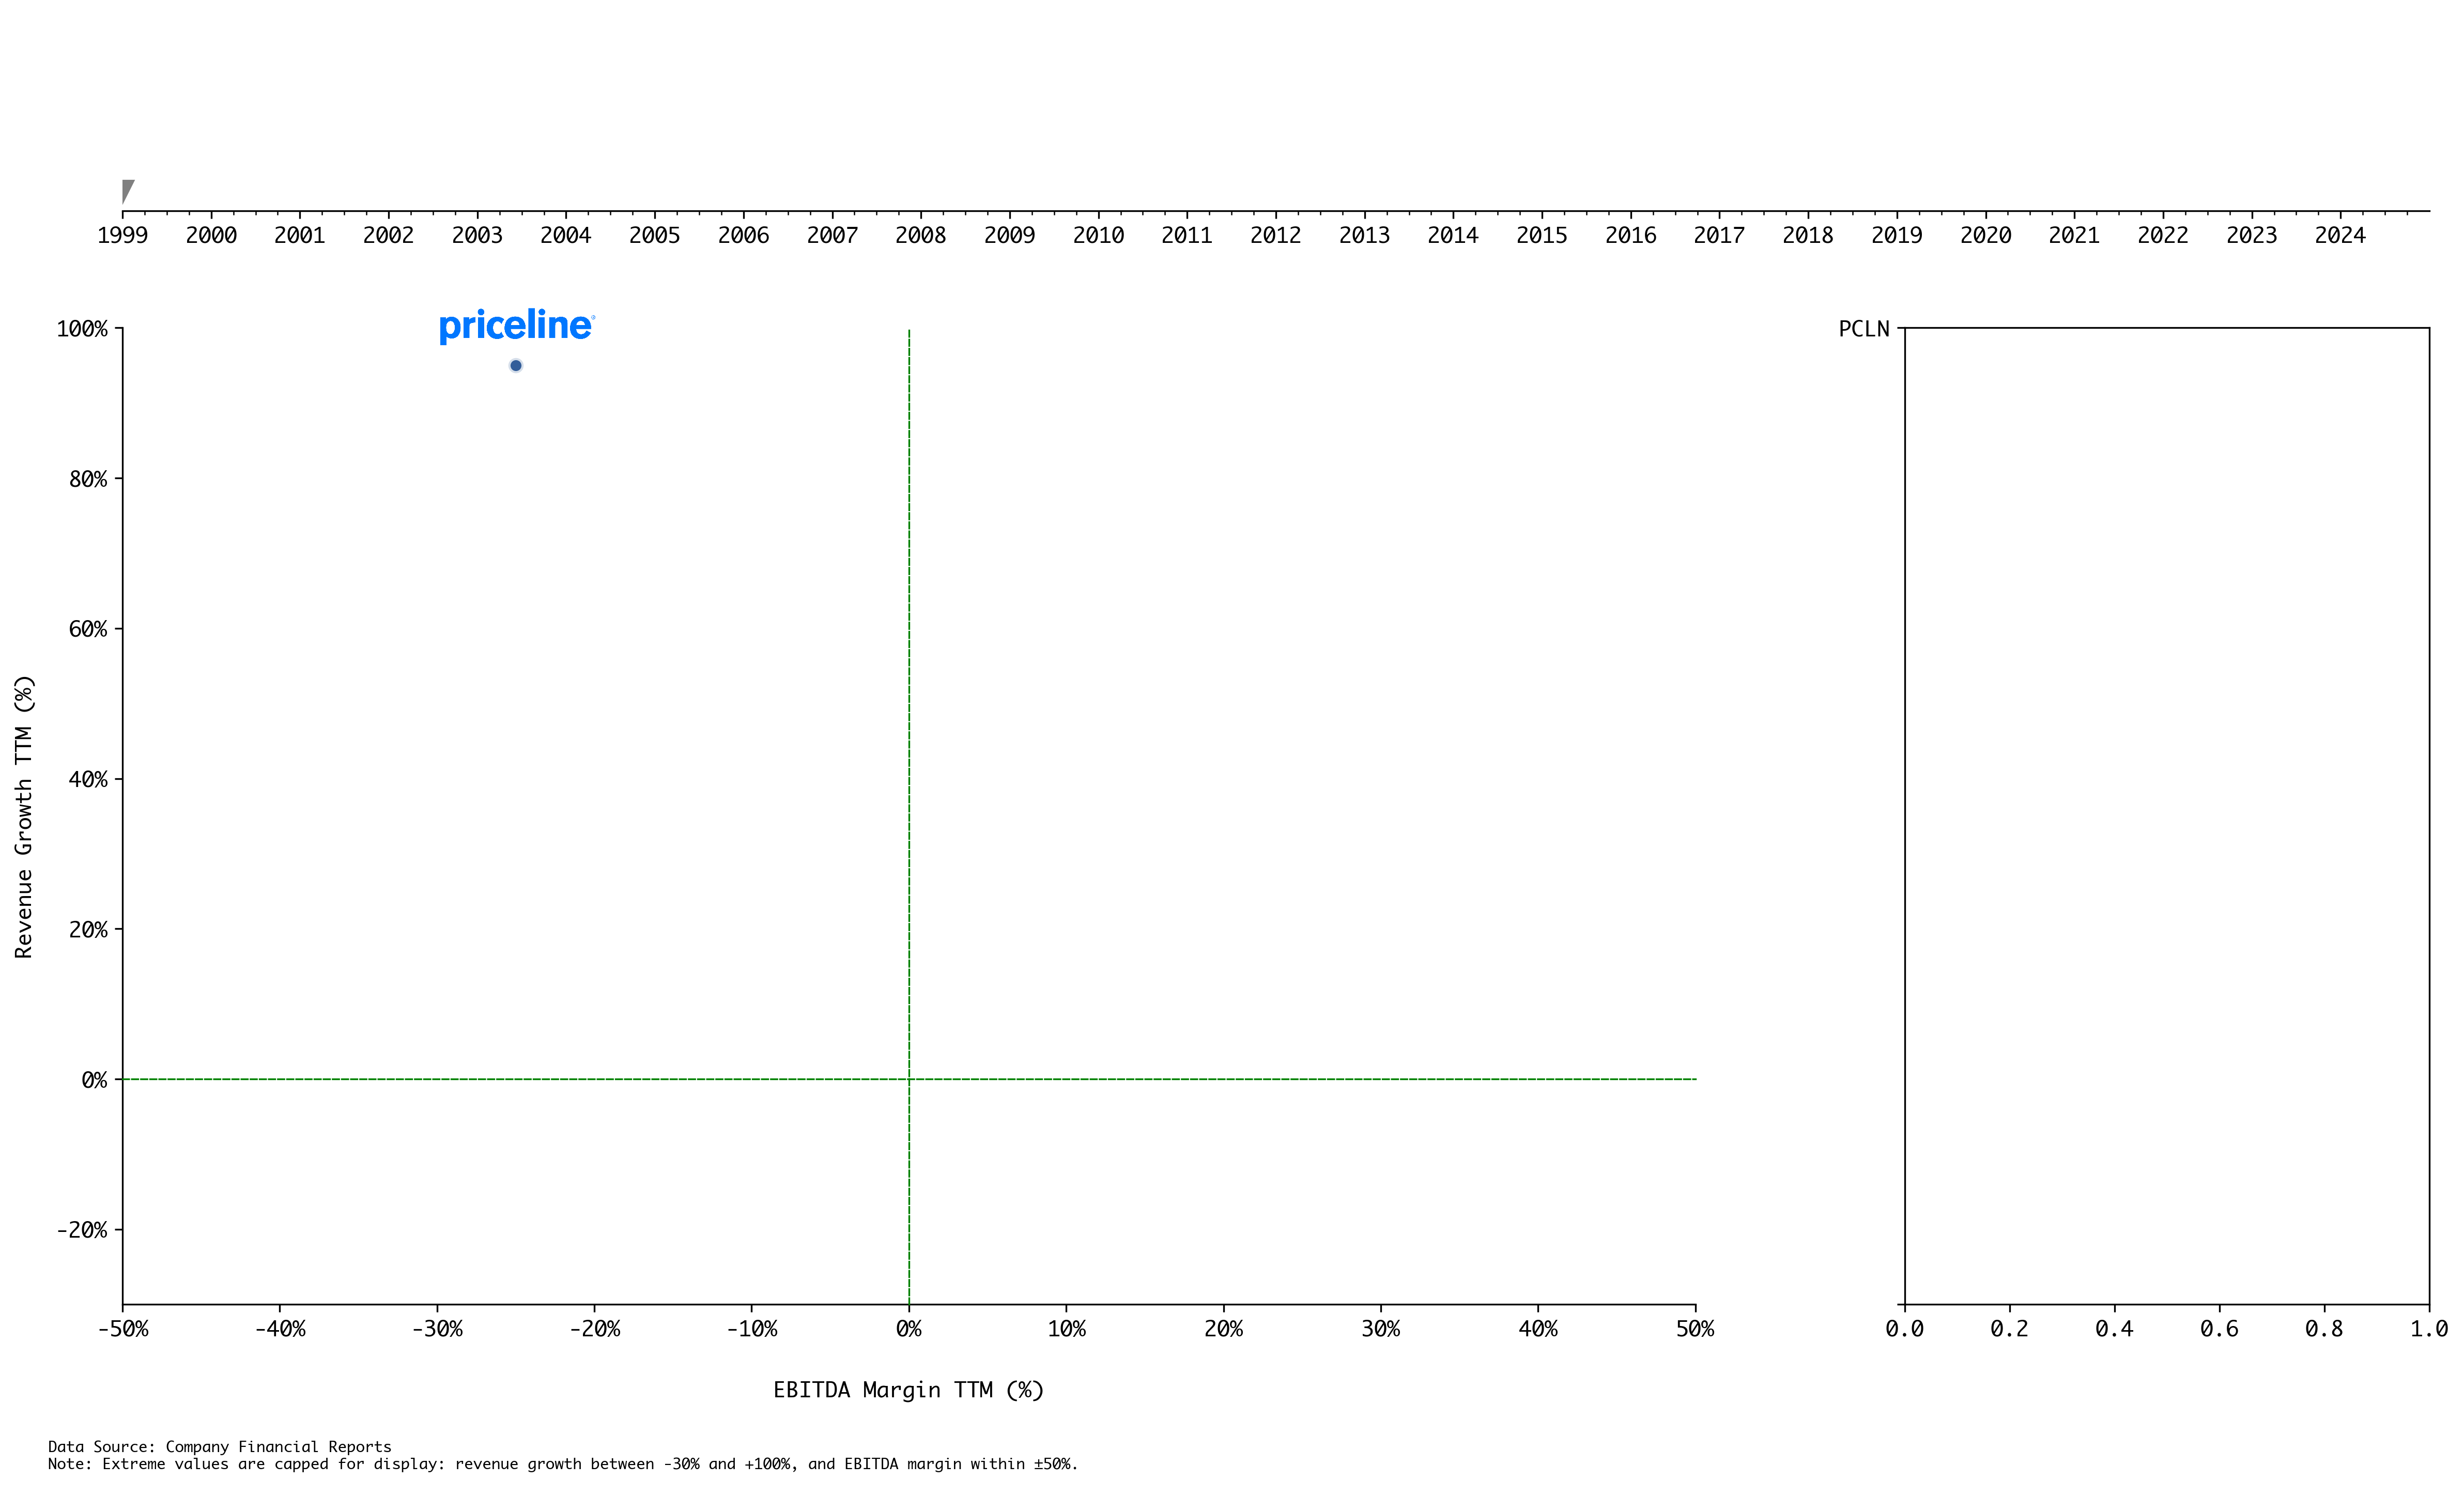

In [10]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EaseMyTrip': '#00a0e2',
    'Ixigo': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'Yatra': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480'
}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com IPO", 'flags/us_flag.png'),
    (1999.92, "Nov'1999 Expedia IPO", 'flags/us_flag.png'),
    (2000.25, "Mar'2000 Lastminute.com IPO", 'flags/eu_flag.png'),
    (2000.42, "May'2000 Webjet IPO", 'flags/au_flag.png'),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2000.75, "Oct'2000 Travelocity IPO Sabre maintains 70% ownership", 'flags/us_flag.png'),
    (2001.5, "Jun'2001 Expedia acquires Hotels.com", 'flags/us_flag.png'),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip IPO", 'flags/cn_flag.png'),
    (2003.92, "Dec'2003 Orbitz IPO", 'flags/us_flag.png'),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels", None),
    (2005.42, "May'2005 Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com merging it with Active Hotels", None),
    (2006.58, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.58, "Jul'2007 Orbitz IPO for second time", 'flags/us_flag.png'),
    (2010.58, "Jul'2010 ITA Software accepts bid to be acquired by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip IPO", 'flags/in_flag.png'),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.5, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", 'flags/eu_flag.png'),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor into a public company", 'flags/us_flag.png'),
    (2012.25, "Apr'2012 Al Tayyar Travel IPO (now SEERA Group)", 'flags/sa_flag.png'),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", 'flags/id_flag.png'),
    (2012.92, "Dec'2012 Expedia Group acquires Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak", None),
    (2014.25, "Apr'2014 eDreams ODIGEO IPO", 'flags/eu_flag.png'),
    (2014.25, "Apr'2014 Bravofly Rumbo IPO", 'flags/ch_flag.png'),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.17, "Feb'2015 Expedia Group acquires Orbitz & Travelocity", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.75, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Dec'2015 Expedia Group acquires HomeAway", None),
    (2016.75, "Sep'2016 Concur acquires Hipmunk", None),
    (2016.92, "Nov'2016 Ctrip acquires Skyscanner", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.92, "Dec'2016 Trivago IPO", 'flags/eu_flag.png'),
    (2016.92, "Dec'2016 Yatra IPO", 'flags/in_flag.png'),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar IPO", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.15, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    for i, event in enumerate(events):
        event_text, flag_path = event[1], event[2]
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y
        
        # Add the event description text with an adjustable font size
        fig_text(x_position, text_y_offset, event_text, ha='left', fontsize=fontsize, color="black", fig=fig)

        # Add the flag image if it exists
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)


def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    
    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 100 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        
        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410)

    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
             highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
             ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)
    
    # Adjust comment to be higher to avoid overlap with the timeline


    
    # ax.annotate(f"{quarter_year}:", xy=(-0.04, 1.22), xycoords='axes fraction', color="grey", ha='left', fontsize=14, 
    #             va='top', backgroundcolor='white', transform=ax.transAxes, clip_on=False)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)
    
    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Bar chart race: Filter and sort data by revenue, ensuring constant bar width
    filtered_data = yearly_data[yearly_data['Revenue'] > 0]
    sorted_data = filtered_data.set_index('Company').reindex(all_companies).fillna(0).sort_values(by='Revenue', ascending=True)

    # Hide company names with zero revenue by setting their names to empty strings
    sorted_data['Company_name'] = sorted_data.index.where(sorted_data['Revenue'] > 0, '')

    # Use the color_dict to map company names to colors
    bar_colors = sorted_data.index.map(color_dict)

    # Create horizontal bar chart for revenue with constant width for all companies
    bars = ax_barchart.barh(
        sorted_data['Company_name'],  # Use the modified company names (empty for zero-revenue)
        sorted_data['Revenue'], 
        color=bar_colors,  # Apply the custom colors
        height=0.8  # Set a constant height for the bars
    )

    # Add revenue labels to the bars in the bar chart
    for bar in bars:
        width = bar.get_width()
        if not np.isnan(width) and width > 0:  # Only add text if width is valid and greater than 0
            ax_barchart.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='left', fontsize=9)
    
    # Set axis limits and labels for the bar chart race (fixed width for absolute size)
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)  # Fixed axis limit based on max revenue in the data

    # Hide axes and ticks for the bar chart except for the left axis (company names)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)

    # Set the x-axis label (This will be shown)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8)

    # Hide the x-axis ticks and tick labels
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis tick marks and labels

    return dots_and_logos + [ax_timeline, ax_barchart]

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()


KeyboardInterrupt: 

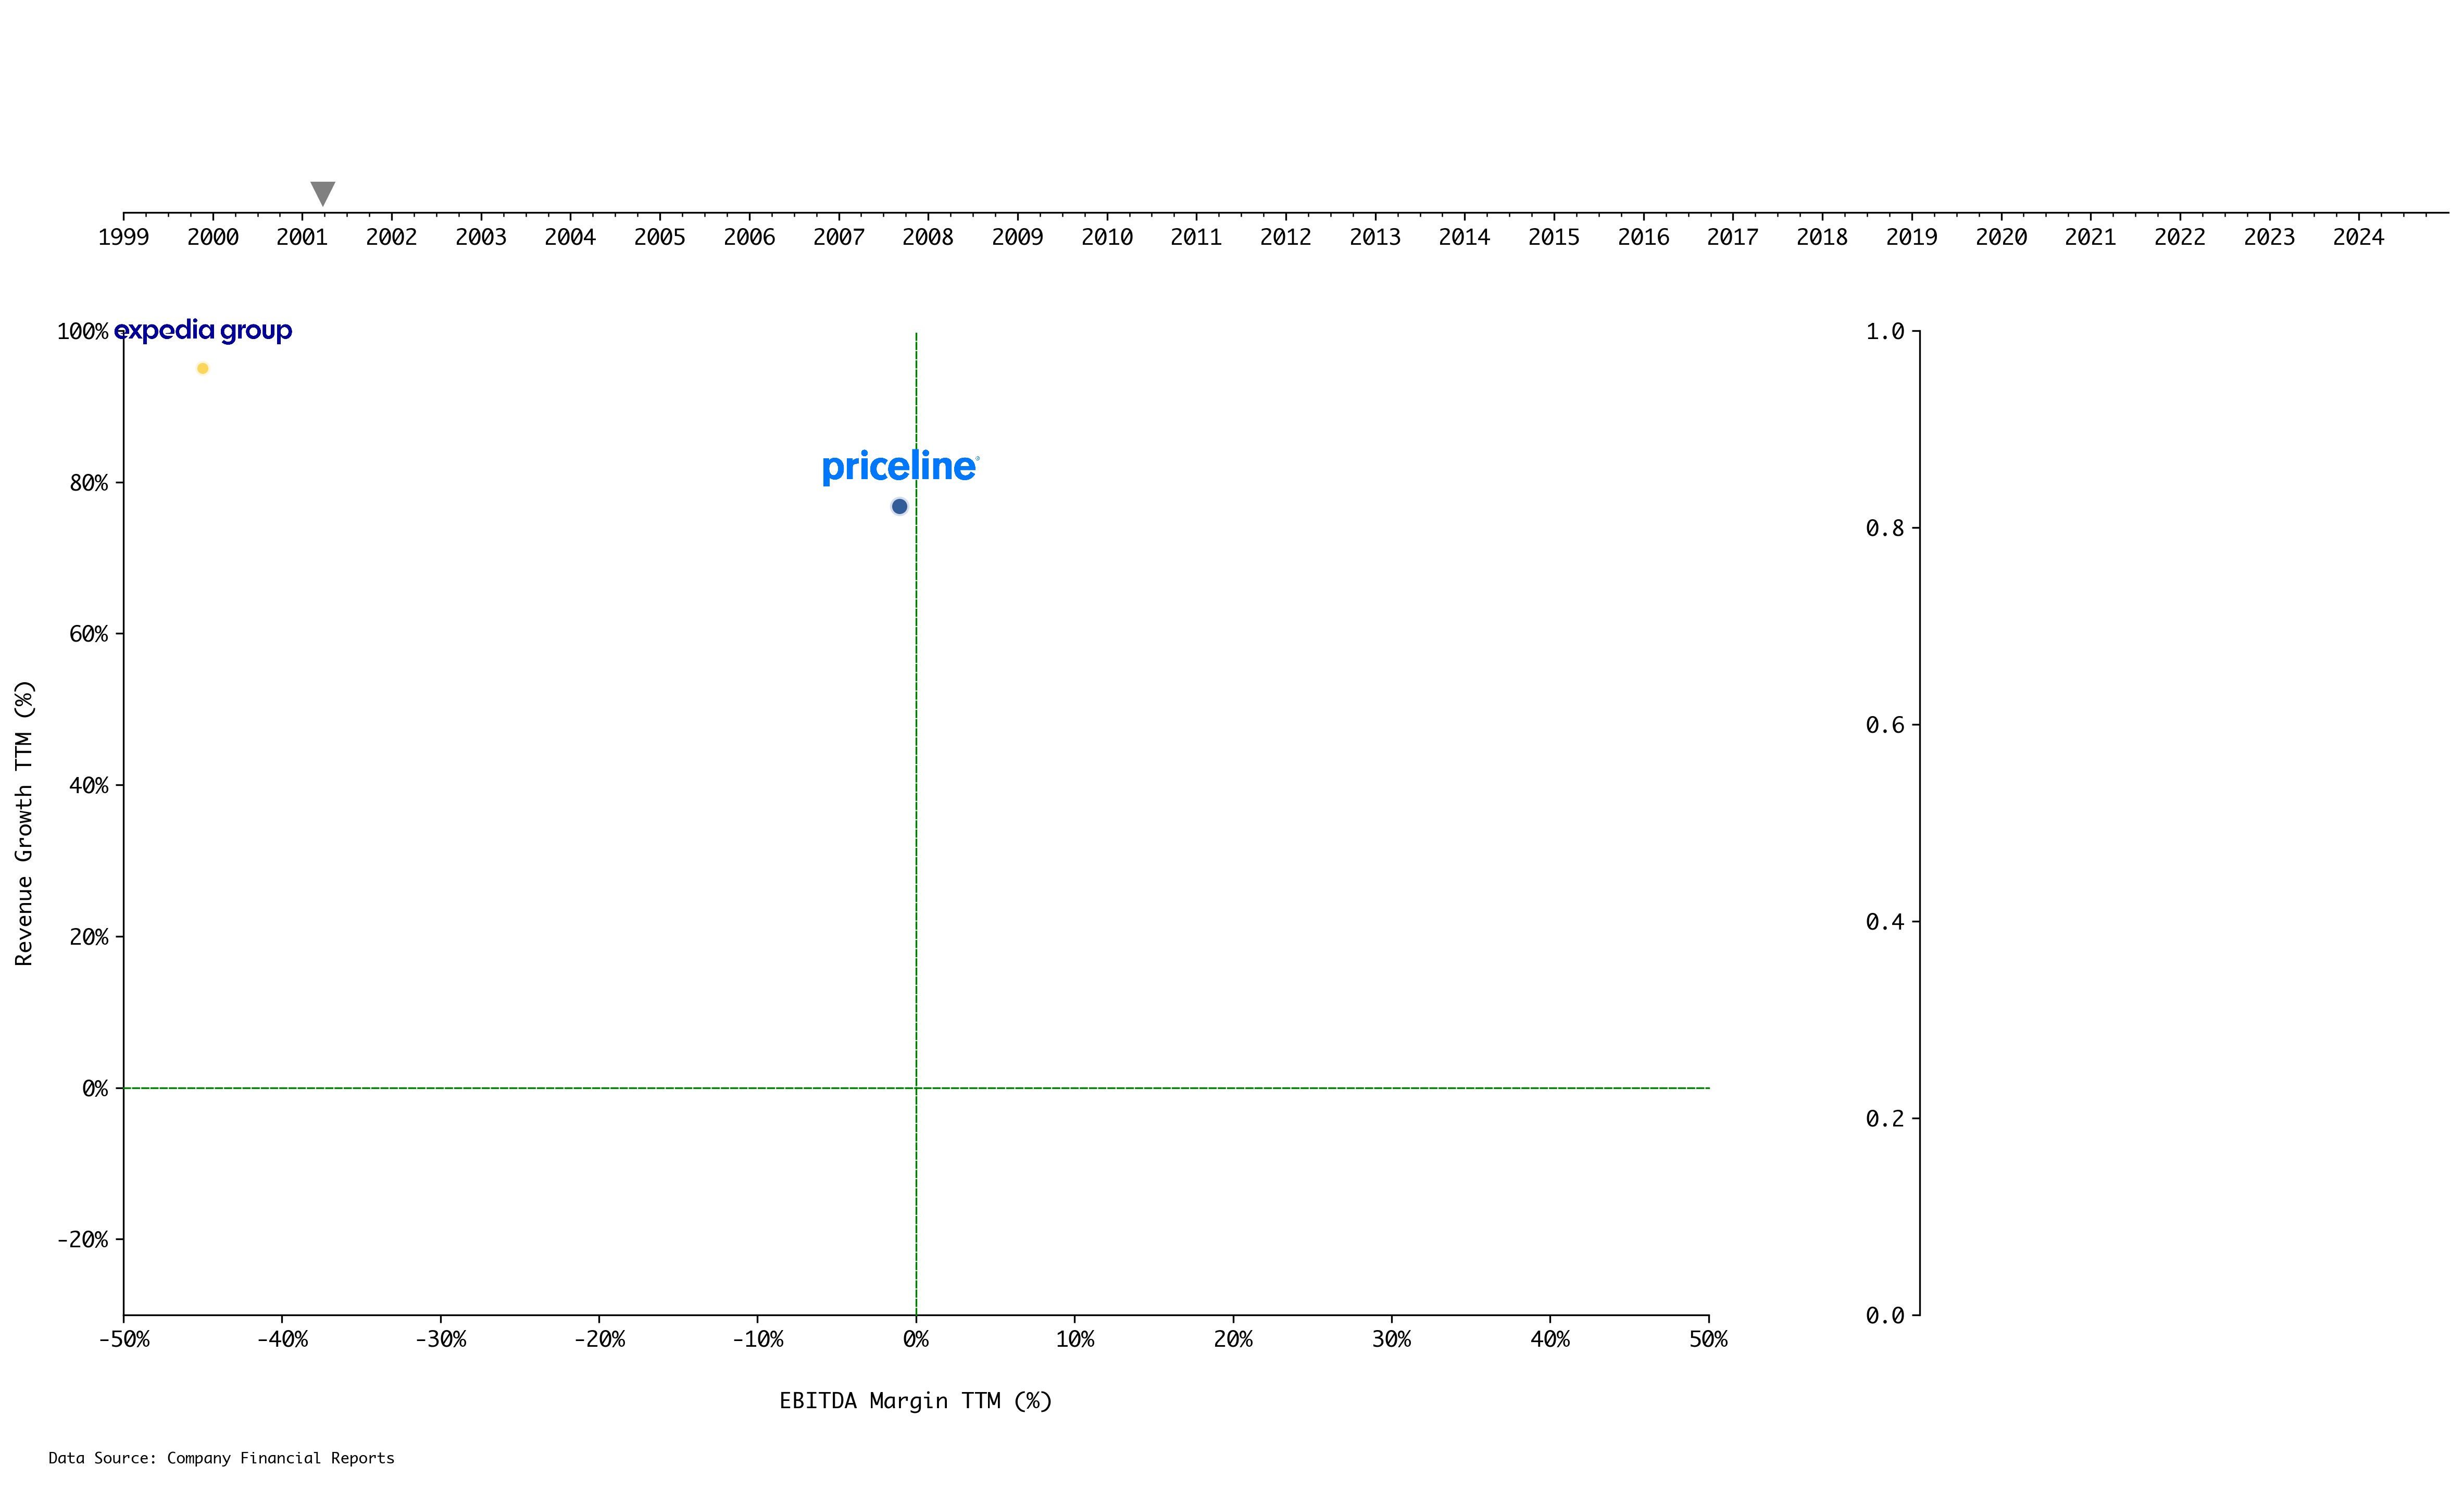

In [16]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EaseMyTrip': '#00a0e2',
    'Ixigo': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'Yatra': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480'
}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com IPO", 'flags/us_flag.png'),
    (1999.92, "Nov'1999 Expedia IPO", 'flags/us_flag.png'),
    (2000.25, "Mar'2000 Lastminute.com IPO", 'flags/eu_flag.png'),
    (2000.42, "May'2000 Webjet IPO", 'flags/au_flag.png'),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2000.75, "Oct'2000 Travelocity IPO Sabre maintains 70% ownership", 'flags/us_flag.png'),
    (2001.5, "Jun'2001 Expedia acquires Hotels.com", 'flags/us_flag.png'),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip IPO", 'flags/cn_flag.png'),
    (2003.92, "Dec'2003 Orbitz IPO", 'flags/us_flag.png'),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels", None),
    (2005.42, "May'2005 Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com merging it with Active Hotels", None),
    (2006.58, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.58, "Jul'2007 Orbitz IPO for second time", 'flags/us_flag.png'),
    (2010.58, "Jul'2010 ITA Software accepts bid to be acquired by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip IPO", 'flags/in_flag.png'),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.5, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", 'flags/eu_flag.png'),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor into a public company", 'flags/us_flag.png'),
    (2012.25, "Apr'2012 Al Tayyar Travel IPO (now SEERA Group)", 'flags/sa_flag.png'),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", 'flags/id_flag.png'),
    (2012.92, "Dec'2012 Expedia Group acquires Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak", None),
    (2014.25, "Apr'2014 eDreams ODIGEO IPO", 'flags/eu_flag.png'),
    (2014.25, "Apr'2014 Bravofly Rumbo IPO", 'flags/ch_flag.png'),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.17, "Feb'2015 Expedia Group acquires Orbitz & Travelocity", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.75, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Dec'2015 Expedia Group acquires HomeAway", None),
    (2016.75, "Sep'2016 Concur acquires Hipmunk", None),
    (2016.92, "Nov'2016 Ctrip acquires Skyscanner", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.92, "Dec'2016 Trivago IPO", 'flags/eu_flag.png'),
    (2016.92, "Dec'2016 Yatra IPO", 'flags/in_flag.png'),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar IPO", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.15, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    # Set a fixed-width font (monospaced) for better alignment
    plt.rcParams['font.family'] = 'Monaco'  # Use a monospaced font like 'Courier'
    
    for i, event in enumerate(events):
        # Split the event into date and description
        event_text, flag_path = event[1], event[2]
        
        # Format the date and event description for alignment (15 characters for date)
        # Adjust the width of the date so the description starts at the same position
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y
        
        # Add the event description text with an adjustable font size
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, color="black", fig=fig)

        # Add the flag image if it exists
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)



def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    
    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 100 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        
        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410)

    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
             highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
             ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)
    
    # Adjust comment to be higher to avoid overlap with the timeline


    
    # ax.annotate(f"{quarter_year}:", xy=(-0.04, 1.22), xycoords='axes fraction', color="grey", ha='left', fontsize=14, 
    #             va='top', backgroundcolor='white', transform=ax.transAxes, clip_on=False)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)
    
    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Bar chart race: Filter and sort data by revenue, ensuring constant bar width
    filtered_data = yearly_data[yearly_data['Revenue'] > 0]
    sorted_data = filtered_data.set_index('Company').reindex(all_companies).fillna(0).sort_values(by='Revenue', ascending=True)

    # Hide company names with zero revenue by setting their names to empty strings
    sorted_data['Company_name'] = sorted_data.index.where(sorted_data['Revenue'] > 0, '')

    # Use the color_dict to map company names to colors
    bar_colors = sorted_data.index.map(color_dict)

    # Create horizontal bar chart for revenue with constant width for all companies
    bars = ax_barchart.barh(
        sorted_data['Company_name'],  # Use the modified company names (empty for zero-revenue)
        sorted_data['Revenue'], 
        color=bar_colors,  # Apply the custom colors
        height=0.8  # Set a constant height for the bars
    )

    # Add revenue labels to the bars in the bar chart
    for bar in bars:
        width = bar.get_width()
        if not np.isnan(width) and width > 0:  # Only add text if width is valid and greater than 0
            ax_barchart.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', ha='left', fontsize=9)
    
    # Set axis limits and labels for the bar chart race (fixed width for absolute size)
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)  # Fixed axis limit based on max revenue in the data

    # Hide axes and ticks for the bar chart except for the left axis (company names)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)

    # Set the x-axis label (This will be shown)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8)

    # Hide the x-axis ticks and tick labels
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis tick marks and labels

    return dots_and_logos + [ax_timeline, ax_barchart]

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()


TypeError: object of type 'float' has no len()

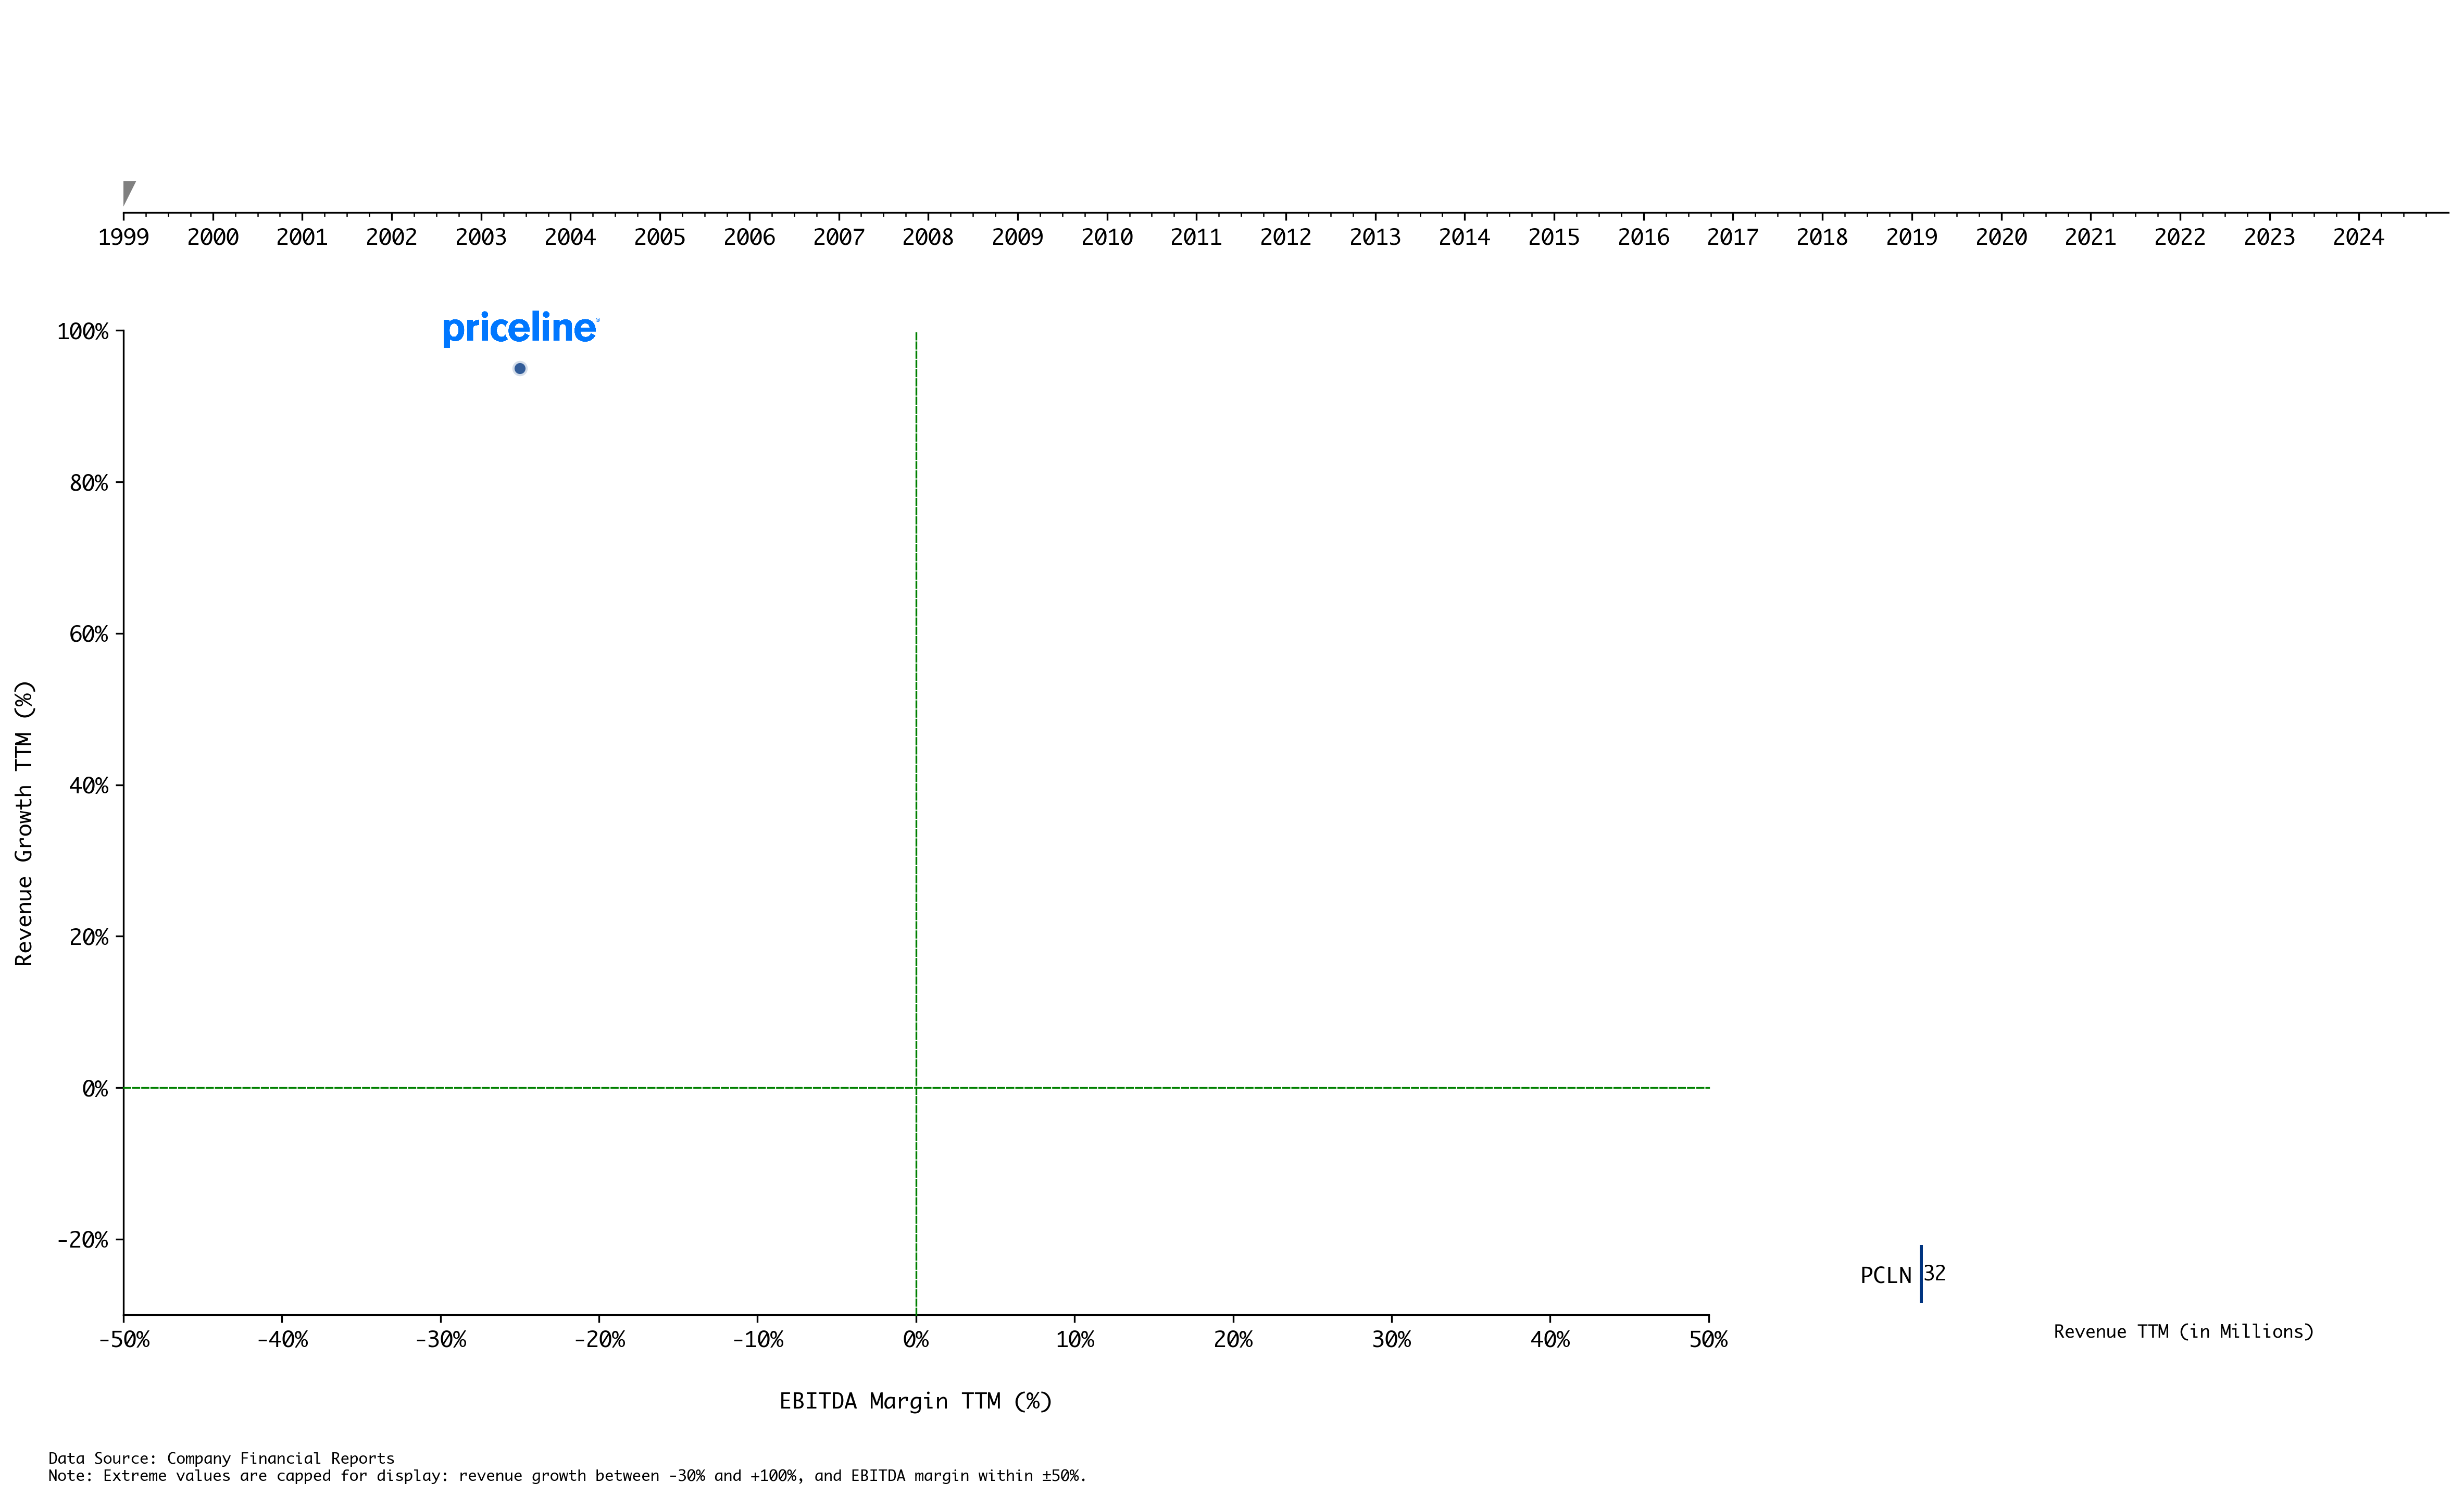

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator


# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EaseMyTrip': '#00a0e2',
    'Ixigo': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'Yatra': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480'
}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com IPO", 'flags/us_flag.png'),
    (1999.92, "Nov'1999 Expedia IPO", 'flags/us_flag.png'),
    (2000.25, "Mar'2000 Lastminute.com IPO", 'flags/eu_flag.png'),
    (2000.42, "May'2000 Webjet IPO", 'flags/au_flag.png'),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2000.75, "Oct'2000 Travelocity IPO Sabre maintains 70% ownership", 'flags/us_flag.png'),
    (2001.5, "Jun'2001 Expedia acquires Hotels.com", 'flags/us_flag.png'),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip IPO", 'flags/cn_flag.png'),
    (2003.92, "Dec'2003 Orbitz IPO", 'flags/us_flag.png'),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels", None),
    (2005.42, "May'2005 Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com merging it with Active Hotels", None),
    (2006.58, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.58, "Jul'2007 Orbitz IPO for second time", 'flags/us_flag.png'),
    (2010.58, "Jul'2010 ITA Software accepts bid to be acquired by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip IPO", 'flags/in_flag.png'),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.5, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", 'flags/eu_flag.png'),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor into a public company", 'flags/us_flag.png'),
    (2012.25, "Apr'2012 Al Tayyar Travel IPO (now SEERA Group)", 'flags/sa_flag.png'),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", 'flags/id_flag.png'),
    (2012.92, "Dec'2012 Expedia Group acquires Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak", None),
    (2014.25, "Apr'2014 eDreams ODIGEO IPO", 'flags/eu_flag.png'),
    (2014.25, "Apr'2014 Bravofly Rumbo IPO", 'flags/ch_flag.png'),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.17, "Feb'2015 Expedia Group acquires Orbitz & Travelocity", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.75, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Dec'2015 Expedia Group acquires HomeAway", None),
    (2016.75, "Sep'2016 Concur acquires Hipmunk", None),
    (2016.92, "Nov'2016 Ctrip acquires Skyscanner", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.92, "Dec'2016 Trivago IPO", 'flags/eu_flag.png'),
    (2016.92, "Dec'2016 Yatra IPO", 'flags/in_flag.png'),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar IPO", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.15, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    # Set a fixed-width font (monospaced) for better alignment
    plt.rcParams['font.family'] = 'Monaco'  # Use a monospaced font like 'Courier'
    
    for i, event in enumerate(events):
        # Split the event into date and description
        event_text, flag_path = event[1], event[2]
        
        # Format the date and event description for alignment (15 characters for date)
        # Adjust the width of the date so the description starts at the same position
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y
        
        # Add the event description text with an adjustable font size
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, color="black", fig=fig)

        # Add the flag image if it exists
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)



def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()
    
    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)
    
    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 100 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)
        
        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410)

    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
             highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
             ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig)

    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)
    
    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)
    
    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()
    
    # Sort the data by revenue in ascending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)
    
    # Limit the number of bars to display (e.g., top 12 companies)
    max_bars = 12

    # Set a constant height for the bars
    bar_height = 0.7  # Adjust as needed

    # Filter data for companies with revenue
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()

    # Sort the data by revenue in descending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=False)

    # Get the number of companies to display (up to max_bars)
    num_companies = min(len(sorted_data), max_bars)

    # Get the data for the top companies
    top_companies = sorted_data.head(num_companies)

    # Y positions for the bars, starting from the top, adjacent to each other
    y_positions = np.arange(num_companies)

    # Map company names to colors
    bar_colors = top_companies['Company'].map(color_dict)

    # Create horizontal bar chart
    bars = ax_barchart.barh(
        y_positions,
        top_companies['Revenue'],
        color=bar_colors,
        height=bar_height
    )

    # Set y-axis limits to keep the chart area consistent
    ax_barchart.set_ylim(-0.5, max_bars - 0.5)

    # Add company names as y-tick labels
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'])

    # Add revenue labels to the bars
    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f'{int(width)}',
                va='center',
                ha='left',
                fontsize=9
            )

    # Adjust aesthetics
    # Ensure the highest revenue is at the top by not inverting the y-axis
    # Remove invert_yaxis() if it exists
    # ax_barchart.invert_yaxis()  # Do not invert y-axis

    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)  # Hide tick marks
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8)

    return dots_and_logos + [ax_timeline, ax_barchart]

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()




/var/folders/6l/g010hzt54zd77rm1w4gyd4br0000gn/T/ipykernel_5047/776369826.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontproperties=open_sans_font)
/var/folders/6l/g010hzt54zd77rm1w4gyd4br0000gn/T/ipykernel_5047/776369826.py:279: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontproperties=open_sans_font)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
fin

KeyboardInterrupt: 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Open Sans
/var/folders/6l/g010hzt54zd77rm1w4gyd4br0000gn/T/ipykernel_5047/776369826.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontproperties=open_sans_font)
/var/folders/6l/g010hzt54zd77rm1w4gyd4br0000gn/T/ipykernel_5047/776369826.py:279: UserWarning: FixedFormatter should onl

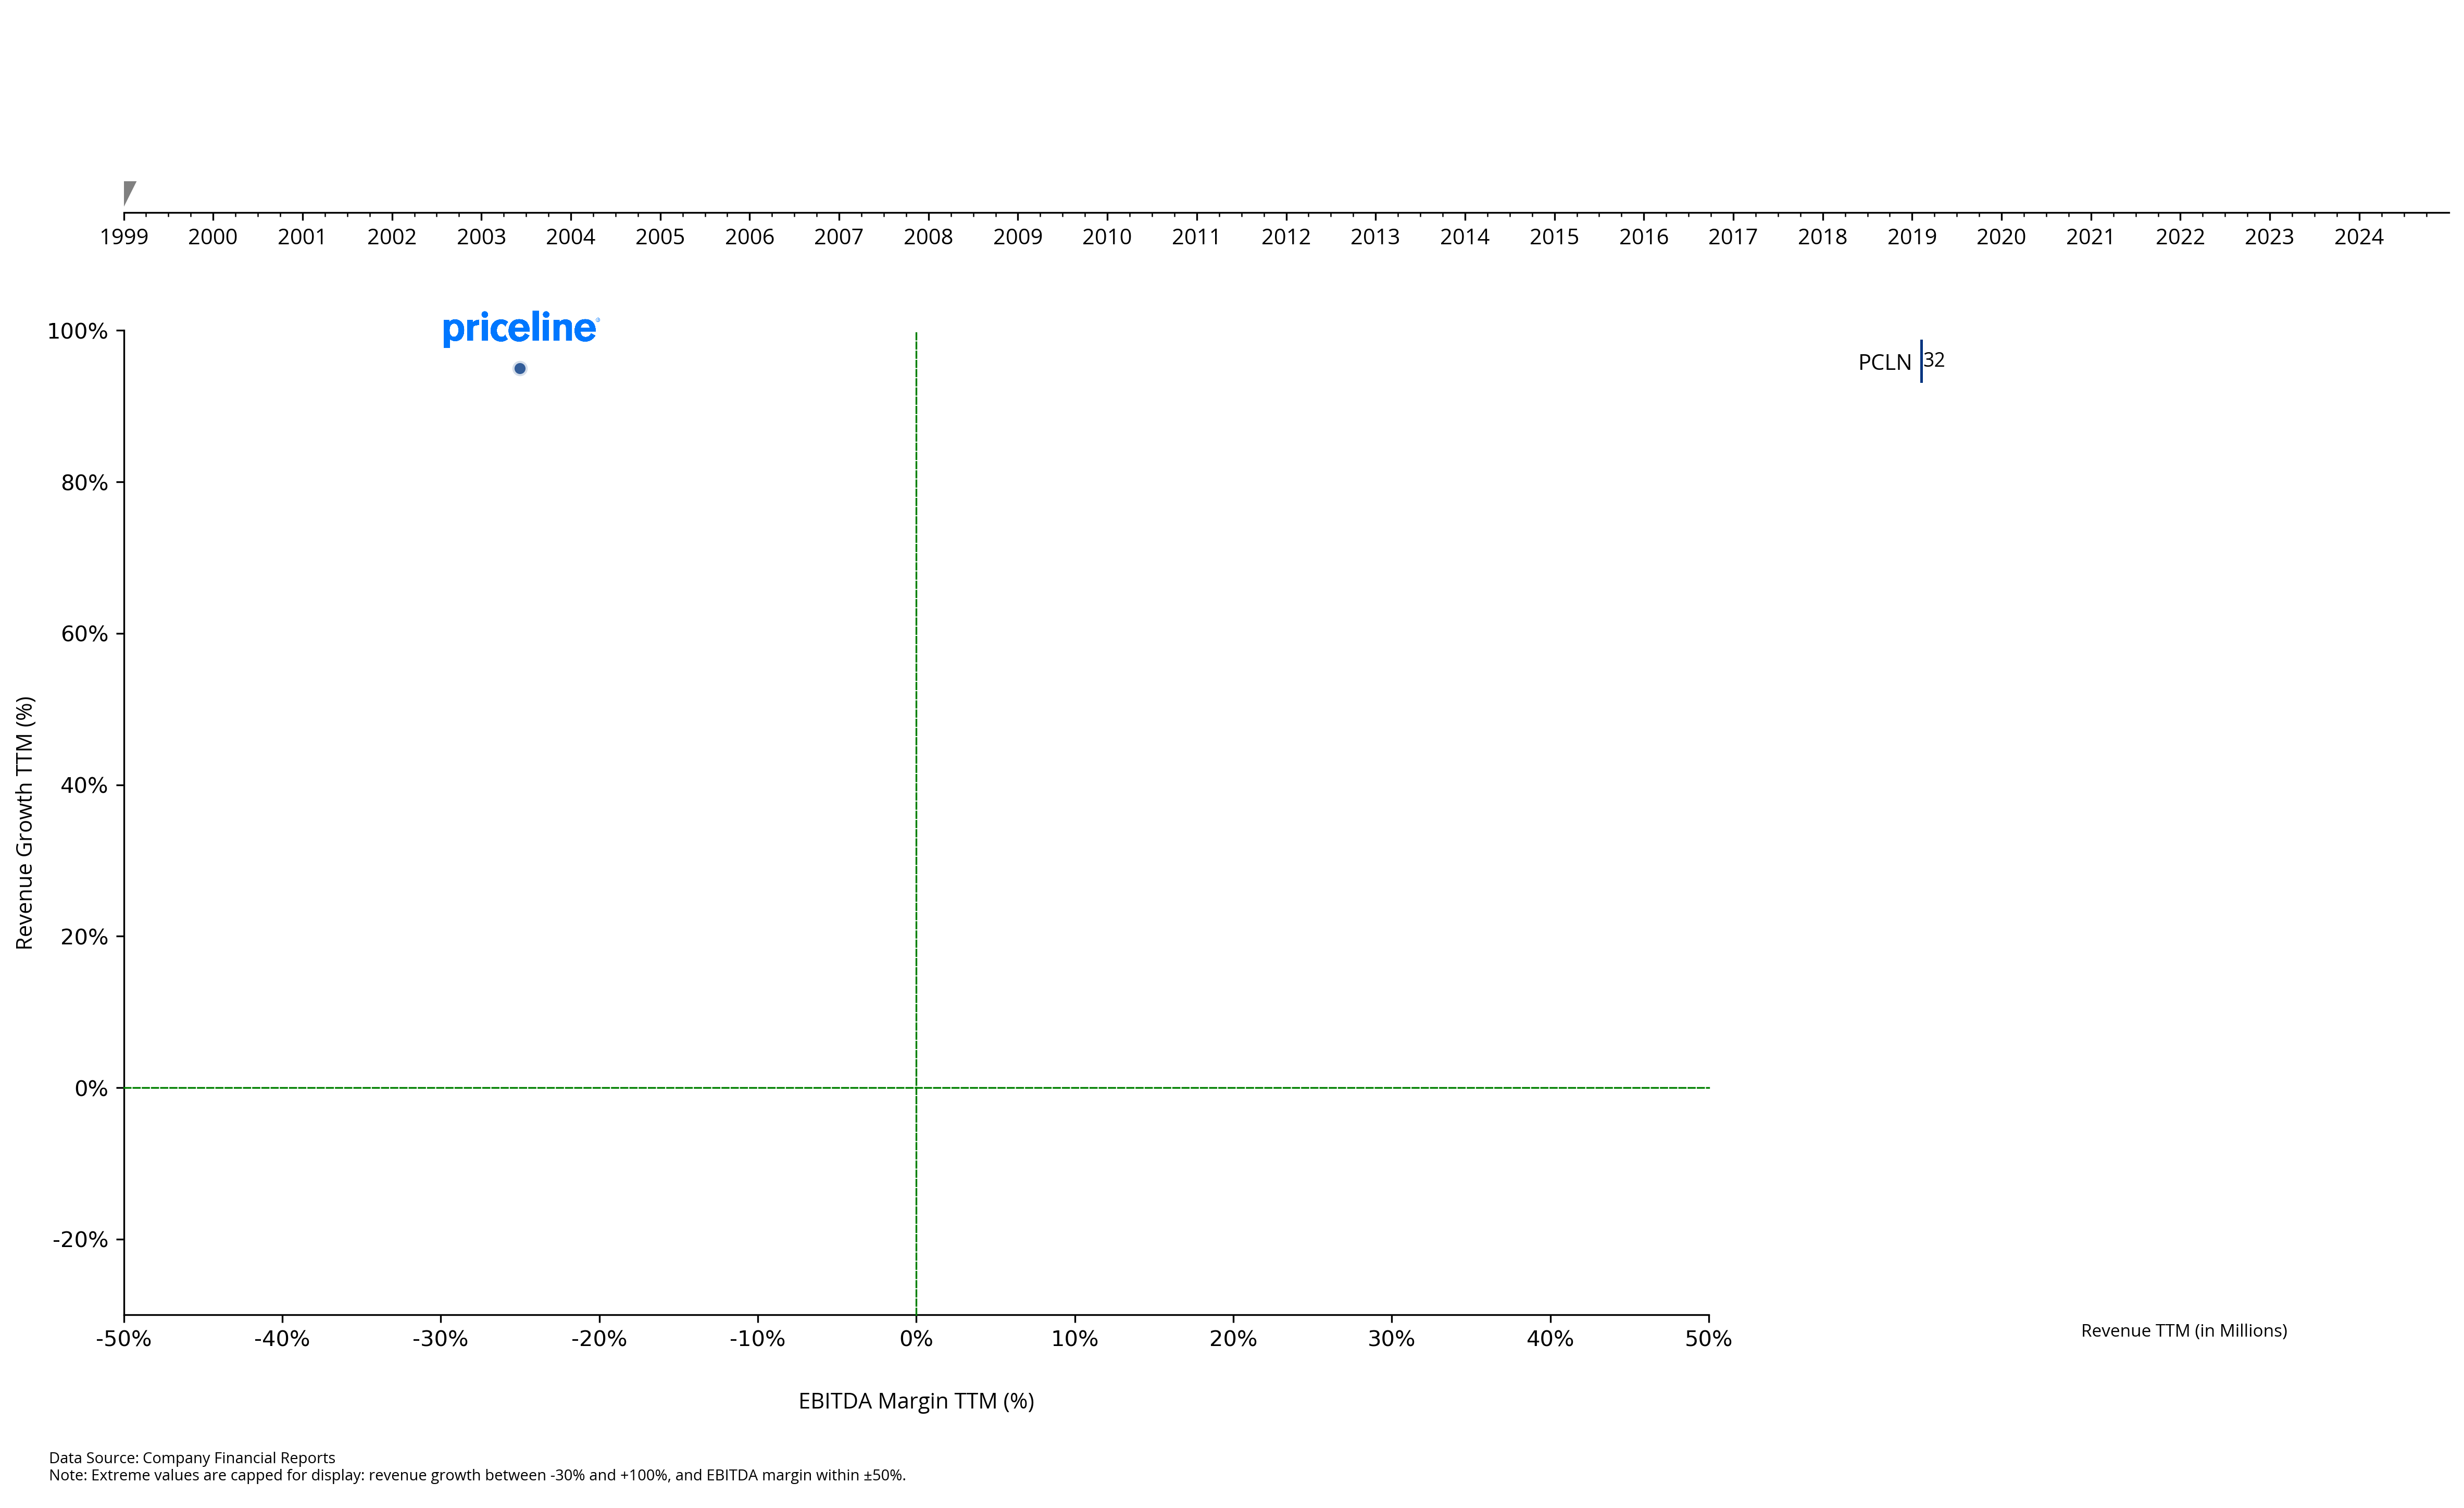

In [33]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.font_manager import FontProperties


plt.rcParams['font.family'] = 'sans-serif'


deja_vu_font = FontProperties(family='DejaVu Sans Mono')
open_sans_font = FontProperties(fname='/Users/maxxtucker/Library/Fonts/OpenSans-VariableFont_wdth,wght.ttf')  # Change to the path where Open Sans is installed

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EASEMYTRIP': '#00a0e2',
    'IXIGO': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'YTRA': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'WEB': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480',
    'OWW': '#8edbfa',
    'Travelocity': '#1d3e5c',
    "OWW'": '#8edbfa',
    "LMN'": '#fc03b1',

}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com lists on NASDAQ", None),
    (1999.92, "Nov'1999 Expedia lists on NASDAQ", None),
    (2000.25, "Mar'2000 Lastminute.com lists on LSE", None),
    (2000.25, "Mar'2000 Sabre merges Travelocity with Preview Travel, owns 70%", None),
    (2000.25, "Mar'2000 Dot-com bubble. NASDAQ peaks before falling 78% by Oct'2002", None),
    (2000.42, "May'2000 Webjet lists on ASX", None),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2001.50, "Jun'2001 Expedia acquires Hotels.com", None),
    (2001.75, "Sep'2001 9/11 Terrorist attack. 20% cutback in air capacity in North America", None),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip lists on NASDAQ", None),
    (2003.92, "Dec'2003 Orbitz lists on NYSE", None),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels for $160mil", None),
    (2005.42, "May'2005 Sabre-owned Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com for $133mil merging it with Active Hotels", None),
    (2006.67, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.25, "Mar'2007 Sabre Holdings taken private by TPG & Silver Lake Partners", None),
    (2007.58, "Jul'2007 Orbitz lists on NYSE for the second time", None),
    (2008.08, "Jan'2008 The US housing bubble leads to the Great Recession (2008-2009)", None),
    (2010.58, "Jul'2010 ITA Software accepts $700mil acquisition bid by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip lists on NASDAQ", None),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.50, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", None),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor, listing it on NASDAQ", None),
    (2012.33, "Apr'2012 Al Tayyar Travel lists on Saudi Stock Exchange", None),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", None),
    (2012.92, "Dec'2012 Expedia Group acquires 62% of Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak for $1.8bn", None),
    (2014.25, "Apr'2014 eDreams ODIGEO lists on Madrid Stock Exchange", None),
    (2014.25, "Apr'2014 Bravofly Rumbo lists on SIX Swiss Exchange", None),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.08, "Feb'2015 Expedia Group acquires Orbitz for $1.6bn & Travelocity for $280mil", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.83, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Nov'2015 Expedia Group acquires HomeAway and VRBO for $3.9bn", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.83, "Oct'2016 Yatra lists on NASDAQ", None),
    (2016.92, "Dec'2016 Trivago lists on NASDAQ. Expedia maintains majority ownership", None),
    (2017.50, "Jun'2017 CVC Capital Partners acquires Etraveli for €508mil", None),
    (2017.50, "Jun'2017 Booking.com pulls out of Trivago. Trivago shares lose 80% in the next 12 months", None),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar lists on NASDAQ", None),
    (2018.08, "Feb'2018 The Priceline Group rebrands to Booking Holdings", None),
    (2019.25, "Mar'2019 Airbnb acquires HotelTonight for $400m", None),
    (2019.33, "Apr'2019 Al Tayyar Travel rebrands as SEERA Group", None),
    (2019.42, "May'2019 Google consolidates Flights, Hotel Finder & Trips products under one interface", None),
    (2019.67, "Aug'2019 Google sunsets Trips app", None),
    (2019.75, "Sep'2019 Ctrip rebrands as Trip.com Group", None),
    (2020.08, "Feb'2020 Start of COVID-19 pandemic. Severe travel restrictions worldwide", None),
    (2020.92, "Dec'2020 Airbnb lists on NASDAQ", None),
    (2021.25, "Mar'2021 EaseMyTrip lists on Bombay Stock Exchange", None),
    (2021.92, "Nov'2021 Etraveli Group accepts Booking Holdings' takeover bid for €1.6bn", None),
    (2023.75, "Sep'2023 EC blocks Booking Holdings-Etraveli merger", None),
    (2024.00, "Jun'2024 ixigo lists on Bombay Stock Exchange", None),
    (2024.10, "Aug'2024 US DoJ rules Google a monopoly in search and advertising", None),
    (2024.20, "Sep'2024 EC upholds a €2.4 billion fine against Google Shopping on antitrust charges", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.15, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    
    for i, event in enumerate(events):
        # Split the event into date and description
        event_text, flag_path = event[1], event[2]
        
        # Format the date and event description for alignment (15 characters for date)
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y
        
        # Add the event description text with DejaVu Sans Mono font
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, 
                 color="black", fig=fig, fontproperties=deja_vu_font)  # Use the DejaVu font here

        # Add the flag image if it exists
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)




def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()

    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)

    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    # Set the x-ticks (years) on the timeline to use Open Sans font
    ax_timeline.set_xticklabels(np.arange(1999, 2025, 1), fontproperties=open_sans_font)
    ax_timeline.tick_params(axis='x', which='both', labelsize=10)

    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

   

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 50 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)

        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.set_xticklabels(ax.get_xticks(), fontproperties=open_sans_font)
    ax.set_yticklabels(ax.get_yticks(), fontproperties=open_sans_font)
    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)
    

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    # Set the tick labels on the secondary x-axis and y-axis to use Open Sans font




    # Set axis labels using Open Sans font
    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140, fontproperties=open_sans_font)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410, fontproperties=open_sans_font)


    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
         highlight_textprops=[{'fontweight':'bold'}], fig=fig, fontproperties=open_sans_font)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
            ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig, fontproperties=open_sans_font)


    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)

    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Limit the number of bars to display
    max_bars = 16

    # Set a constant height for the bars
    bar_height = 0.7

    # Filter data for companies with revenue > 0
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()

    # Sort the data by revenue in descending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)

    # Get the number of companies to display
    num_companies = min(len(sorted_data), max_bars)

    # Get the data for the top companies
    top_companies = sorted_data.head(num_companies)

    # Reverse the y_positions so that the highest revenue is at the top
    y_positions = np.arange(num_companies)

    # Invert y_positions to start bars from the top
    y_positions = y_positions[::-1]

    # Map company names to colors
    bar_colors = top_companies['Company'].map(color_dict)

    # Create horizontal bar chart
    bars = ax_barchart.barh(
        y_positions,
        top_companies['Revenue'],
        color=bar_colors,
        height=bar_height
    )

    # Set y-axis limits
    ax_barchart.set_ylim(-0.5, max_bars - 0.5)

    # Add company names as y-tick labels
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'], fontproperties=open_sans_font)

    # Invert y-axis to have highest revenue at the top
    ax_barchart.invert_yaxis()

    # Add revenue labels to the bars
    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f'{int(width)}',
                va='center',
                ha='left',
                fontsize=9,
                fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
            )

    # Adjust aesthetics
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8, fontproperties=open_sans_font)

    return dots_and_logos + [ax_timeline, ax_barchart]


# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()




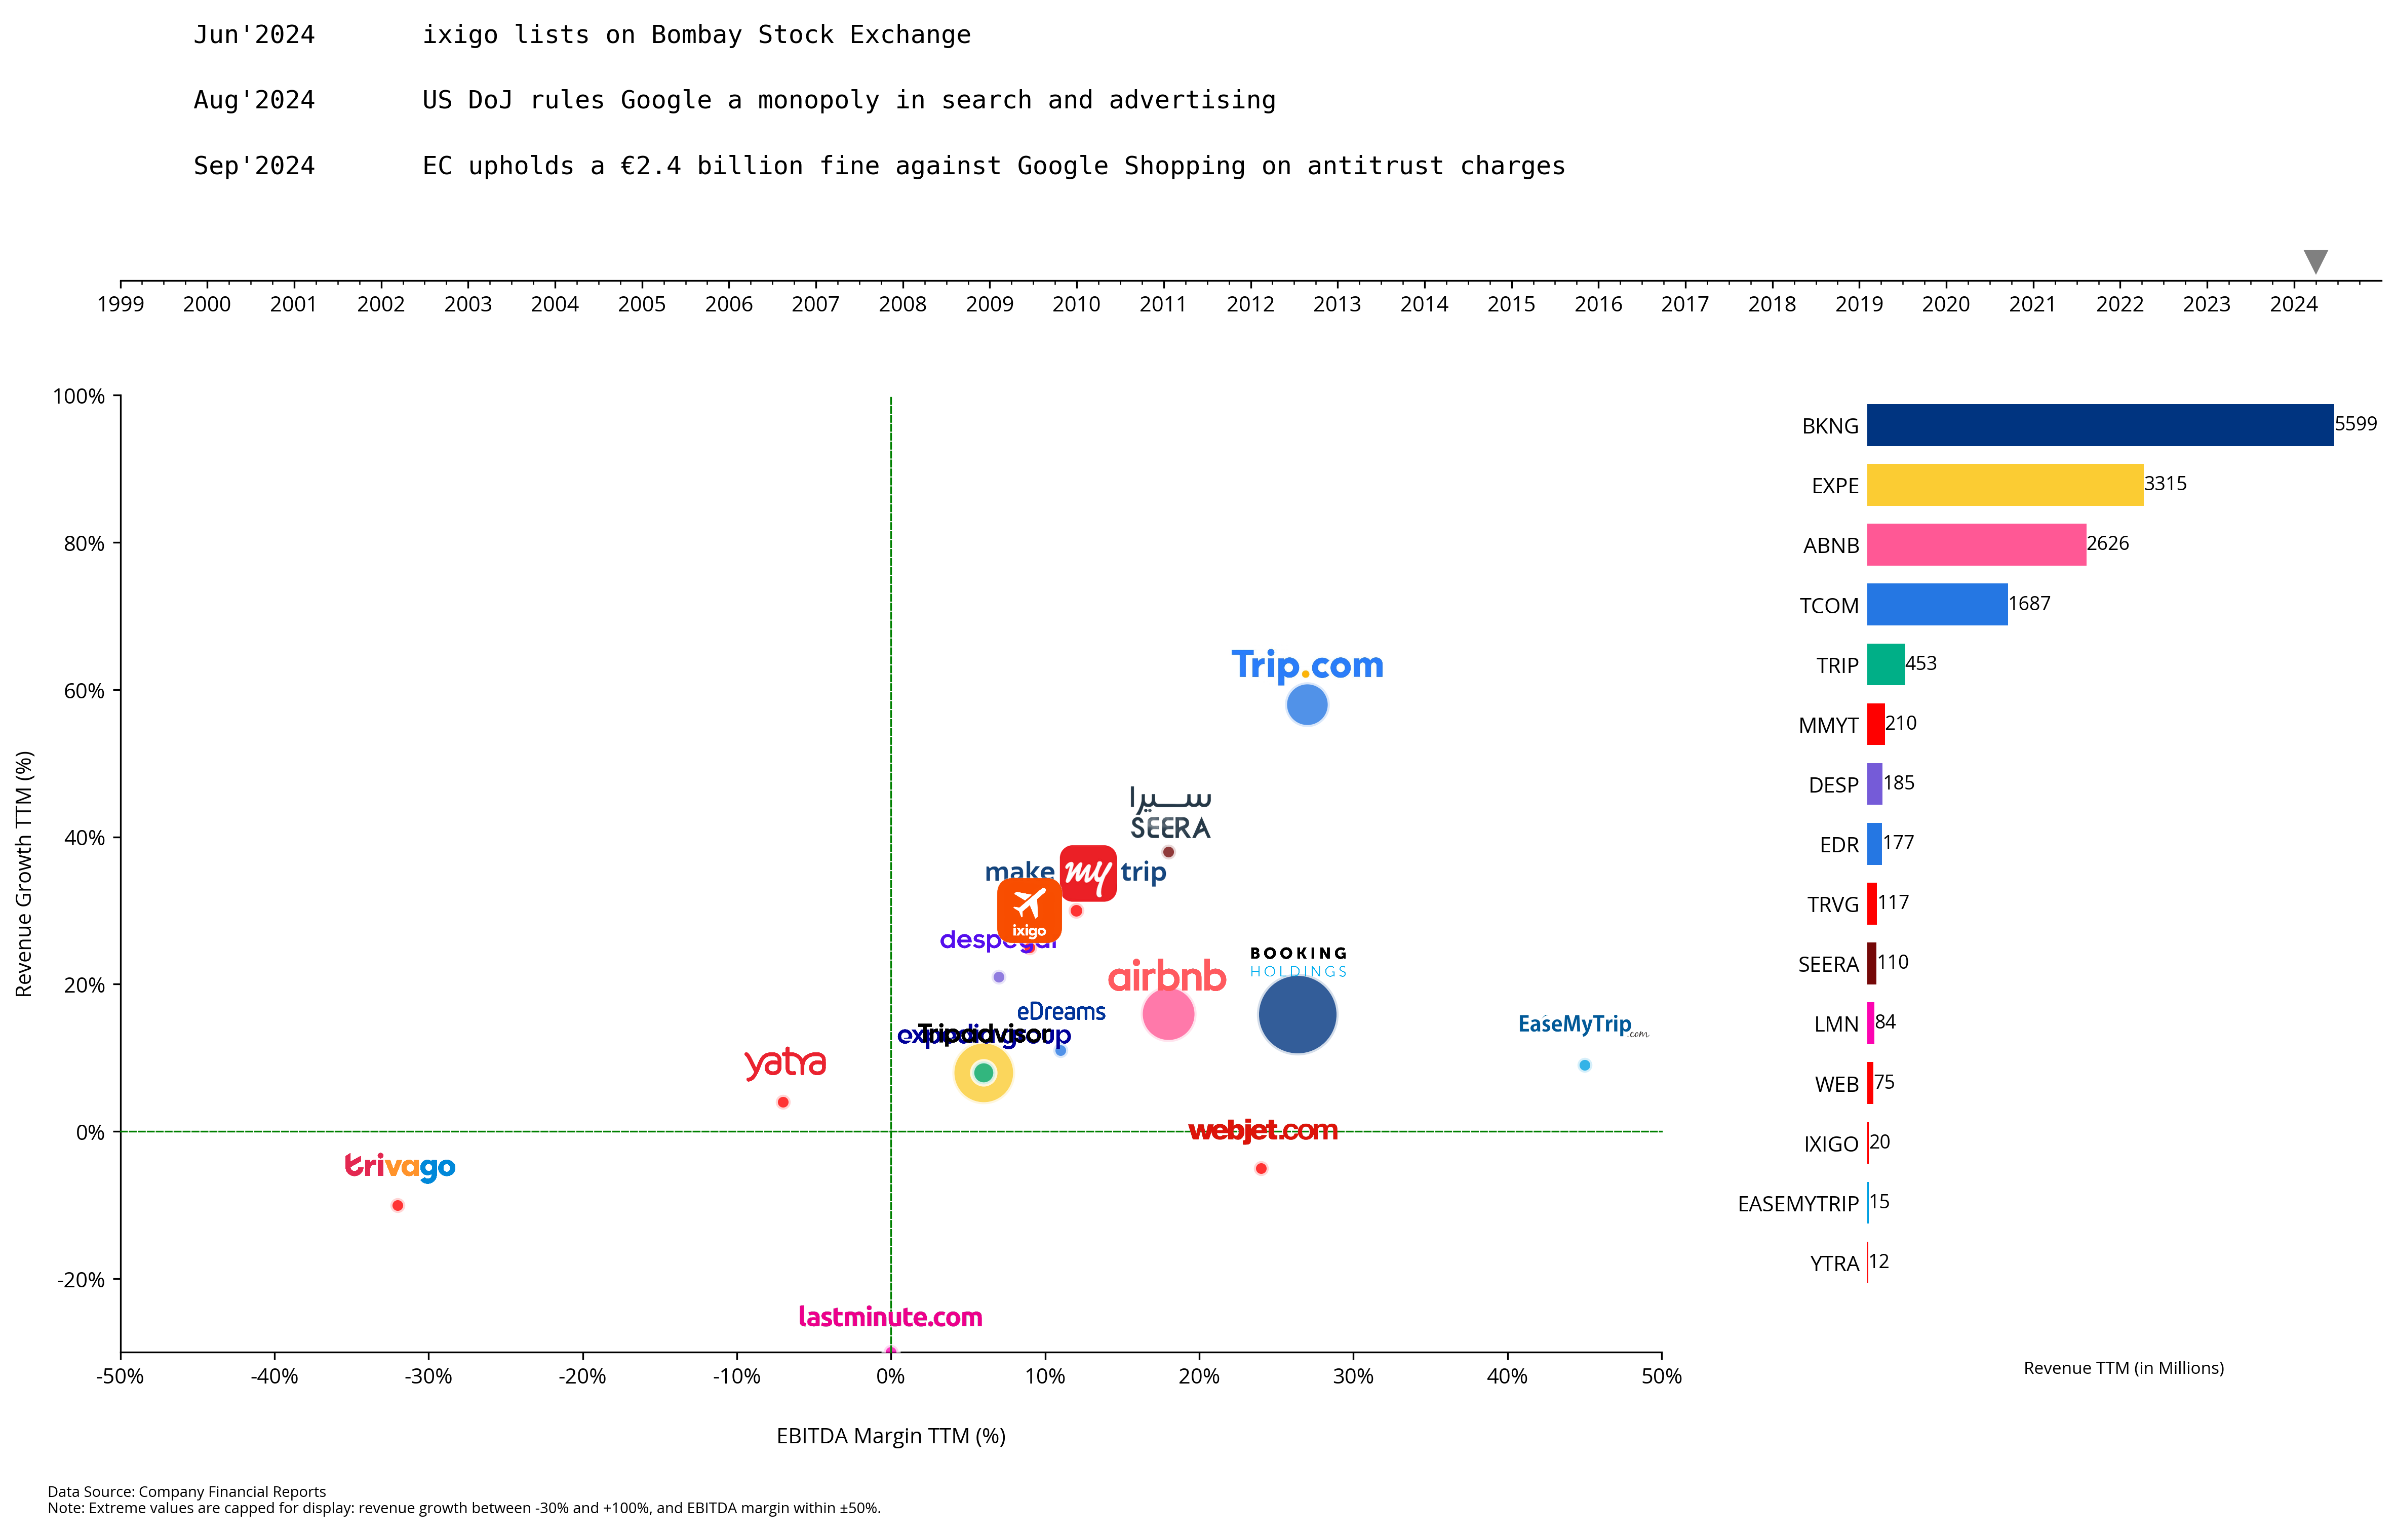

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.font_manager import FontProperties


plt.rcParams['font.family'] = 'sans-serif'


deja_vu_font = FontProperties(family='DejaVu Sans Mono')
open_sans_font = FontProperties(fname='/Users/maxxtucker/Library/Fonts/OpenSans-VariableFont_wdth,wght.ttf')  # Change to the path where Open Sans is installed

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EASEMYTRIP': '#00a0e2',
    'IXIGO': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'YTRA': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'WEB': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480',
    'OWW': '#8edbfa',
    'Travelocity': '#1d3e5c',
    "OWW'": '#8edbfa',
    "LMN'": '#fc03b1',

}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com lists on NASDAQ", None),
    (1999.92, "Nov'1999 Expedia lists on NASDAQ", None),
    (2000.25, "Mar'2000 Lastminute.com lists on LSE", None),
    (2000.25, "Mar'2000 Sabre merges Travelocity with Preview Travel, owns 70%", None),
    (2000.25, "Mar'2000 Dot-com bubble. NASDAQ peaks before falling 78% by Oct'2002", None),
    (2000.42, "May'2000 Webjet lists on ASX", None),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2001.50, "Jun'2001 Expedia acquires Hotels.com", None),
    (2001.75, "Sep'2001 9/11 Terrorist attack. 20% cutback in air capacity in North America", None),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip lists on NASDAQ", None),
    (2003.92, "Dec'2003 Orbitz lists on NYSE", None),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels for $160mil", None),
    (2005.42, "May'2005 Sabre-owned Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com for $133mil merging it with Active Hotels", None),
    (2006.67, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.25, "Mar'2007 Sabre Holdings taken private by TPG & Silver Lake Partners", None),
    (2007.58, "Jul'2007 Orbitz lists on NYSE for the second time", None),
    (2008.08, "Jan'2008 The US housing bubble leads to the Great Recession (2008-2009)", None),
    (2010.58, "Jul'2010 ITA Software accepts $700mil acquisition bid by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip lists on NASDAQ", None),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.50, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", None),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor, listing it on NASDAQ", None),
    (2012.33, "Apr'2012 Al Tayyar Travel lists on Saudi Stock Exchange", None),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", None),
    (2012.92, "Dec'2012 Expedia Group acquires 62% of Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak for $1.8bn", None),
    (2014.25, "Apr'2014 eDreams ODIGEO lists on Madrid Stock Exchange", None),
    (2014.25, "Apr'2014 Bravofly Rumbo lists on SIX Swiss Exchange", None),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.08, "Feb'2015 Expedia Group acquires Orbitz for $1.6bn & Travelocity for $280mil", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.83, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Nov'2015 Expedia Group acquires HomeAway and VRBO for $3.9bn", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.83, "Oct'2016 Yatra lists on NASDAQ", None),
    (2016.92, "Dec'2016 Trivago lists on NASDAQ. Expedia maintains majority ownership", None),
    (2017.50, "Jun'2017 CVC Capital Partners acquires Etraveli for €508mil", None),
    (2017.50, "Jun'2017 Booking.com pulls out of Trivago. Trivago shares lose 80% in the next 12 months", None),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar lists on NASDAQ", None),
    (2018.08, "Feb'2018 The Priceline Group rebrands to Booking Holdings", None),
    (2019.25, "Mar'2019 Airbnb acquires HotelTonight for $400m", None),
    (2019.33, "Apr'2019 Al Tayyar Travel rebrands as SEERA Group", None),
    (2019.42, "May'2019 Google consolidates Flights, Hotel Finder & Trips products under one interface", None),
    (2019.67, "Aug'2019 Google sunsets Trips app", None),
    (2019.75, "Sep'2019 Ctrip rebrands as Trip.com Group", None),
    (2020.08, "Feb'2020 Start of COVID-19 pandemic. Severe travel restrictions worldwide", None),
    (2020.92, "Dec'2020 Airbnb lists on NASDAQ", None),
    (2021.25, "Mar'2021 EaseMyTrip lists on Bombay Stock Exchange", None),
    (2021.92, "Nov'2021 Etraveli Group accepts Booking Holdings' takeover bid for €1.6bn", None),
    (2023.75, "Sep'2023 EC blocks Booking Holdings-Etraveli merger", None),
    (2024.00, "Jun'2024 ixigo lists on Bombay Stock Exchange", None),
    (2024.10, "Aug'2024 US DoJ rules Google a monopoly in search and advertising", None),
    (2024.20, "Sep'2024 EC upholds a €2.4 billion fine against Google Shopping on antitrust charges", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.15, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    
    for i, event in enumerate(events):
        # Split the event into date and description
        event_text, flag_path = event[1], event[2]
        
        # Format the date and event description for alignment (15 characters for date)
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y
        
        # Add the event description text with DejaVu Sans Mono font
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, 
                 color="black", fig=fig, fontproperties=deja_vu_font)  # Use the DejaVu font here

        # Add the flag image if it exists
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)




def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()

    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)

    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    # Set the x-ticks (years) on the timeline to use Open Sans font
# Set the font and size for x-axis tick labels using tick_params
    ax_timeline.tick_params(axis='x', which='major', labelsize=10)
    for label in ax_timeline.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    ax_timeline.tick_params(axis='x', which='both', labelsize=10)

    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

   

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 50 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)

        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    # Set the font and size for x-axis and y-axis tick labels using tick_params
    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)

    for label in ax.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(open_sans_font)

    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)
    

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    # Set the tick labels on the secondary x-axis and y-axis to use Open Sans font
    # Secondary axes (ax2_x and ax2_y)
    for label in ax2_x.get_xticklabels():
        label.set_fontproperties(open_sans_font)
    for label in ax2_y.get_yticklabels():
        label.set_fontproperties(open_sans_font)




    # Set axis labels using Open Sans font
    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140, fontproperties=open_sans_font)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410, fontproperties=open_sans_font)


    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data Source: <Company Financial Reports>", ha='left', va='bottom', fontsize=7, color='black', 
         highlight_textprops=[{'fontweight':'bold'}], fig=fig, fontproperties=open_sans_font)

    fig_text(0.1, 0.01, "Note: <Extreme values are capped for display: revenue growth between -30% and +100%, and EBITDA margin within ±50%.>", 
            ha='left', va='bottom', fontsize=7, color='black', highlight_textprops=[{'fontweight':'bold'}], fig=fig, fontproperties=open_sans_font)


    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)

    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Limit the number of bars to display
    max_bars = 16

    # Set a constant height for the bars
    bar_height = 0.7

    # Filter data for companies with revenue > 0
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()

    # Sort the data by revenue in descending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)

    # Get the number of companies to display
    num_companies = min(len(sorted_data), max_bars)

    # Get the data for the top companies
    top_companies = sorted_data.head(num_companies)

    # Reverse the y_positions so that the highest revenue is at the top
    y_positions = np.arange(num_companies)

    # Invert y_positions to start bars from the top
    y_positions = y_positions[::-1]

    # Map company names to colors
    bar_colors = top_companies['Company'].map(color_dict)

    # Create horizontal bar chart
    bars = ax_barchart.barh(
        y_positions,
        top_companies['Revenue'],
        color=bar_colors,
        height=bar_height
    )

    # Set y-axis limits
    ax_barchart.set_ylim(-0.5, max_bars - 0.5)

    # Add company names as y-tick labels
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'], fontproperties=open_sans_font)

    # Invert y-axis to have highest revenue at the top
    ax_barchart.invert_yaxis()

    # Add revenue labels to the bars
    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f'{int(width)}',
                va='center',
                ha='left',
                fontsize=9,
                fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
            )

    # Adjust aesthetics
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8, fontproperties=open_sans_font)

    return dots_and_logos + [ax_timeline, ax_barchart]


# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()




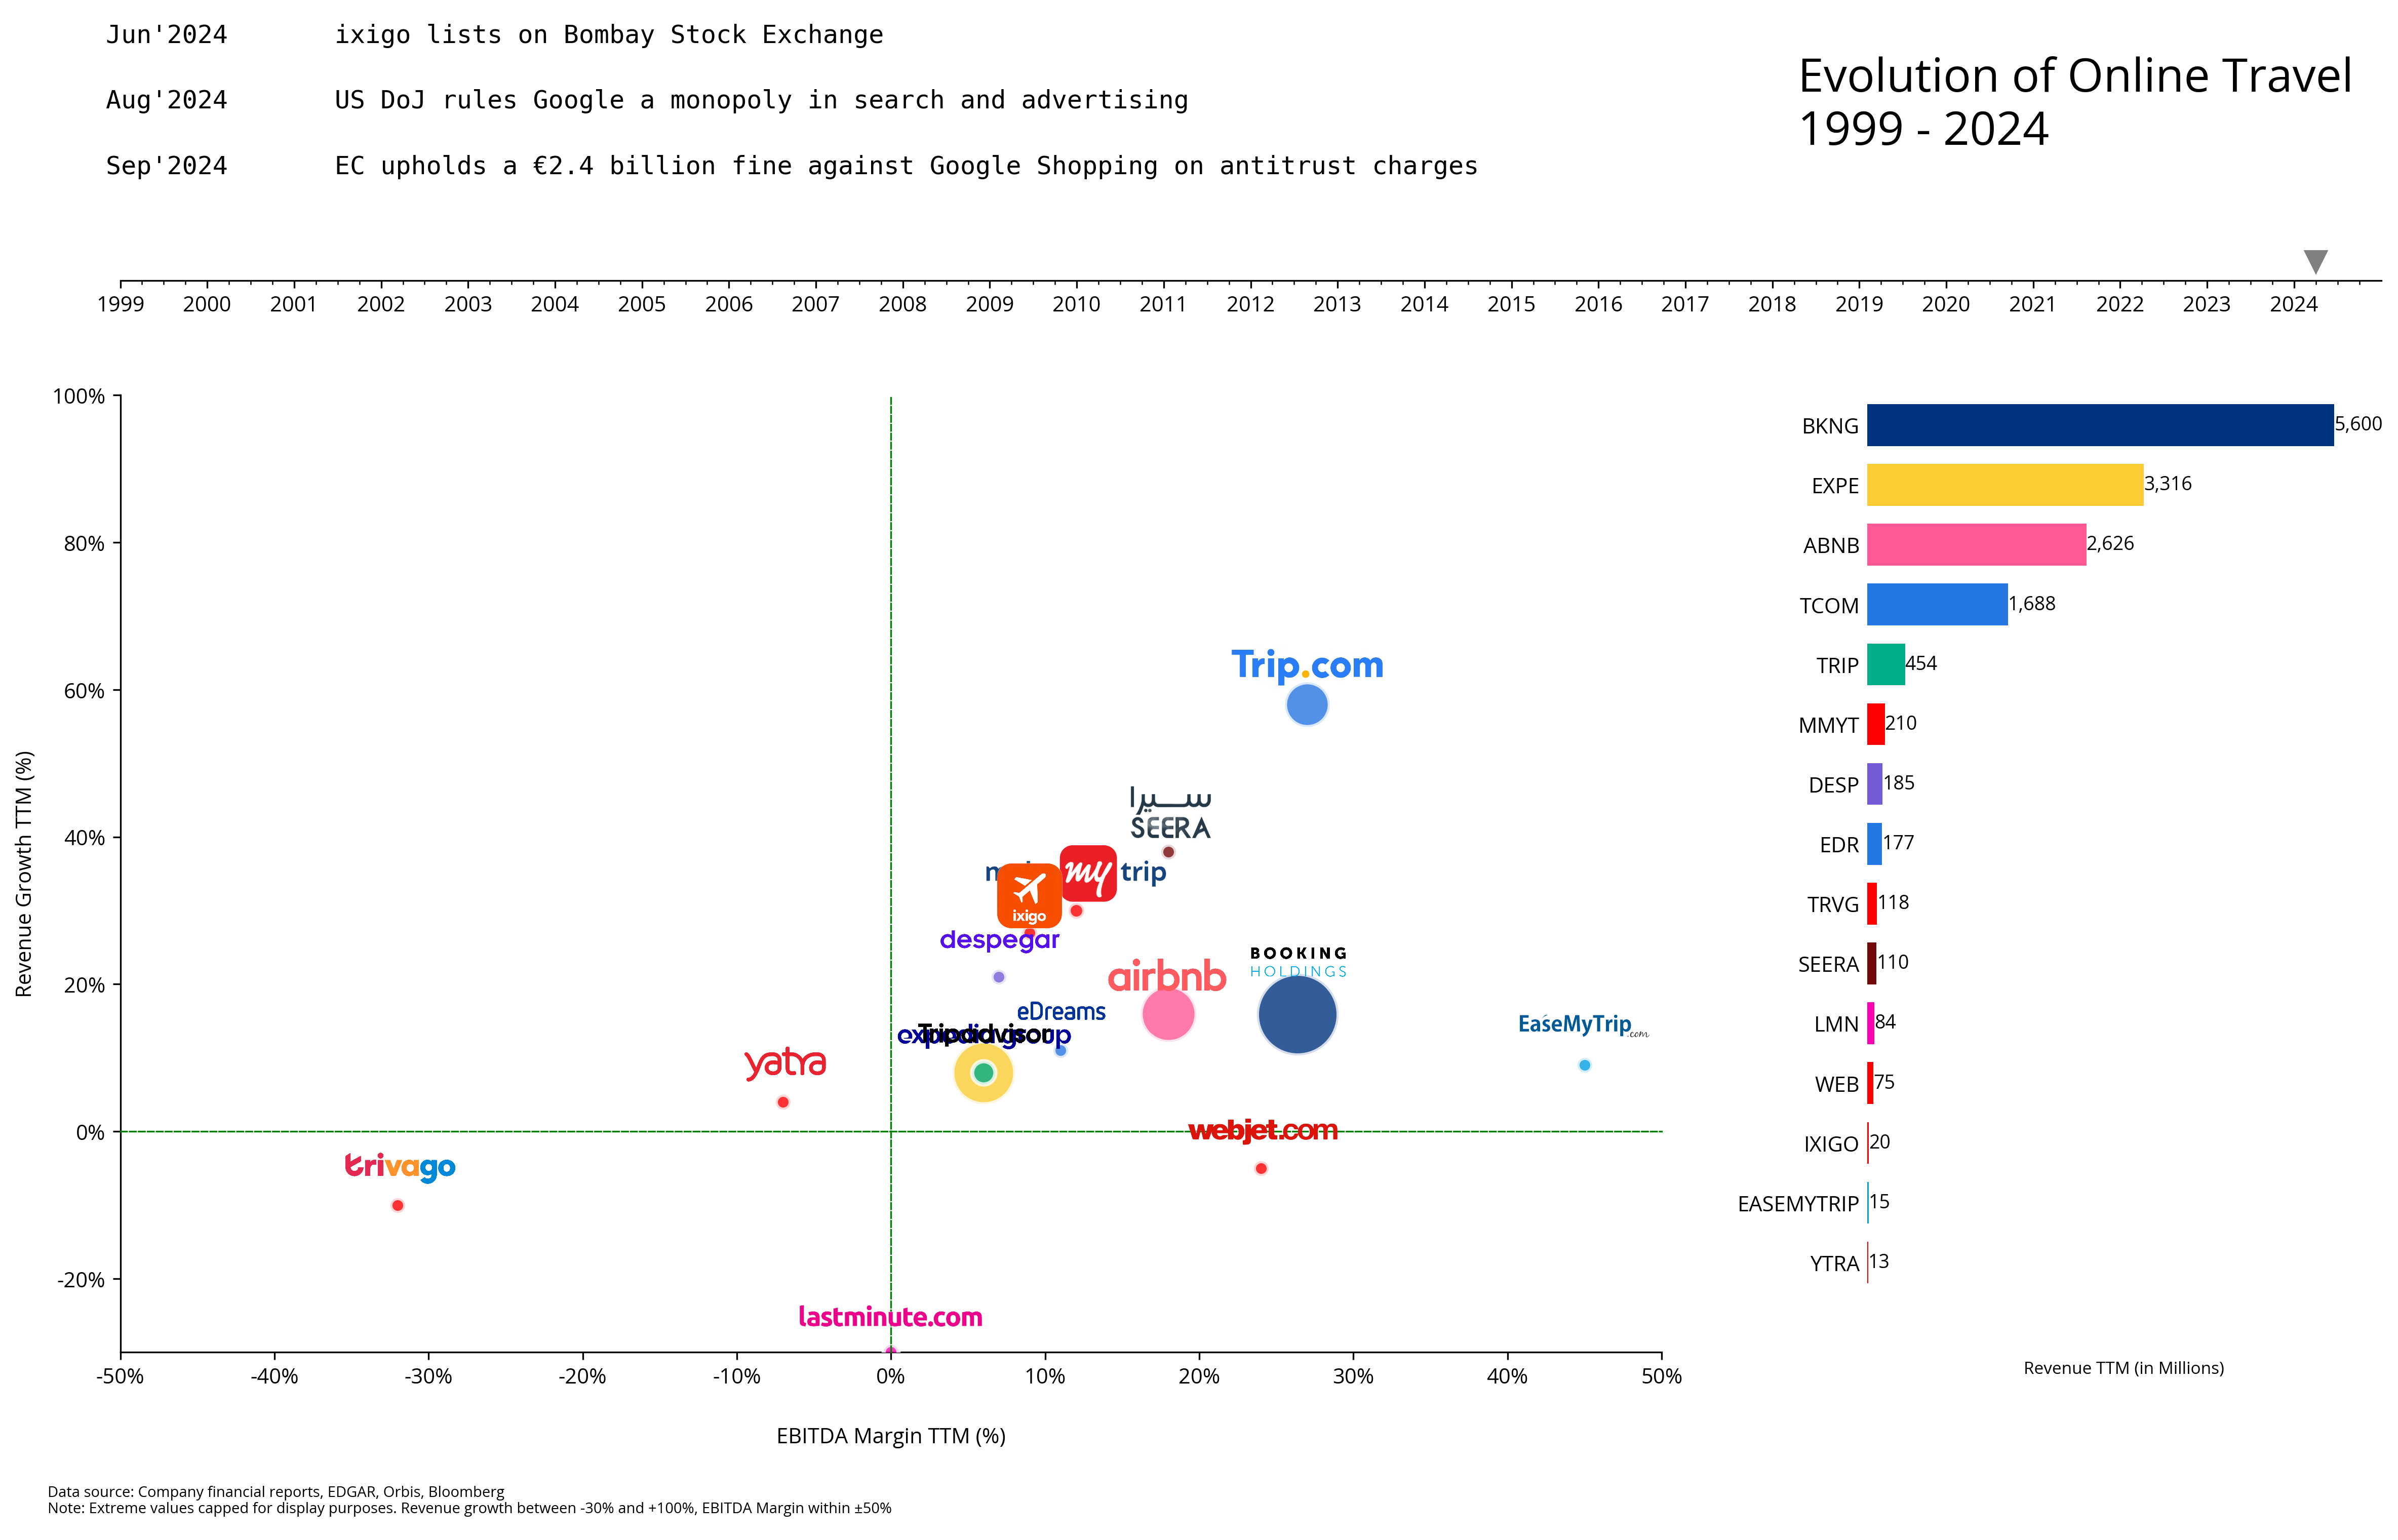

In [29]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.font_manager import FontProperties


plt.rcParams['font.family'] = 'sans-serif'


deja_vu_font = FontProperties(family='DejaVu Sans Mono')
open_sans_font = FontProperties(fname='/Users/maxxtucker/Library/Fonts/OpenSans-VariableFont_wdth,wght.ttf')  # Change to the path where Open Sans is installed

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EASEMYTRIP': '#00a0e2',
    'IXIGO': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'YTRA': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'Webjet': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480',
    'OWW': '#8edbfa',
    'Travelocity': '#1d3e5c',
    ' OWW': '#8edbfa',
    ' LMN': '#fc03b1',

}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com lists on NASDAQ", None),
    (1999.92, "Nov'1999 Expedia lists on NASDAQ", None),
    (2000.25, "Mar'2000 Lastminute.com lists on LSE", None),
    (2000.25, "Mar'2000 Sabre merges Travelocity with Preview Travel, owns 70%", None),
    (2000.25, "Mar'2000 Dot-com bubble. NASDAQ peaks before falling 78% by Oct'2002", None),
    (2000.42, "May'2000 Webjet lists on ASX", None),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2001.50, "Jun'2001 Expedia acquires Hotels.com", None),
    (2001.75, "Sep'2001 9/11 Terrorist attack. 20% cutback in air capacity in North America", None),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip lists on NASDAQ", None),
    (2003.92, "Dec'2003 Orbitz lists on NYSE", None),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels for $160mil", None),
    (2005.42, "May'2005 Sabre-owned Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com for $133mil merging it with Active Hotels", None),
    (2006.67, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.25, "Mar'2007 Sabre Holdings taken private by TPG & Silver Lake Partners", None),
    (2007.58, "Jul'2007 Orbitz lists on NYSE for the second time", None),
    (2008.08, "Jan'2008 The US housing bubble leads to the Great Recession (2008-2009)", None),
    (2010.58, "Jul'2010 ITA Software accepts $700mil acquisition bid by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip lists on NASDAQ", None),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.50, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", None),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor, listing it on NASDAQ", None),
    (2012.33, "Apr'2012 Al Tayyar Travel lists on Saudi Stock Exchange", None),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", None),
    (2012.92, "Dec'2012 Expedia Group acquires 62% of Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak for $1.8bn", None),
    (2014.25, "Apr'2014 eDreams ODIGEO lists on Madrid Stock Exchange", None),
    (2014.25, "Apr'2014 Bravofly Rumbo lists on SIX Swiss Exchange", None),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.08, "Feb'2015 Expedia Group acquires Orbitz for \$1.6bn & Travelocity for \$280mil", None),
    (2015.17, "Mar'2015 New CEO restructures Edreams ODIGEO CEO. Subscriptions launch in subscriptions in 2017", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.83, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Nov'2015 Expedia Group acquires HomeAway and VRBO for $3.9bn", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.83, "Oct'2016 Yatra lists on NASDAQ", None),
    (2016.92, "Dec'2016 Trivago lists on NASDAQ. Expedia maintains majority ownership", None),
    (2017.50, "Jun'2017 CVC Capital Partners acquires Etraveli for €508mil", None),
    (2017.50, "Jun'2017 Booking.com pulls out of Trivago. Trivago shares lose 80% in the next 12 months", None),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar lists on NASDAQ", None),
    (2018.08, "Feb'2018 The Priceline Group rebrands to Booking Holdings", None),
    (2018.83, "Nov'2018 Webjet acquires Destinations of the World boosting its bedbank business", None),
    (2019.25, "Mar'2019 Airbnb acquires HotelTonight for $400m", None),
    (2019.33, "Apr'2019 Al Tayyar Travel rebrands as SEERA Group", None),
    (2019.42, "May'2019 Google consolidates Flights, Hotel Finder & Trips products under one interface", None),
    (2019.67, "Aug'2019 Google sunsets Trips app", None),
    (2019.75, "Sep'2019 Ctrip rebrands as Trip.com Group", None),
    (2020.08, "Feb'2020 Start of COVID-19 pandemic. Severe travel restrictions worldwide", None),
    (2020.92, "Dec'2020 Airbnb lists on NASDAQ", None),
    (2021.25, "Mar'2021 EaseMyTrip lists on Bombay Stock Exchange", None),
    (2021.92, "Nov'2021 Etraveli Group accepts Booking Holdings' takeover bid for €1.6bn", None),
    (2023.75, "Sep'2023 EC blocks Booking Holdings-Etraveli merger", None),
    (2024.00, "Jun'2024 ixigo lists on Bombay Stock Exchange", None),
    (2024.10, "Aug'2024 US DoJ rules Google a monopoly in search and advertising", None),
    (2024.20, "Sep'2024 EC upholds a €2.4 billion fine against Google Shopping on antitrust charges", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.12, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    
    for i, event in enumerate(events):
        # Split the event into date and description
        event_text, flag_path = event[1], event[2]
        
        # Format the date and event description for alignment (15 characters for date)
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y
        
        # Add the event description text with DejaVu Sans Mono font
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, 
                 color="black", fig=fig, fontproperties=deja_vu_font)  # Use the DejaVu font here

        # Add the flag image if it exists
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)




def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()

    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)

    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    # Set the x-ticks (years) on the timeline to use Open Sans font
# Set the font and size for x-axis tick labels using tick_params
    ax_timeline.tick_params(axis='x', which='major', labelsize=10)
    for label in ax_timeline.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    ax_timeline.tick_params(axis='x', which='both', labelsize=10)

    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

   

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 50 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)

        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    # Set the font and size for x-axis and y-axis tick labels using tick_params
    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)

    for label in ax.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(open_sans_font)

    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)
    

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    # Set the tick labels on the secondary x-axis and y-axis to use Open Sans font
    # Secondary axes (ax2_x and ax2_y)
    for label in ax2_x.get_xticklabels():
        label.set_fontproperties(open_sans_font)
    for label in ax2_y.get_yticklabels():
        label.set_fontproperties(open_sans_font)




    # Set axis labels using Open Sans font
    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140, fontproperties=open_sans_font)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410, fontproperties=open_sans_font)


    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data source: Company financial reports, EDGAR, Orbis, Bloomberg", ha='left', va='bottom', fontsize=7, color='black', 
        fig=fig, fontproperties=open_sans_font)

    fig_text(0.1, 0.01, "Note: Extreme values capped for display purposes. Revenue growth between -30% and +100%, EBITDA Margin within ±50%", 
            ha='left', va='bottom', fontsize=7, color='black', fig=fig, fontproperties=open_sans_font)


    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)

    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Limit the number of bars to display
    max_bars = 16

    # Set a constant height for the bars
    bar_height = 0.7

    # Filter data for companies with revenue > 0
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()

    # Sort the data by revenue in descending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)

    # Get the number of companies to display
    num_companies = min(len(sorted_data), max_bars)

    # Get the data for the top companies
    top_companies = sorted_data.head(num_companies)

    # Reverse the y_positions so that the highest revenue is at the top
    y_positions = np.arange(num_companies)

    # Invert y_positions to start bars from the top
    y_positions = y_positions[::-1]

    # Map company names to colors
    bar_colors = top_companies['Company'].map(color_dict)

    # Create horizontal bar chart
    bars = ax_barchart.barh(
        y_positions,
        top_companies['Revenue'],
        color=bar_colors,
        height=bar_height
    )

    # Set y-axis limits
    ax_barchart.set_ylim(-0.5, max_bars - 0.5)

    # Add company names as y-tick labels
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'], fontproperties=open_sans_font)

    # Invert y-axis to have highest revenue at the top
    ax_barchart.invert_yaxis()

    # Add revenue labels to the bars
    # for bar, revenue in zip(bars, top_companies['Revenue']):
    #     width = bar.get_width()
    #     if width > 0:
    #         ax_barchart.text(
    #             width,
    #             bar.get_y() + bar.get_height() / 2,
    #             f'{int(width)}',
    #             va='center',
    #             ha='left',
    #             fontsize=9,
    #             fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
    #         )
    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',  # Format with commas for thousands and no decimals
                va='center',
                ha='left',
                fontsize=9,
                fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
            )

    # Adjust aesthetics
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8, fontproperties=open_sans_font)

    return dots_and_logos + [ax_timeline, ax_barchart]


# Add a two-line title, aligned to the right
fig.suptitle("Evolution of Online Travel\n1999 - 2024",
             fontsize=22, fontproperties=open_sans_font, x=0.70, y=0.90, ha='left')  # 'x' and 'ha' control horizontal alignment



# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()




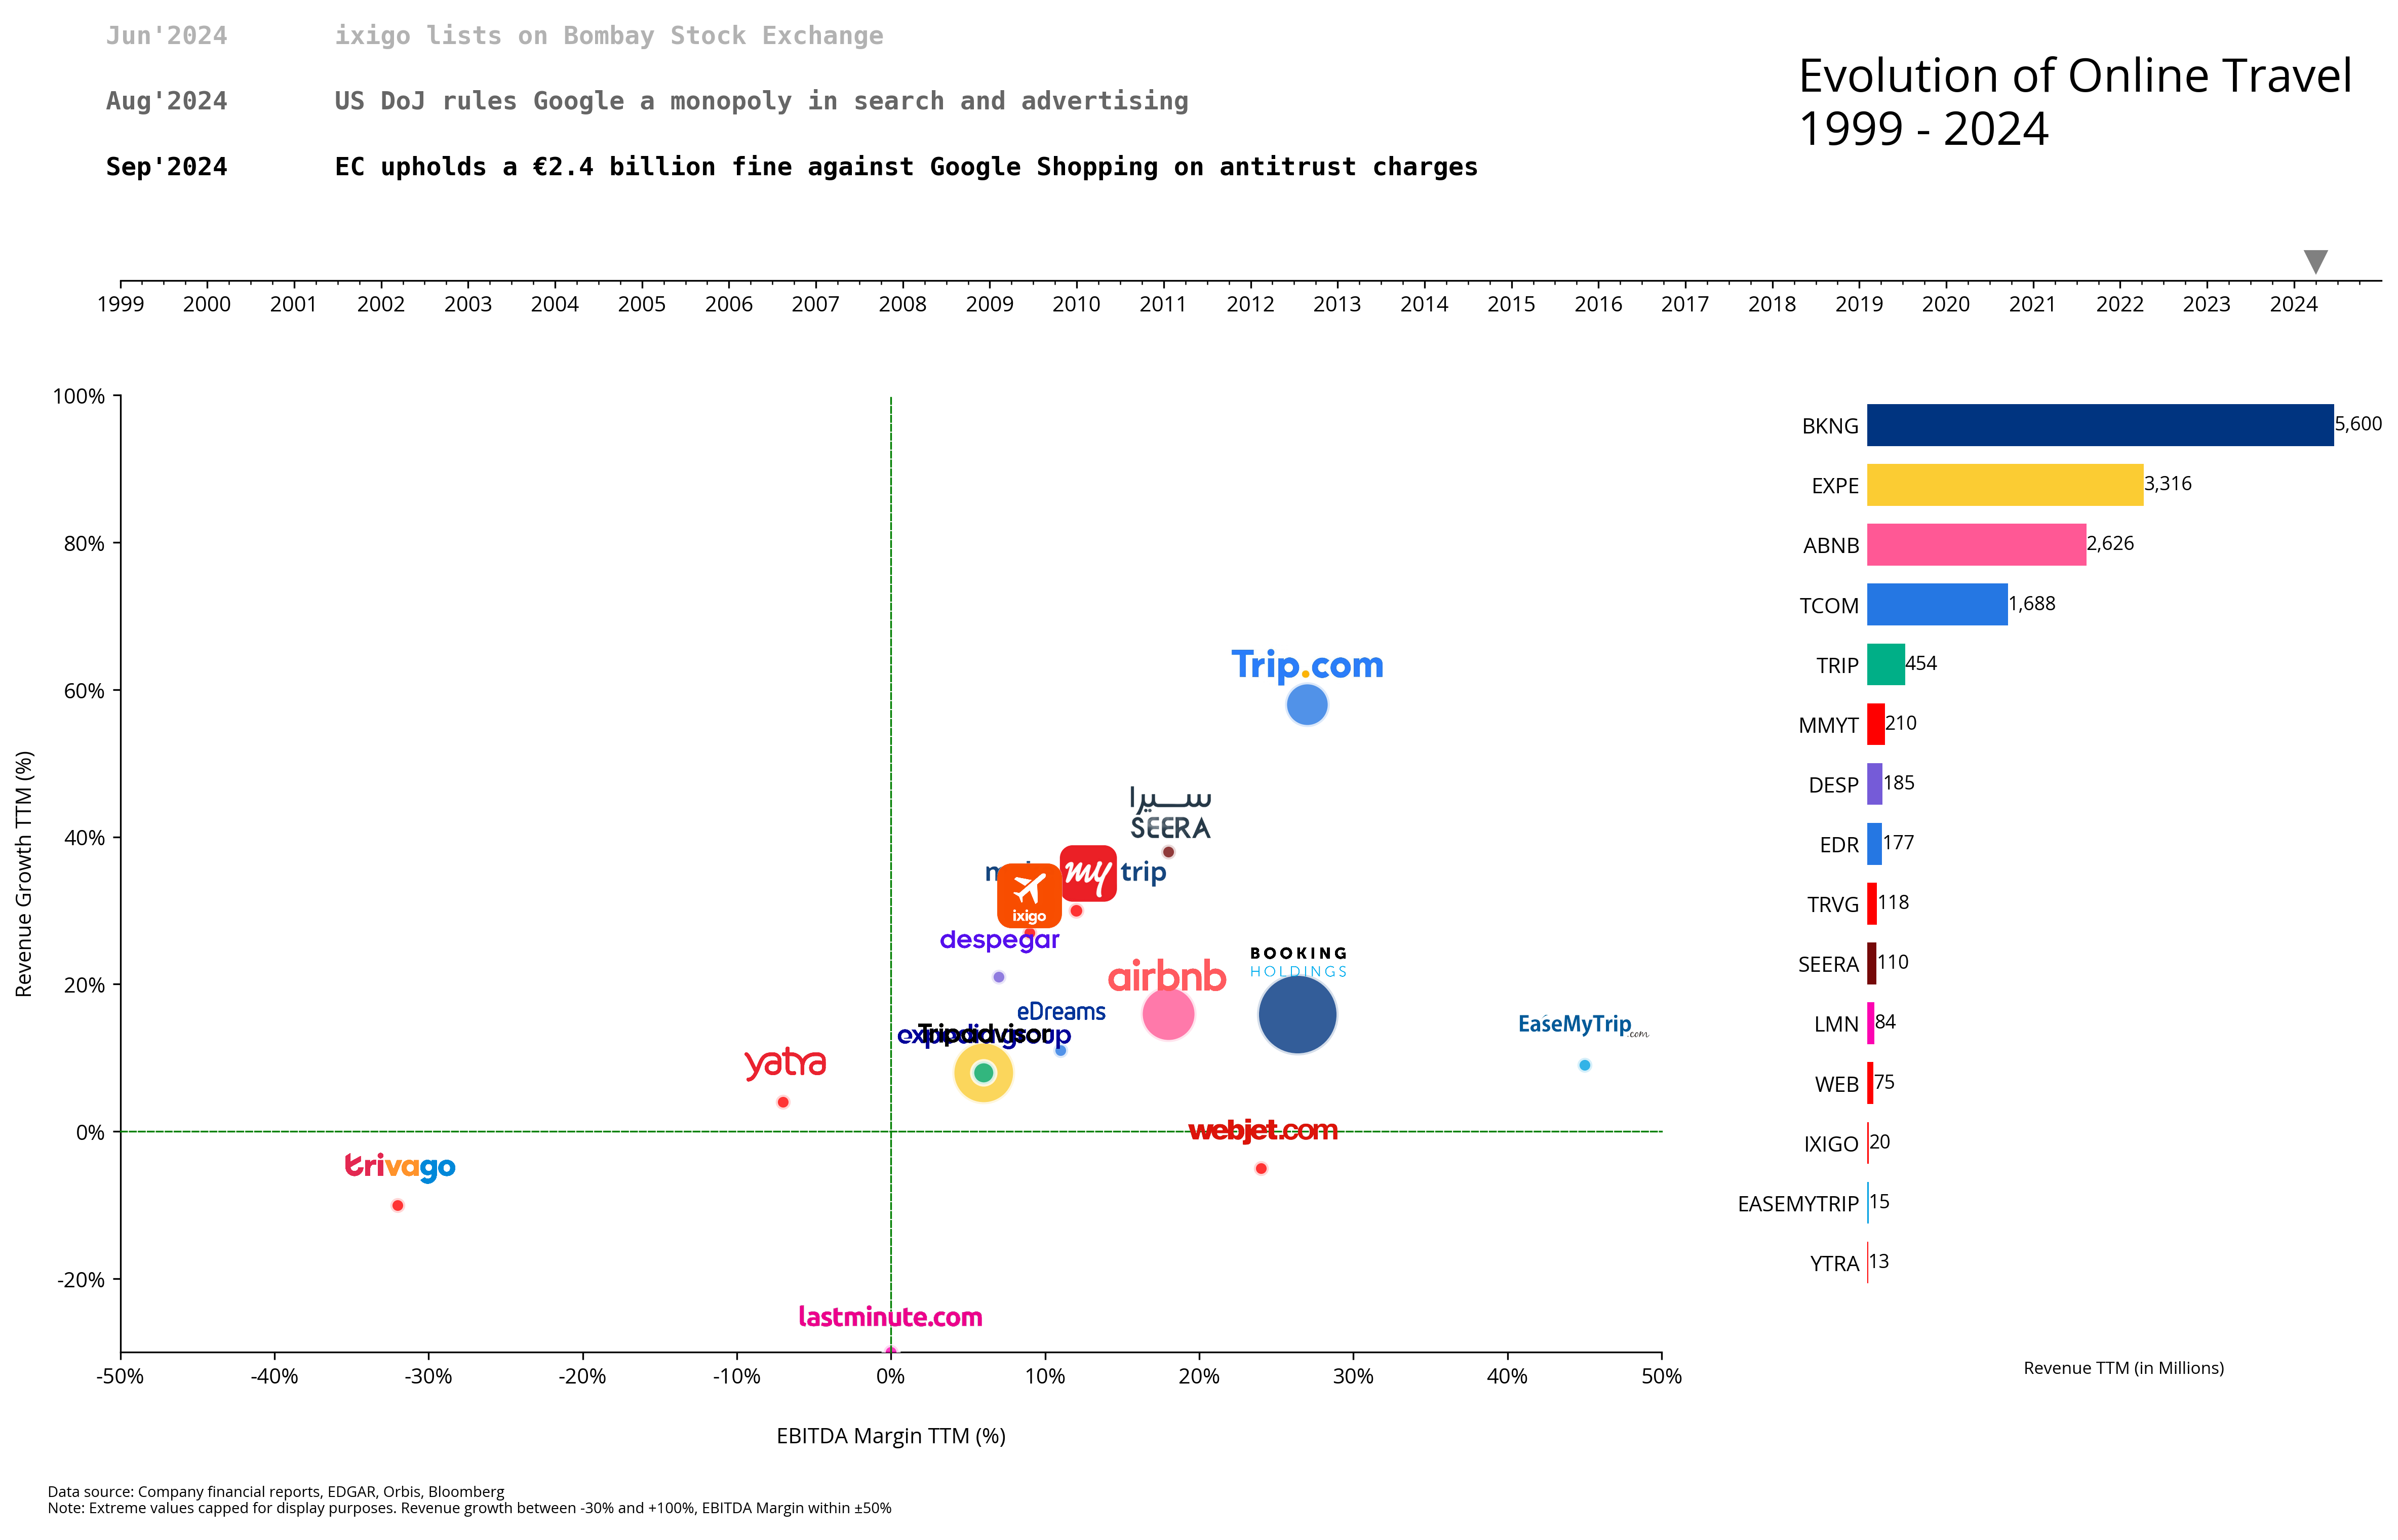

In [35]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.font_manager import FontProperties


plt.rcParams['font.family'] = 'sans-serif'


deja_vu_font = FontProperties(family='DejaVu Sans Mono')
open_sans_font = FontProperties(fname='/Users/maxxtucker/Library/Fonts/OpenSans-VariableFont_wdth,wght.ttf')  # Change to the path where Open Sans is installed

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EASEMYTRIP': '#00a0e2',
    'IXIGO': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'YTRA': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'WEB': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480',
    'OWW': '#8edbfa',
    'Travelocity': '#1d3e5c',
    ' OWW': '#8edbfa',
    ' LMN': '#fc03b1',

}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com lists on NASDAQ", None),
    (1999.92, "Nov'1999 Expedia lists on NASDAQ", None),
    (2000.25, "Mar'2000 Lastminute.com lists on LSE", None),
    (2000.25, "Mar'2000 Sabre merges Travelocity with Preview Travel, owns 70%", None),
    (2000.25, "Mar'2000 Dot-com bubble. NASDAQ peaks before falling 78% by Oct'2002", None),
    (2000.42, "May'2000 Webjet lists on ASX", None),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2001.50, "Jun'2001 Expedia acquires Hotels.com", None),
    (2001.75, "Sep'2001 9/11 Terrorist attack. 20% cutback in air capacity in North America", None),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip lists on NASDAQ", None),
    (2003.92, "Dec'2003 Orbitz lists on NYSE", None),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels for $160mil", None),
    (2005.42, "May'2005 Sabre-owned Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com for $133mil merging it with Active Hotels", None),
    (2006.67, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.25, "Mar'2007 Sabre Holdings taken private by TPG & Silver Lake Partners", None),
    (2007.58, "Jul'2007 Orbitz lists on NYSE for the second time", None),
    (2008.08, "Jan'2008 The US housing bubble leads to the Great Recession (2008-2009)", None),
    (2010.58, "Jul'2010 ITA Software accepts $700mil acquisition bid by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip lists on NASDAQ", None),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.50, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", None),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor, listing it on NASDAQ", None),
    (2012.33, "Apr'2012 Al Tayyar Travel lists on Saudi Stock Exchange", None),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", None),
    (2012.92, "Dec'2012 Expedia Group acquires 62% of Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak for $1.8bn", None),
    (2014.25, "Apr'2014 eDreams ODIGEO lists on Madrid Stock Exchange", None),
    (2014.25, "Apr'2014 Bravofly Rumbo lists on SIX Swiss Exchange", None),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.08, "Feb'2015 Expedia Group acquires Orbitz for \$1.6bn & Travelocity for \$280mil", None),
    (2015.17, "Mar'2015 New CEO restructures Edreams ODIGEO. Subscriptions launch in 2017", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.83, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Nov'2015 Expedia Group acquires HomeAway and VRBO for $3.9bn", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.83, "Oct'2016 Yatra lists on NASDAQ", None),
    (2016.92, "Dec'2016 Trivago lists on NASDAQ. Expedia maintains majority ownership", None),
    (2017.50, "Jun'2017 CVC Capital Partners acquires Etraveli for €508mil", None),
    (2017.50, "Jun'2017 Booking.com pulls out of Trivago. Trivago shares lose 80% in the next 12 months", None),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar lists on NASDAQ", None),
    (2018.08, "Feb'2018 The Priceline Group rebrands to Booking Holdings", None),
    (2018.83, "Nov'2018 Webjet acquires Destinations of the World boosting its bedbank business", None),
    (2019.25, "Mar'2019 Airbnb acquires HotelTonight for $400m", None),
    (2019.33, "Apr'2019 Al Tayyar Travel rebrands as SEERA Group", None),
    (2019.42, "May'2019 Google consolidates Flights, Hotel Finder & Trips products under one interface", None),
    (2019.67, "Aug'2019 Google sunsets Trips app", None),
    (2019.75, "Sep'2019 Ctrip rebrands as Trip.com Group", None),
    (2020.08, "Feb'2020 Start of COVID-19 pandemic. Severe travel restrictions worldwide", None),
    (2020.92, "Dec'2020 Airbnb lists on NASDAQ", None),
    (2021.25, "Mar'2021 EaseMyTrip lists on Bombay Stock Exchange", None),
    (2021.92, "Nov'2021 Etraveli Group accepts Booking Holdings' takeover bid for €1.6bn", None),
    (2023.75, "Sep'2023 EC blocks Booking Holdings-Etraveli merger", None),
    (2024.00, "Jun'2024 ixigo lists on Bombay Stock Exchange", None),
    (2024.10, "Aug'2024 US DoJ rules Google a monopoly in search and advertising", None),
    (2024.20, "Sep'2024 EC upholds a €2.4 billion fine against Google Shopping on antitrust charges", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.12, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    
    # Ensure events are available and sorted by date
    if len(events) == 0:
        return
    
    # Determine the most recent events
    most_recent_event = events[-1]
    second_most_recent_event = events[-2] if len(events) > 1 else None
    third_most_recent_event = events[-3] if len(events) > 2 else None
    
    for i, event in enumerate(events):
        # Safely unpack event: only assign flag_path if the tuple has 3 elements
        if len(event) == 3:
            event_text, flag_path = event[1], event[2]
        elif len(event) == 2:
            event_text, flag_path = event[1], None  # No flag image for this event
        else:
            continue  # Skip if the tuple doesn't have enough elements

        # Format the date and event description for alignment (15 characters for date)
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y

        # Determine the style based on the event's recency
        if event == most_recent_event:
            # Most recent event: fully bold and black
            fontweight = 'bold'
            text_alpha = 1.0
            color = "black"
        elif event == second_most_recent_event:
            # Second most recent event: slightly bold and slightly faded
            fontweight = 'semibold'
            text_alpha = 0.6
            color = "black"
        elif event == third_most_recent_event:
            # Third most recent event: normal weight and more faded
            fontweight = 'semibold'
            text_alpha = 0.3
            color = "black"
        else:
            # Older events: light gray and highly faded
            fontweight = 'normal'
            text_alpha = 0.3
            color = "lightgray"

        # Add the event description text with DejaVu Sans Mono font
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, 
                 color=color, alpha=text_alpha, fontweight=fontweight, fig=fig, fontproperties=deja_vu_font)

        # Add the flag image if it exists, with adjusted transparency
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05, alpha=text_alpha)  # Adjust alpha for fading
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)





def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()

    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)

    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    # Set the x-ticks (years) on the timeline to use Open Sans font
# Set the font and size for x-axis tick labels using tick_params
    ax_timeline.tick_params(axis='x', which='major', labelsize=10)
    for label in ax_timeline.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    ax_timeline.tick_params(axis='x', which='both', labelsize=10)

    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

   

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 50 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)

        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    # Set the font and size for x-axis and y-axis tick labels using tick_params
    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)

    for label in ax.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(open_sans_font)

    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)
    

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    # Set the tick labels on the secondary x-axis and y-axis to use Open Sans font
    # Secondary axes (ax2_x and ax2_y)
    for label in ax2_x.get_xticklabels():
        label.set_fontproperties(open_sans_font)
    for label in ax2_y.get_yticklabels():
        label.set_fontproperties(open_sans_font)




    # Set axis labels using Open Sans font
    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140, fontproperties=open_sans_font)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410, fontproperties=open_sans_font)


    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.02, "Data source: Company financial reports, EDGAR, Orbis, Bloomberg", ha='left', va='bottom', fontsize=7, color='black', 
        fig=fig, fontproperties=open_sans_font)

    fig_text(0.1, 0.01, "Note: Extreme values capped for display purposes. Revenue growth between -30% and +100%, EBITDA Margin within ±50%", 
            ha='left', va='bottom', fontsize=7, color='black', fig=fig, fontproperties=open_sans_font)


    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)

    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Limit the number of bars to display
    max_bars = 16

    # Set a constant height for the bars
    bar_height = 0.7

    # Filter data for companies with revenue > 0
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()

    # Sort the data by revenue in descending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)

    # Get the number of companies to display
    num_companies = min(len(sorted_data), max_bars)

    # Get the data for the top companies
    top_companies = sorted_data.head(num_companies)

    # Reverse the y_positions so that the highest revenue is at the top
    y_positions = np.arange(num_companies)

    # Invert y_positions to start bars from the top
    y_positions = y_positions[::-1]

    # Map company names to colors
    bar_colors = top_companies['Company'].map(color_dict)

    # Create horizontal bar chart
    bars = ax_barchart.barh(
        y_positions,
        top_companies['Revenue'],
        color=bar_colors,
        height=bar_height
    )

    # Set y-axis limits
    ax_barchart.set_ylim(-0.5, max_bars - 0.5)

    # Add company names as y-tick labels
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'], fontproperties=open_sans_font)

    # Invert y-axis to have highest revenue at the top
    ax_barchart.invert_yaxis()

    # Add revenue labels to the bars
    # for bar, revenue in zip(bars, top_companies['Revenue']):
    #     width = bar.get_width()
    #     if width > 0:
    #         ax_barchart.text(
    #             width,
    #             bar.get_y() + bar.get_height() / 2,
    #             f'{int(width)}',
    #             va='center',
    #             ha='left',
    #             fontsize=9,
    #             fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
    #         )
    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',  # Format with commas for thousands and no decimals
                va='center',
                ha='left',
                fontsize=9,
                fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
            )

    # Adjust aesthetics
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=8, fontproperties=open_sans_font)

    return dots_and_logos + [ax_timeline, ax_barchart]


# Add a two-line title, aligned to the right
fig.suptitle("Evolution of Online Travel\n1999 - 2024",
             fontsize=22, fontproperties=open_sans_font, x=0.70, y=0.90, ha='left')  # 'x' and 'ha' control horizontal alignment



# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()




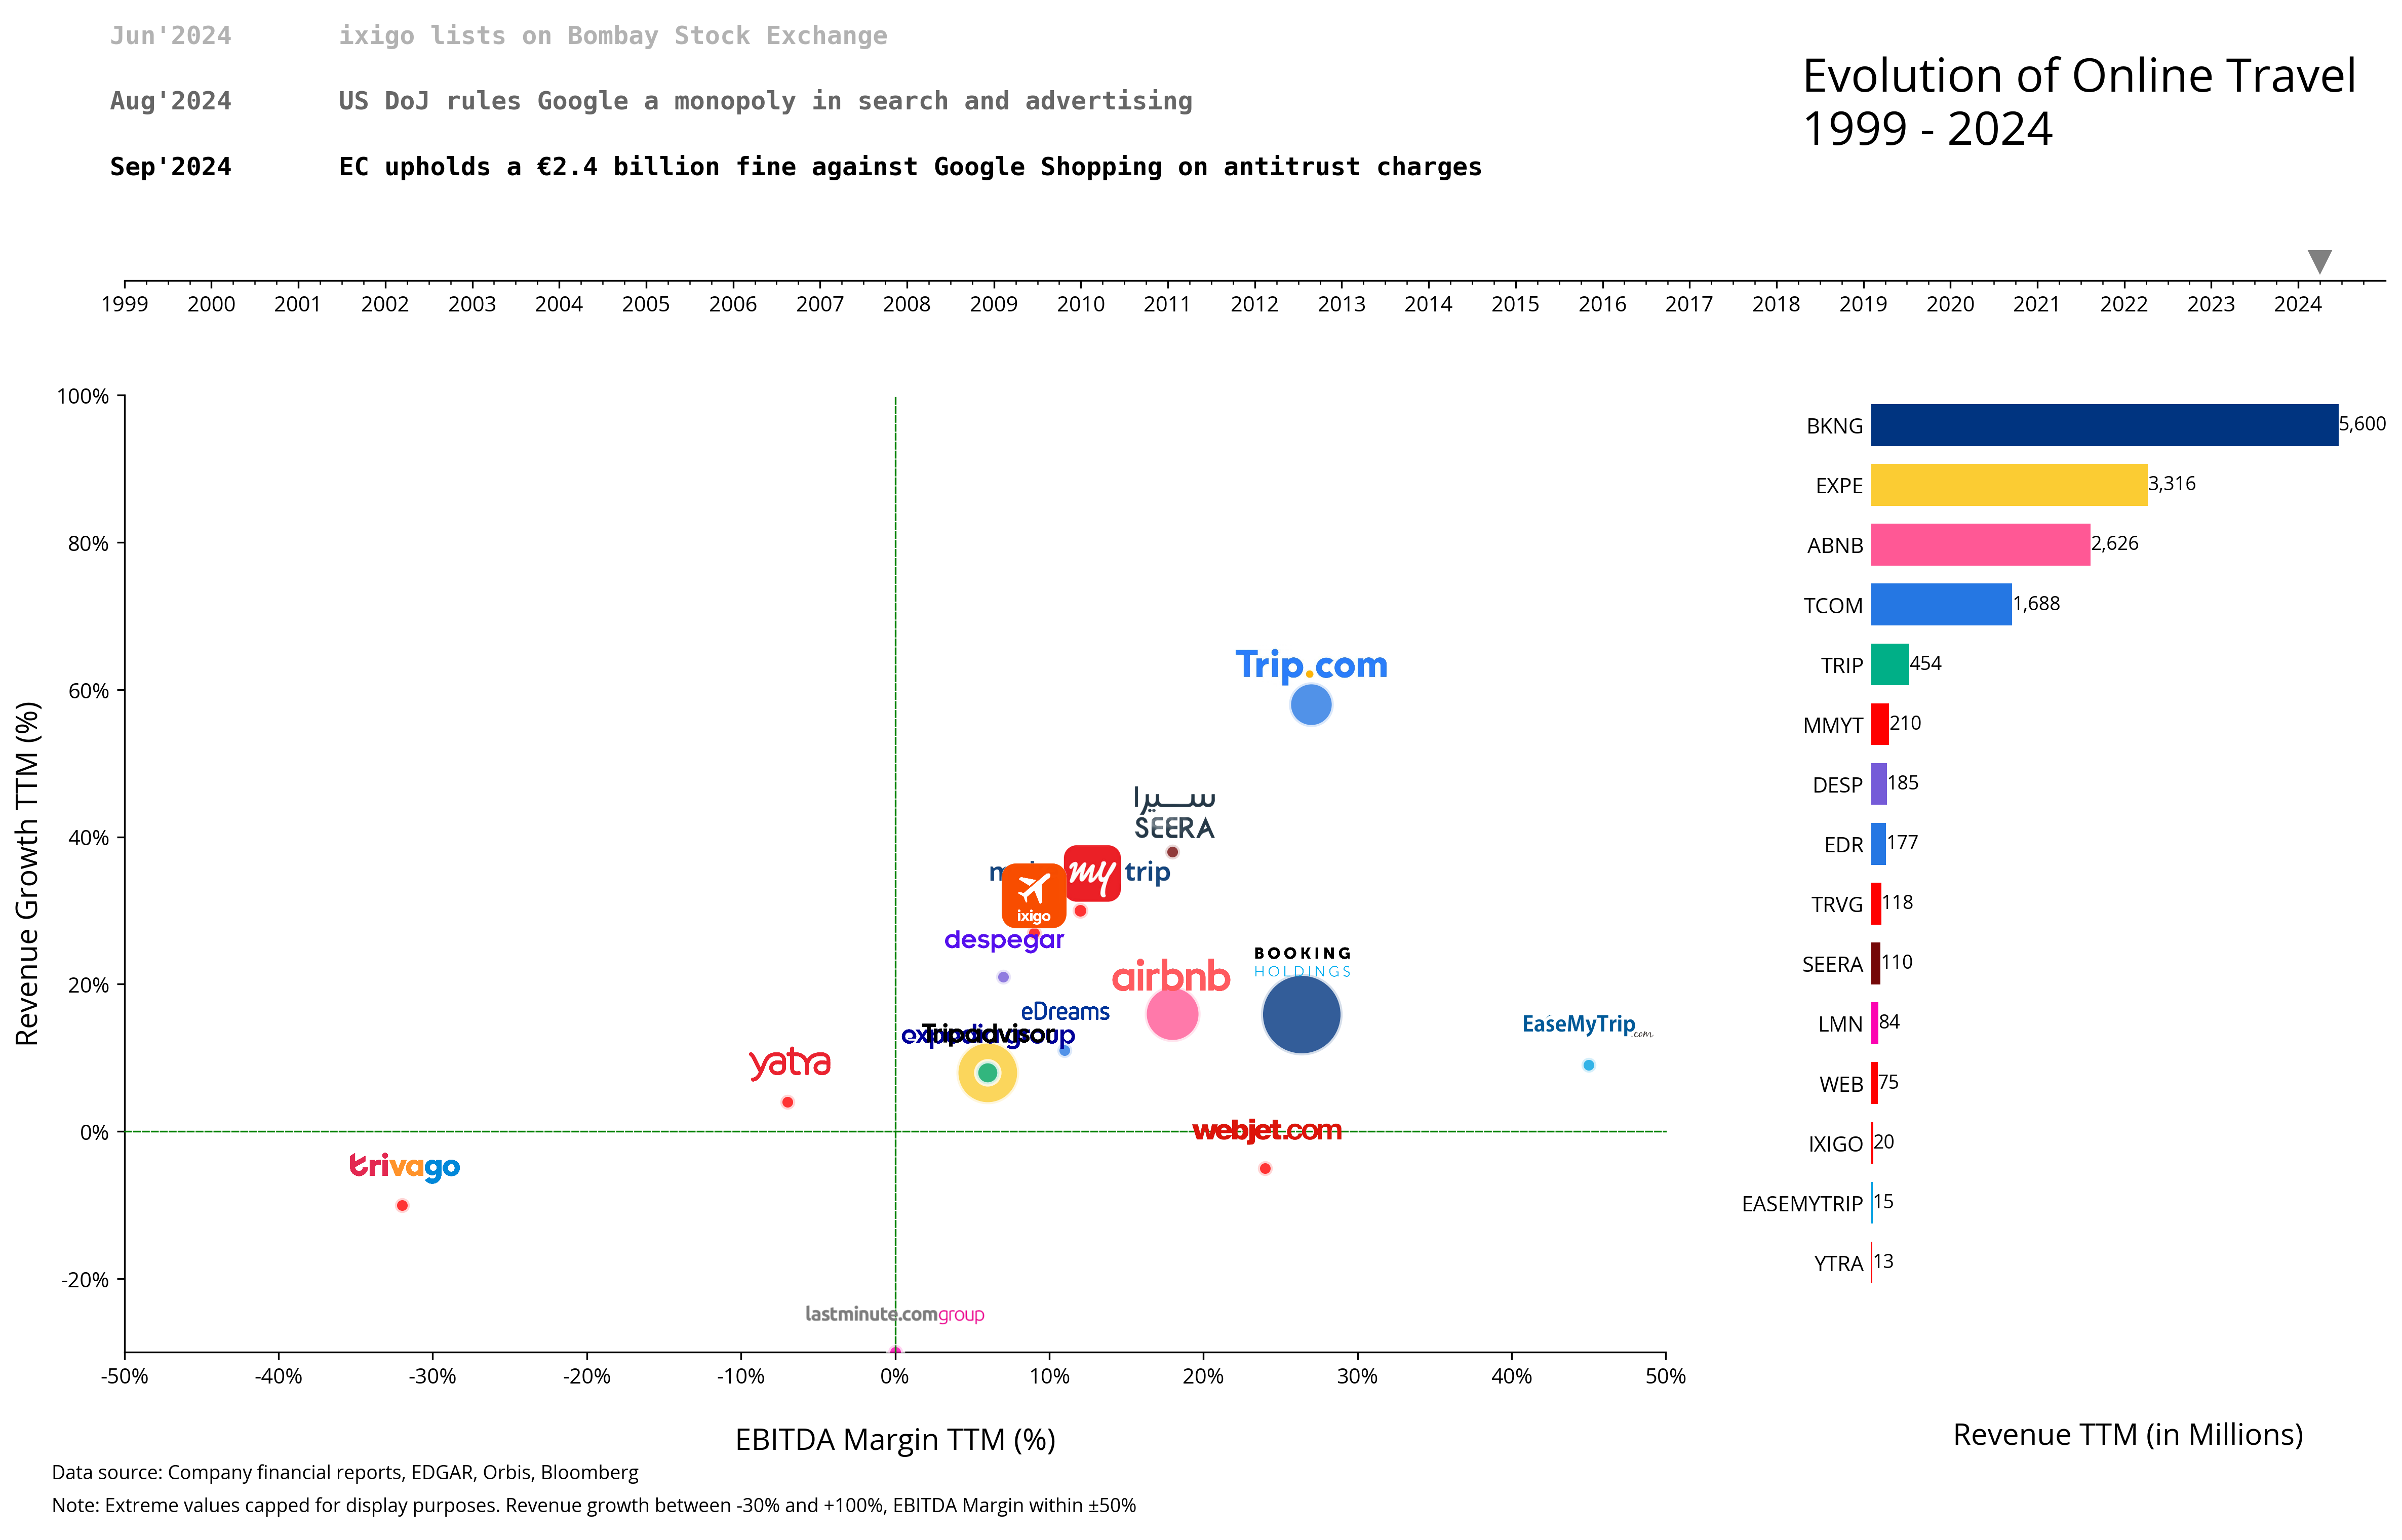

In [54]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.font_manager import FontProperties


plt.rcParams['font.family'] = 'sans-serif'


deja_vu_font = FontProperties(family='DejaVu Sans Mono')
open_sans_font = FontProperties(fname='/Users/maxxtucker/Library/Fonts/OpenSans-VariableFont_wdth,wght.ttf')  # Change to the path where Open Sans is installed

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EASEMYTRIP': '#00a0e2',
    'IXIGO': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'YTRA': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'WEB': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480',
    'OWW': '#8edbfa',
    'Travelocity': '#1d3e5c',
    ' OWW': '#8edbfa',
    ' LMN': '#fc03b1',
    ' PCLN': '#003480',
    ' TCOM': '#2577e3',
    ' SEERA': '#750808',
    '  LMN': '#3a6bba',
    ' TRIP': '#63d455',

}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com lists on NASDAQ", None),
    (1999.92, "Nov'1999 Expedia lists on NASDAQ", None),
    (2000.25, "Mar'2000 Lastminute.com lists on LSE", None),
    (2000.25, "Mar'2000 Sabre merges Travelocity with Preview Travel, owns 70%", None),
    (2000.25, "Mar'2000 Dot-com bubble. NASDAQ peaks before falling 78% by Oct'2002", None),
    (2000.42, "May'2000 Webjet lists on ASX", None),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online forming Booking.com", None),
    (2001.50, "Jun'2001 Expedia acquires Hotels.com", None),
    (2001.75, "Sep'2001 9/11 Terrorist attack. 20% cutback in air capacity in North America", None),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip lists on NASDAQ", None),
    (2003.92, "Dec'2003 Orbitz lists on NYSE", None),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels for $160mil", None),
    (2005.42, "May'2005 Sabre-owned Travelocity takes lastminute.com private", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com for $133mil merging it with Active Hotels", None),
    (2006.67, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.25, "Mar'2007 Sabre Holdings taken private by TPG & Silver Lake Partners", None),
    (2007.58, "Jul'2007 Orbitz lists on NYSE for the second time", None),
    (2008.08, "Jan'2008 The US housing bubble leads to the Great Recession (2008-2009)", None),
    (2010.58, "Jul'2010 ITA Software accepts $700mil acquisition bid by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip lists on NASDAQ", None),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.50, "Jun'2011 eDreams, GO Voyages and Opodo merge forming eDreams ODIGEO", None),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor, listing it on NASDAQ", None),
    (2012.33, "Apr'2012 Al Tayyar Travel lists on Saudi Stock Exchange", None),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", None),
    (2012.92, "Dec'2012 Expedia Group acquires 62% of Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak for $1.8bn", None),
    (2014.25, "Apr'2014 eDreams ODIGEO lists on Madrid Stock Exchange", None),
    (2014.25, "Apr'2014 Bravofly Rumbo lists on SIX Swiss Exchange", None),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.08, "Feb'2015 Expedia Group acquires Orbitz for \$1.6bn & Travelocity for \$280mil", None),
    (2015.17, "Mar'2015 New CEO restructures Edreams ODIGEO. Subscriptions launch in 2017", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.83, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Nov'2015 Expedia Group acquires HomeAway and VRBO for $3.9bn", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.83, "Oct'2016 Yatra lists on NASDAQ", None),
    (2016.92, "Dec'2016 Trivago lists on NASDAQ. Expedia maintains majority ownership", None),
    (2017.50, "Jun'2017 CVC Capital Partners acquires Etraveli for €508mil", None),
    (2017.50, "Jun'2017 Booking.com pulls out of Trivago. Trivago shares lose 80% in the next 12 months", None),
    (2017.58, "Jul'2017 Expedia leads a 350mil Series C Traveloka fundraise", None),
    (2017.75, "Sep'2017 Despegar lists on NASDAQ", None),
    (2018.08, "Feb'2018 The Priceline Group rebrands to Booking Holdings", None),
    (2018.83, "Nov'2018 Webjet acquires Destinations of the World boosting its bedbank business", None),
    (2019.25, "Mar'2019 Airbnb acquires HotelTonight for $400m", None),
    (2019.33, "Apr'2019 Al Tayyar Travel rebrands as SEERA Group", None),
    (2019.42, "May'2019 Google consolidates Flights, Hotel Finder & Trips products under one interface", None),
    (2019.67, "Aug'2019 Google sunsets Trips app", None),
    (2019.75, "Sep'2019 Ctrip rebrands as Trip.com Group", None),
    (2020.08, "Feb'2020 Start of COVID-19 pandemic. Severe travel restrictions worldwide", None),
    (2020.92, "Dec'2020 Airbnb lists on NASDAQ", None),
    (2021.25, "Mar'2021 EaseMyTrip lists on Bombay Stock Exchange", None),
    (2021.92, "Nov'2021 Etraveli Group accepts Booking Holdings' takeover bid for €1.6bn", None),
    (2023.75, "Sep'2023 EC blocks Booking Holdings-Etraveli merger", None),
    (2024.00, "Jun'2024 ixigo lists on Bombay Stock Exchange", None),
    (2024.10, "Aug'2024 US DoJ rules Google a monopoly in search and advertising", None),
    (2024.20, "Sep'2024 EC upholds a €2.4 billion fine against Google Shopping on antitrust charges", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    return zoom_factor

def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.12, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    
    # Ensure events are available and sorted by date
    if len(events) == 0:
        return
    
    # Determine the most recent events
    most_recent_event = events[-1]
    second_most_recent_event = events[-2] if len(events) > 1 else None
    third_most_recent_event = events[-3] if len(events) > 2 else None
    
    for i, event in enumerate(events):
        # Safely unpack event: only assign flag_path if the tuple has 3 elements
        if len(event) == 3:
            event_text, flag_path = event[1], event[2]
        elif len(event) == 2:
            event_text, flag_path = event[1], None  # No flag image for this event
        else:
            continue  # Skip if the tuple doesn't have enough elements

        # Format the date and event description for alignment (15 characters for date)
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y

        # Determine the style based on the event's recency
        if event == most_recent_event:
            # Most recent event: fully bold and black
            fontweight = 'bold'
            text_alpha = 1.0
            color = "black"
        elif event == second_most_recent_event:
            # Second most recent event: slightly bold and slightly faded
            fontweight = 'semibold'
            text_alpha = 0.6
            color = "black"
        elif event == third_most_recent_event:
            # Third most recent event: normal weight and more faded
            fontweight = 'semibold'
            text_alpha = 0.3
            color = "black"
        else:
            # Older events: light gray and highly faded
            fontweight = 'normal'
            text_alpha = 0.3
            color = "lightgray"

        # Add the event description text with DejaVu Sans Mono font
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, 
                 color=color, alpha=text_alpha, fontweight=fontweight, fig=fig, fontproperties=deja_vu_font)

        # Add the flag image if it exists, with adjusted transparency
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05, alpha=text_alpha)  # Adjust alpha for fading
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)





def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()

    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)

    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    # Set the x-ticks (years) on the timeline to use Open Sans font
# Set the font and size for x-axis tick labels using tick_params
    ax_timeline.tick_params(axis='x', which='major', labelsize=10)
    for label in ax_timeline.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    ax_timeline.tick_params(axis='x', which='both', labelsize=10)

    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

   

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 50 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)

        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    # Set the font and size for x-axis and y-axis tick labels using tick_params
    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)

    for label in ax.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(open_sans_font)

    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)
    

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    # Set the tick labels on the secondary x-axis and y-axis to use Open Sans font
    # Secondary axes (ax2_x and ax2_y)
    for label in ax2_x.get_xticklabels():
        label.set_fontproperties(open_sans_font)
    for label in ax2_y.get_yticklabels():
        label.set_fontproperties(open_sans_font)




    # Set axis labels using Open Sans font
    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140, fontproperties=open_sans_font, fontsize = 14)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410, fontproperties=open_sans_font, fontsize = 14)


    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.03, "Data source: Company financial reports, EDGAR, Orbis, Bloomberg", ha='left', va='bottom', fontsize=9, color='black', 
        fig=fig, fontproperties=open_sans_font)

    fig_text(0.1, 0.01, "Note: Extreme values capped for display purposes. Revenue growth between -30% and +100%, EBITDA Margin within ±50%", 
            ha='left', va='bottom', fontsize=9, color='black', fig=fig, fontproperties=open_sans_font)


    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)

    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Limit the number of bars to display
    max_bars = 16

    # Set a constant height for the bars
    bar_height = 0.7

    # Filter data for companies with revenue > 0
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()

    # Sort the data by revenue in descending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)

    # Get the number of companies to display
    num_companies = min(len(sorted_data), max_bars)

    # Get the data for the top companies
    top_companies = sorted_data.head(num_companies)

    # Reverse the y_positions so that the highest revenue is at the top
    y_positions = np.arange(num_companies)

    # Invert y_positions to start bars from the top
    y_positions = y_positions[::-1]

    # Map company names to colors
    bar_colors = top_companies['Company'].map(color_dict)

    # Create horizontal bar chart
    bars = ax_barchart.barh(
        y_positions,
        top_companies['Revenue'],
        color=bar_colors,
        height=bar_height
    )

    # Set y-axis limits
    ax_barchart.set_ylim(-0.5, max_bars - 0.5)

    # Add company names as y-tick labels
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'], fontproperties=open_sans_font)

    # Invert y-axis to have highest revenue at the top
    ax_barchart.invert_yaxis()

    # Add revenue labels to the bars
    # for bar, revenue in zip(bars, top_companies['Revenue']):
    #     width = bar.get_width()
    #     if width > 0:
    #         ax_barchart.text(
    #             width,
    #             bar.get_y() + bar.get_height() / 2,
    #             f'{int(width)}',
    #             va='center',
    #             ha='left',
    #             fontsize=9,
    #             fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
    #         )
    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',  # Format with commas for thousands and no decimals
                va='center',
                ha='left',
                fontsize=9,
                fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
            )

    # Adjust aesthetics
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=14, fontproperties=open_sans_font, labelpad=33)

    return dots_and_logos + [ax_timeline, ax_barchart]


# Add a two-line title, aligned to the right
fig.suptitle("Evolution of Online Travel\n1999 - 2024",
             fontsize=22, fontproperties=open_sans_font, x=0.70, y=0.90, ha='left')  # 'x' and 'ha' control horizontal alignment



# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()




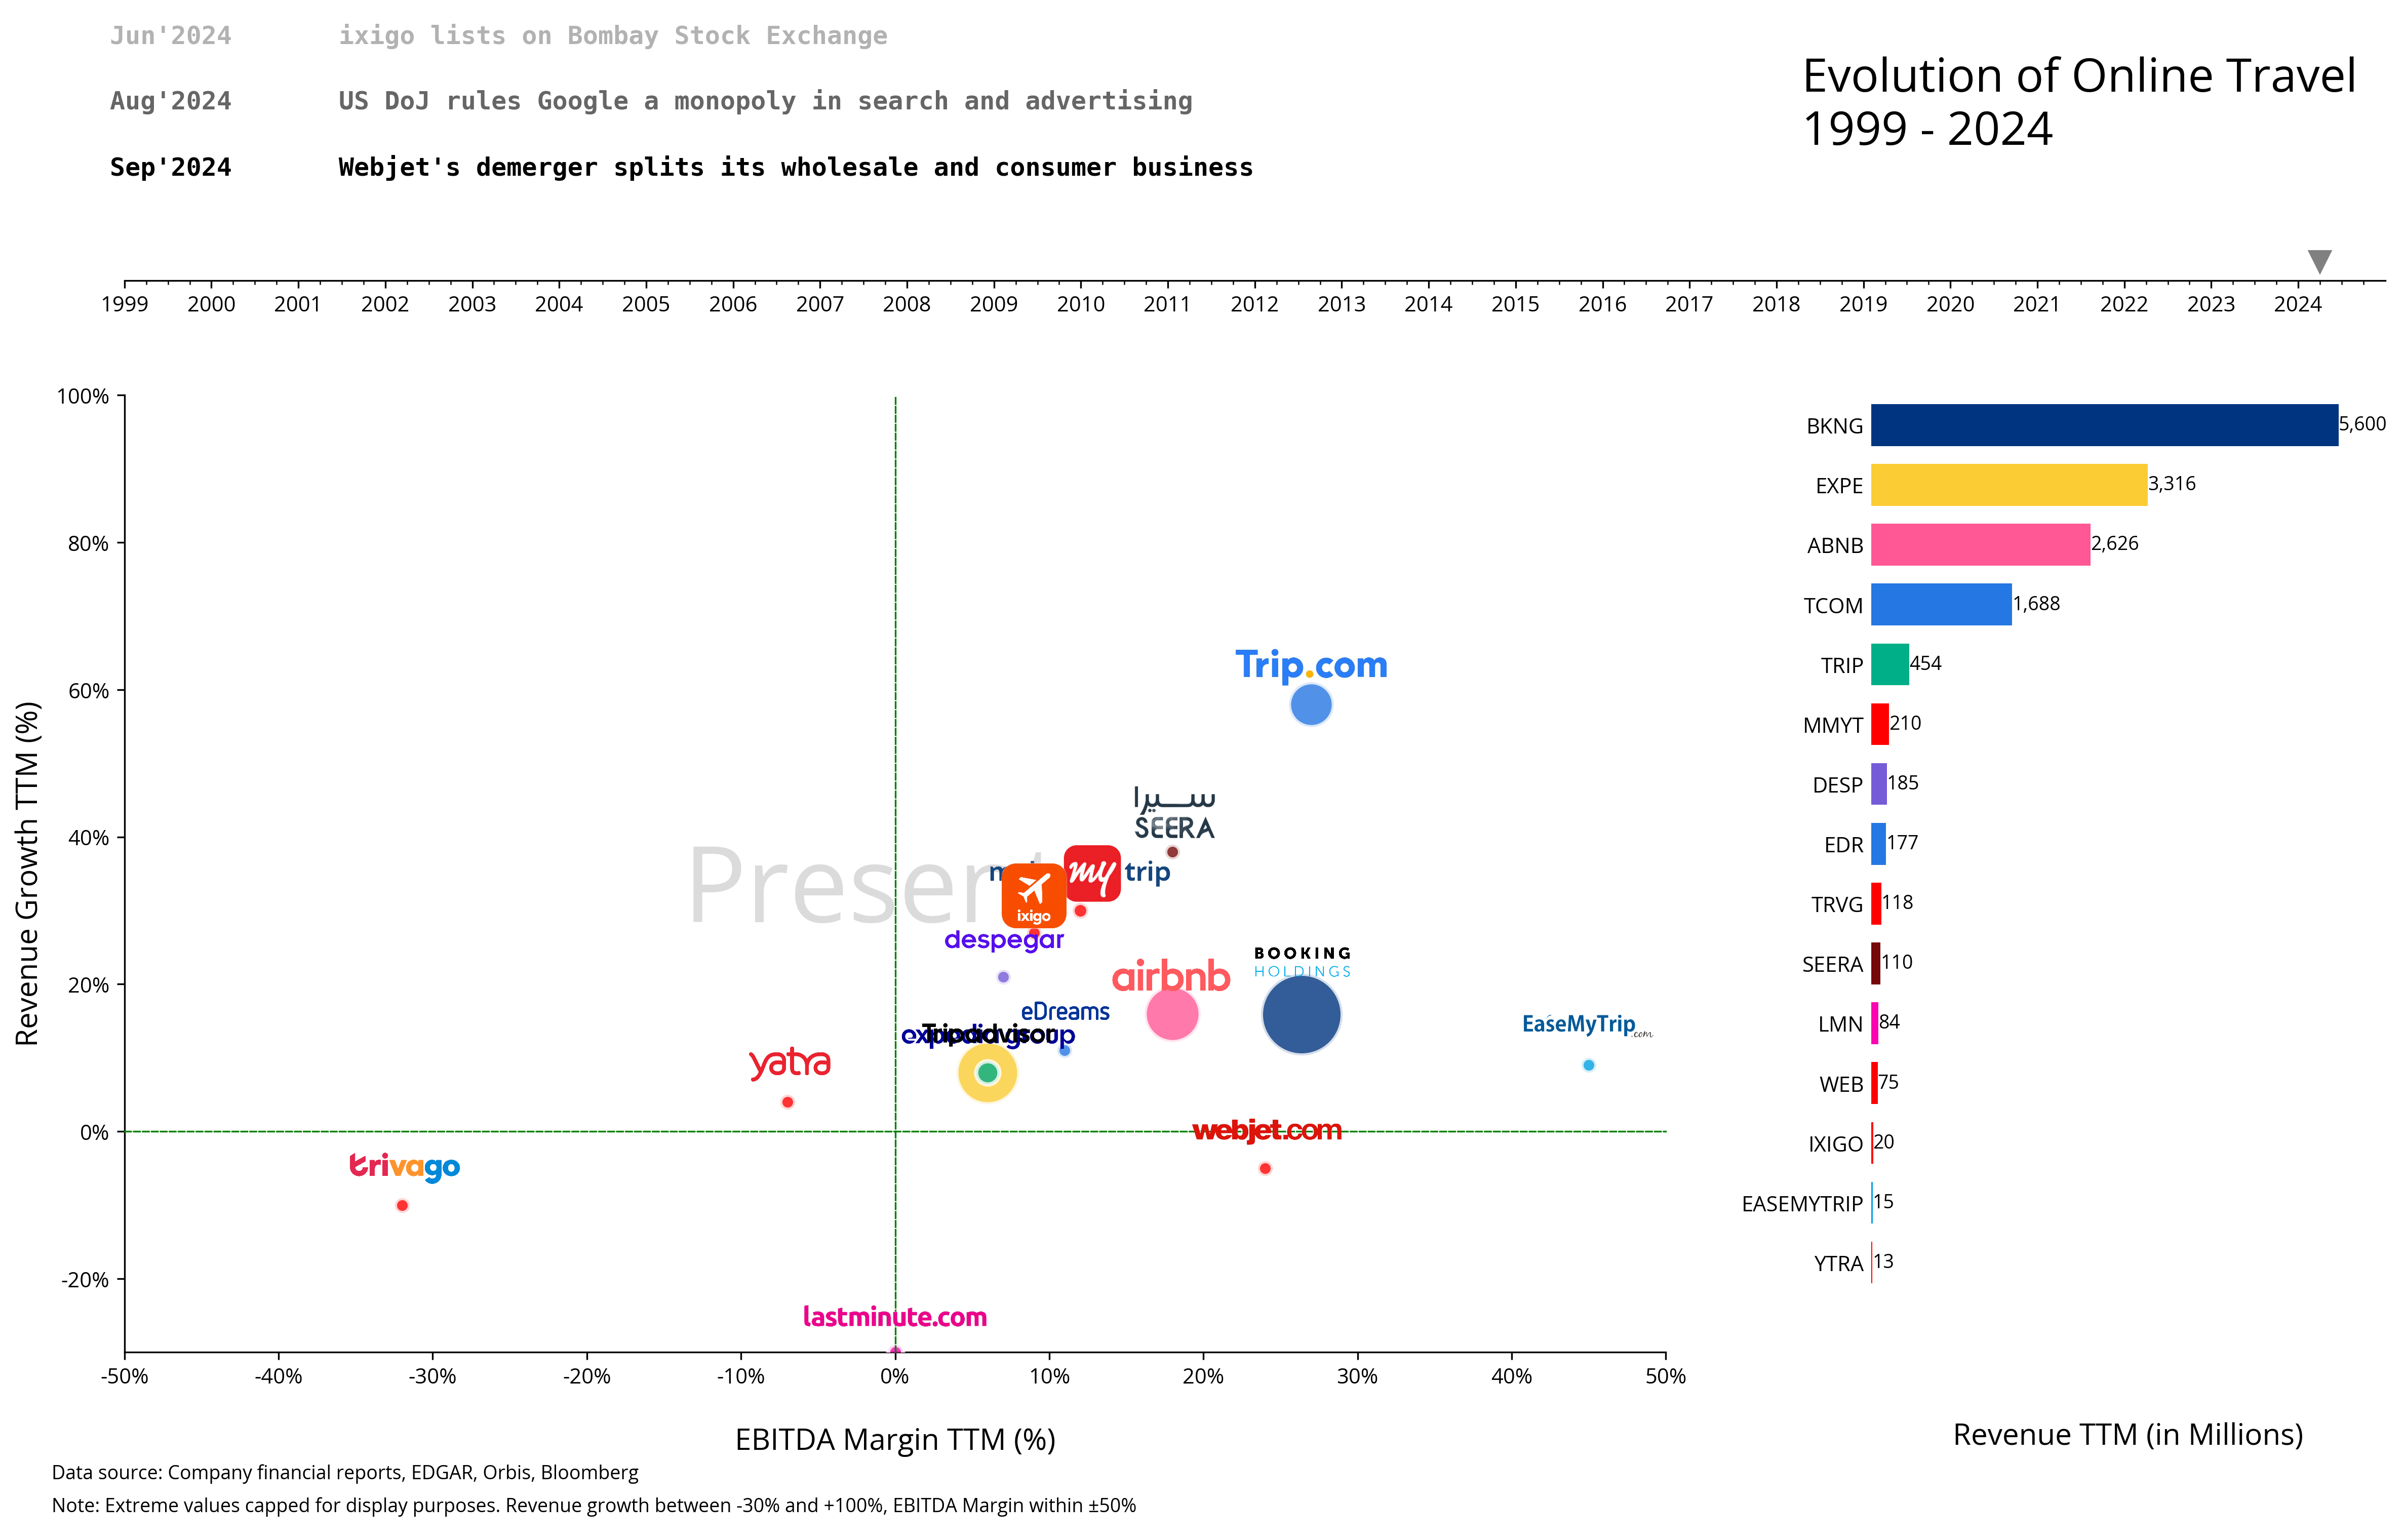

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from highlight_text import fig_text
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.font_manager import FontProperties


plt.rcParams['font.family'] = 'sans-serif'


deja_vu_font = FontProperties(family='DejaVu Sans Mono')
open_sans_font = FontProperties(fname='/Users/maxxtucker/Library/Fonts/OpenSans-VariableFont_wdth,wght.ttf')  # Change to the path where Open Sans is installed

# Replace Inf values with NaN and drop rows with NaN
interp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
interp_data.dropna(subset=['EBITDA Margin (%)', 'Revenue Growth (%)'], inplace=True)

# Setup the figure and gridspec for the layout
fig = plt.figure(figsize=(19.2, 10.8), dpi=300)
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 5])

# Timeline spanning both columns (top row)
ax_timeline = fig.add_subplot(gs[0, :])

# Bubble chart (bottom-left)
ax = fig.add_subplot(gs[1, 0])

# Bar chart (bottom-right)
ax_barchart = fig.add_subplot(gs[1, 1])

# Manually create the dictionary for colors based on the provided data
color_dict = {
    'ABNB': '#ff5895',
    'Almosafer': '#bb5387',
    'BKNG': '#003480',
    'DESP': '#755bd8',
    'EXPE': '#fbcc33',
    'EASEMYTRIP': '#00a0e2',
    'IXIGO': 'red',
    'MMYT': 'red',
    'TRIP': '#00af87',
    'TRVG': 'red',
    'Wego': '#4e843d',
    'YTRA': 'red',
    'TCOM': '#2577e3',
    'EDR': '#2577e3',
    'LMN': '#fc03b1',
    'WEB': 'red',
    'SEERA': '#750808',
    'PCLN': '#003480',
    'OWW': '#8edbfa',
    'Travelocity': '#1d3e5c',
    ' OWW': '#8edbfa',
    ' LMN': '#fc03b1',
    ' PCLN': '#003480',
    ' TCOM': '#2577e3',
    ' SEERA': '#750808',
    '  LMN': '#3a6bba',
    ' TRIP': '#63d455',

}

# Assuming interp_data is already defined and contains the necessary data
unique_companies = interp_data['Company'].unique()
logos = {company: plt.imread(f'/Users/maxxtucker/Desktop/animated bubble chart/logos/{company}_logo.png') for company in unique_companies}

# Define desired width in inches for the logos
desired_width_in_inches = 0.005

# Set a fixed maximum for the bar chart to ensure absolute sizes
max_revenue_value = interp_data['Revenue'].max()

# Predefine all companies to ensure bar width is constant
all_companies = sorted(interp_data['Company'].unique())

# Create a list of events with timestamps (Numeric_Year), descriptions, and the flag image paths
events = [
    (1999.25, "Mar'1999 Priceline.com lists on NASDAQ", None),
    (1999.92, "Nov'1999 Expedia lists on NASDAQ", None),
    (2000.25, "Mar'2000 Lastminute.com lists on LSE", None),
    (2000.25, "Mar'2000 Sabre Holdings merges Travelocity with Preview Travel, owns 70%", None),
    (2000.25, "Mar'2000 Dot-com bubble. NASDAQ peaks in Mar'2000 before falling 78% by Oct'2002", None),
    (2000.42, "May'2000 Webjet lists on ASX", None),
    (2000.50, "Jun'2000 Bookings.nl merges with Bookings Online, forming Booking.com", None),
    (2001.50, "Jun'2001 Expedia acquires Hotels.com", None),
    (2001.75, "Sep'2001 9/11 Terrorist attack. 20% cutback in air capacity in North America", None),
    (2002.25, "Mar'2002 Sabre reacquires Travelocity's outstanding shares", None),
    (2003.92, "Dec'2003 Ctrip lists on NASDAQ", None),
    (2003.92, "Dec'2003 Orbitz lists on NYSE", None),
    (2004.75, "Sep'2004 Orbitz taken private by Cendant Corp", None),
    (2004.75, "Sep'2004 Priceline.com acquires Active Hotels for $160mil", None),
    (2005.42, "May'2005 Sabre Holdings-owned Travelocity takes lastminute.com private for $1.1bn", None),
    (2005.58, "Jul'2005 Priceline.com acquires Booking.com for $133mil, merging it with Active Hotels", None),
    (2006.67, "Aug'2006 Cendant Corp sells Orbitz to Blackstone Group as part of Travelport deal", None),
    (2007.25, "Mar'2007 Sabre Holdings taken private by TPG & Silver Lake Partners", None),
    (2007.58, "Jul'2007 Orbitz lists on NYSE for the second time", None),
    (2008.08, "Jan'2008 The US housing bubble leads to the Great Recession (2008-2009)", None),
    (2010.58, "Jul'2010 ITA Software accepts $700mil acquisition bid by Google", None),
    (2010.67, "Aug'2010 MakeMyTrip lists on NASDAQ", None),
    (2011.25, "Apr'2011 US DoJ approves Google's acquisition of ITA Software, Google enters travel", None),
    (2011.50, "Jun'2011 eDreams, GO Voyages and Opodo merge, forming eDreams ODIGEO", None),
    (2011.92, "Dec'2011 Expedia spins off Tripadvisor, listing it on NASDAQ", None),
    (2012.33, "Apr'2012 Al Tayyar Travel lists on Saudi Stock Exchange", None),
    (2012.75, "Sep'2012 Traveloka starts as a metasearch, quickly pivots to an OTA model", None),
    (2012.92, "Dec'2012 Expedia Group acquires 62% of Trivago", None),
    (2013.42, "May'2013 Priceline.com acquires Kayak for $1.8bn", None),
    (2014.25, "Apr'2014 eDreams ODIGEO lists on Madrid Stock Exchange", None),
    (2014.25, "Apr'2014 Bravofly Rumbo lists on SIX Swiss Exchange", None),
    (2014.25, "Apr'2014 Priceline.com rebrands as The Priceline Group", None),
    (2014.92, "Dec'2014 Travelocity sells lastminute.com to Bravofly Rumbo", None),
    (2014.67, "Aug'2014 ixigo expands to trains", None),
    (2015.08, "Feb'2015 Expedia Group acquires Orbitz for \$1.6bn & Travelocity for \$280mil", None),
    (2015.17, "Mar'2015 New CEO restructures Edreams ODIGEO. Subscriptions launch in 2017", None),
    (2015.42, "May'2015 Bravofly Rumbo rebrands as Lastminute Group", None),
    (2015.83, "Oct'2015 ProSiebenSat.1 acquires Etraveli for €235mil", None),
    (2015.92, "Nov'2015 Expedia Group acquires HomeAway and VRBO for $3.9bn", None),
    (2016.42, "May'2016 Skypicker rebrands to Kiwi.com", None),
    (2016.75, "Sep'2016 Google launches Google Trips", None),
    (2016.83, "Oct'2016 Yatra lists on NASDAQ", None),
    (2016.92, "Nov'2016 Ctrip acquires Skyscanner for £1.4bn", None),
    (2016.92, "Dec'2016 Trivago lists on NASDAQ. Expedia maintains majority ownership", None),
    (2017.50, "Jun'2017 CVC Capital Partners acquires Etraveli for €508mil", None),
    (2017.50, "Jun'2017 Booking.com pulls out of Trivago. Trivago shares lose 80% in the next 12 months", None),
    (2017.58, "Jul'2017 Expedia leads 350mil Series C funding for Traveloka", None),
    (2017.75, "Sep'2017 Despegar lists on NASDAQ", None),
    (2018.08, "Feb'2018 The Priceline Group rebrands to Booking Holdings", None),
    (2018.83, "Nov'2018 Webjet acquires Destinations of the World, boosting its bedbank business", None),
    (2019.25, "Mar'2019 Airbnb acquires HotelTonight for $400m", None),
    (2019.33, "Apr'2019 Al Tayyar Travel rebrands as SEERA Group", None),
    (2019.42, "May'2019 Google consolidates Flights, Hotel Finder & Trips products under one interface", None),
    (2019.67, "Aug'2019 Google sunsets Trips app", None),
    (2019.75, "Sep'2019 Ctrip rebrands as Trip.com Group", None),
    (2020.08, "Feb'2020 Start of COVID-19 pandemic. Severe travel restrictions worldwide", None),
    (2020.92, "Dec'2020 Airbnb lists on NASDAQ", None),
    (2021.25, "Mar'2021 EaseMyTrip lists on Bombay Stock Exchange", None),
    (2021.92, "Nov'2021 Etraveli Group accepts Booking Holdings' €1.6bn takeover bid", None),
    (2023.75, "Sep'2023 EC blocks Booking Holdings-Etraveli merger", None),
    (2024.00, "May'2024 EC designates Booking Holdings, Google Shopping a 'gatekeeper' status", None),
    (2024.05, "Jun'2024 ixigo lists on Bombay Stock Exchange", None),
    (2024.10, "Aug'2024 US DoJ rules Google a monopoly in search and advertising", None),
    (2024.21, "Sep'2024 Webjet's demerger splits its wholesale and consumer business", None)
]


def get_recent_events(frame, events, max_events=3):
    """ Return the most recent max_events up to the current frame. """
    # Filter events that occurred up to the current frame
    recent_events = [event for event in events if event[0] <= frame]
    # Return only the last max_events (most recent ones)
    return recent_events[-max_events:]

def get_zoom_factor(image, desired_width, ax):
    """ Calculate the appropriate zoom factor to maintain a consistent logo size. """
    # Get the width of the current data limits on the x-axis
    data_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Get the figure width in inches
    fig_width = fig.get_size_inches()[0]
    
    # Scale is the ratio of data width to figure width in inches
    scale = data_width / (fig_width * fig.dpi)
    
    # Native width of the image in pixels
    native_width_in_pixels = image.shape[1]
    
    # Calculate the zoom factor for the image to match the desired width in inches
    zoom_factor = (desired_width * fig.dpi) / (native_width_in_pixels * scale)
    
    
    return zoom_factor

def get_time_period(frame):
    """ Return the appropriate time period label based on the frame (year). """
    if 1997 <= frame <= 2002.99:
        return "Dot-com bubble"
    elif 2003 <= frame <= 2007.99:
        return "Dot-com recovery"
    elif 2008 <= frame <= 2009.99:
        return "Great Recession"
    elif 2010 <= frame <= 2019.99:
        return "Rise of smartphones"
    elif 2020 <= frame <= 2020.99:
        return "COVID-19 pandemic"
    elif 2021 <= frame <= 2023.99:
        return "Post-pandemic rebound"
    elif frame >= 2024:
        return "Present"
    return ""

def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()

    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()

    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)

    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    ax_timeline.tick_params(axis='x', which='major', labelsize=10)
    for label in ax_timeline.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    ax_timeline.tick_params(axis='x', which='both', labelsize=10)

    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 50 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)

        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)

    for label in ax.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(open_sans_font)

    # Dynamic background text for economic/technological periods
    time_period_label = get_time_period(frame)
    
    fig_text(0.5, 0.5, time_period_label, fontsize=50, color="lightgrey", alpha=0.2, ha='center', fig=fig, fontproperties=open_sans_font)

    # Continue with the rest of the update logic
    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)

    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Handle the bar chart part as usual
    max_bars = 16
    bar_height = 0.7
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)
    num_companies = min(len(sorted_data), max_bars)
    top_companies = sorted_data.head(num_companies)
    y_positions = np.arange(num_companies)[::-1]
    bar_colors = top_companies['Company'].map(color_dict)

    bars = ax_barchart.barh(y_positions, top_companies['Revenue'], color=bar_colors, height=bar_height)

    ax_barchart.set_ylim(-0.5, max_bars - 0.5)
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'], fontproperties=open_sans_font)
    ax_barchart.invert_yaxis()

    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(width, bar.get_y() + bar.get_height() / 2, f'{width:,.0f}', va='center', ha='left', fontsize=9, fontproperties=open_sans_font)

    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=14, fontproperties=open_sans_font, labelpad=33)

    return dots_and_logos + [ax_timeline, ax_barchart]


def add_flag_images(fig, ax, events, fig_position_y=0.92, fig_position_x=0.12, fontsize=12):
    """ Add flag images next to the event text at the top of the figure. """
    
    # Ensure events are available and sorted by date
    if len(events) == 0:
        return
    
    # Determine the most recent events
    most_recent_event = events[-1]
    second_most_recent_event = events[-2] if len(events) > 1 else None
    third_most_recent_event = events[-3] if len(events) > 2 else None
    
    for i, event in enumerate(events):
        # Safely unpack event: only assign flag_path if the tuple has 3 elements
        if len(event) == 3:
            event_text, flag_path = event[1], event[2]
        elif len(event) == 2:
            event_text, flag_path = event[1], None  # No flag image for this event
        else:
            continue  # Skip if the tuple doesn't have enough elements

        # Format the date and event description for alignment (15 characters for date)
        date_text = event_text.split(' ')[0]  # Assuming the date is the first part
        description_text = ' '.join(event_text.split(' ')[1:])  # The rest is the description
        formatted_text = f"{date_text:<15}{description_text}"  # Left-align the date with a width of 15 characters
        
        # Modify x_position and text_y_offset to adjust the location of the text
        x_position = fig_position_x  # Use fig_position_x to control the horizontal position
        text_y_offset = fig_position_y - i * 0.04  # Vertical position based on fig_position_y

        # Determine the style based on the event's recency
        if event == most_recent_event:
            # Most recent event: fully bold and black
            fontweight = 'bold'
            text_alpha = 1.0
            color = "black"
        elif event == second_most_recent_event:
            # Second most recent event: slightly bold and slightly faded
            fontweight = 'semibold'
            text_alpha = 0.6
            color = "black"
        elif event == third_most_recent_event:
            # Third most recent event: normal weight and more faded
            fontweight = 'semibold'
            text_alpha = 0.3
            color = "black"
        else:
            # Older events: light gray and highly faded
            fontweight = 'normal'
            text_alpha = 0.3
            color = "lightgray"

        # Add the event description text with DejaVu Sans Mono font
        fig_text(x_position, text_y_offset, formatted_text, ha='left', fontsize=fontsize, 
                 color=color, alpha=text_alpha, fontweight=fontweight, fig=fig, fontproperties=deja_vu_font)

        # Add the flag image if it exists, with adjusted transparency
        if flag_path:
            flag_img = plt.imread(flag_path)
            imagebox = OffsetImage(flag_img, zoom=0.05, alpha=text_alpha)  # Adjust alpha for fading
            ab = AnnotationBbox(imagebox, (x_position - 0.03, text_y_offset), frameon=False, xycoords='figure fraction')
            ax.add_artist(ab)





def update(frame):
    """ Update function for the animation. """
    ax.clear()  # Clear the current plot to redraw
    ax_timeline.clear()
    ax_barchart.clear()
    
    # Set symmetric axes limits around zero for the bubble chart
    ax.set_xlim(-50, 50)
    ax.set_ylim(-30, 100)

    # Filter data for the specific frame
    yearly_data = interp_data[interp_data['Numeric_Year'] == frame].copy()

    # Ensure the correct color mapping from color_dict
    yearly_data['color'] = yearly_data['Company'].map(color_dict)

    # Set up the timeline (spanning across both the bubble chart and bar chart)
    ax_timeline.set_xlim(1999, 2025)
    ax_timeline.set_ylim(-0.04, 1)
    ax_timeline.get_yaxis().set_visible(False)
    ax_timeline.spines['top'].set_visible(False)
    ax_timeline.spines['right'].set_visible(False)
    ax_timeline.spines['left'].set_visible(False)

    ax_timeline.xaxis.set_major_locator(MultipleLocator(1))
    ax_timeline.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax_timeline.set_xticks(np.arange(1999, 2025, 1))
    # Set the x-ticks (years) on the timeline to use Open Sans font
# Set the font and size for x-axis tick labels using tick_params
    ax_timeline.tick_params(axis='x', which='major', labelsize=10)
    for label in ax_timeline.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    ax_timeline.tick_params(axis='x', which='both', labelsize=10)

    ax_timeline.set_xticks(np.arange(1999, 2025, 0.25), minor=True)
    ax_timeline.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

   

    # Moving marker on timeline
    marker_position = frame  # frame should represent quarters, e.g., 1998.75 for Q4 of 1998
    ax_timeline.plot([marker_position], [0.06], marker='v', color='grey', markersize=10)

    # Scatter plot for the specific year (bubble chart)
    dots_and_logos = []
    for i, point in yearly_data.iterrows():
        # Scale the bubble size based on the revenue, and ensure a minimum size
        bubble_size = max((point['Revenue'] / max_revenue_value) * 1500, 50)  # 1500 is the scale, 50 is the minimum size

        # Plot the colored dot for each company using the color from the color_dict and size for revenue
        dot = ax.scatter(
            x=point['EBITDA Margin (%)'],
            y=point['Revenue Growth (%)'],
            color=point['color'],  # Color matching the bar chart from the color_dict
            s=bubble_size,  # Bubble size proportional to revenue
            alpha=0.8,  # Slight transparency for better visibility
            edgecolors="white", 
            linewidths=2
        )
        dots_and_logos.append(dot)
        
        # Replace text with logo images above the dots
        image_path = logos[point['Company']]
        zoom_factor = get_zoom_factor(image_path, desired_width_in_inches, ax)
        imagebox = OffsetImage(image_path, zoom=zoom_factor)

        # Offset image to be placed above the dot
        ab = AnnotationBbox(imagebox, (point['EBITDA Margin (%)'], point['Revenue Growth (%)'] + 5), frameon=False)
        ax.add_artist(ab)
        dots_and_logos.append(ab)

    # Adjust spines to put zero in the middle for the bubble chart
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('green')
    ax.spines['left'].set_linestyle('dashed')
    ax.spines['bottom'].set_color('green')
    ax.spines['bottom'].set_linestyle('dashed')

    # Custom formatting for axes in the bubble chart
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    # Set the font and size for x-axis and y-axis tick labels using tick_params
    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)

    for label in ax.get_xticklabels():
        label.set_fontproperties(open_sans_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(open_sans_font)

    ax.tick_params(axis='x', which='both', labelsize=10)
    ax.tick_params(axis='y', which='both', labelsize=10)

    time_period_label = get_time_period(frame)
    
    # Add background text directly to the axes, using zorder to place it behind the bubbles
    ax.text(
        0.485, 0.45, time_period_label, transform=ax.transAxes, fontsize=50, 
        color="lightgrey", alpha=0.8, ha='center', fontproperties=open_sans_font, zorder=0
    )


    

    # Static secondary axes for the bubble chart
    ax2_x = ax.secondary_xaxis('bottom')
    ax2_y = ax.secondary_yaxis('left')
    ax2_x.xaxis.set_major_locator(MultipleLocator(10))
    ax2_x.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
    ax2_y.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    # Set the tick labels on the secondary x-axis and y-axis to use Open Sans font
    # Secondary axes (ax2_x and ax2_y)
    for label in ax2_x.get_xticklabels():
        label.set_fontproperties(open_sans_font)
    for label in ax2_y.get_yticklabels():
        label.set_fontproperties(open_sans_font)




    # Set axis labels using Open Sans font
    ax.set_xlabel("EBITDA Margin TTM (%)", horizontalalignment='center', x=0.5, labelpad=140, fontproperties=open_sans_font, fontsize = 14)
    ax.set_ylabel("Revenue Growth TTM (%)", verticalalignment='center', y=0.5, labelpad=410, fontproperties=open_sans_font, fontsize = 14)


    # Hide ticks on the axes crossing at zero in the bubble chart
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    

    def get_quarter_year(time_value):
        year = int(time_value)
        quarter = int((time_value - year) * 4) + 1
        return f"Q{quarter}'{year}"

    # Background text for data source
    fig_text(0.1, 0.03, "Data source: Company financial reports, EDGAR, Orbis, Bloomberg", ha='left', va='bottom', fontsize=9, color='black', 
        fig=fig, fontproperties=open_sans_font)

    fig_text(0.1, 0.01, "Note: Extreme values capped for display purposes. Revenue growth between -30% and +100%, EBITDA Margin within ±50%", 
            ha='left', va='bottom', fontsize=9, color='black', fig=fig, fontproperties=open_sans_font)


    # Time display in the bubble chart
    quarter_year = get_quarter_year(frame)

    # Display the recent three events at the top of the chart
    recent_events = get_recent_events(frame, events)

    # Add the event text and flag images at the top of the figure
    add_flag_images(fig, ax, recent_events)

    # Limit the number of bars to display
    max_bars = 16

    # Set a constant height for the bars
    bar_height = 0.7

    # Filter data for companies with revenue > 0
    filtered_data = yearly_data[yearly_data['Revenue'] > 0].copy()

    # Sort the data by revenue in descending order
    sorted_data = filtered_data.sort_values(by='Revenue', ascending=True)

    # Get the number of companies to display
    num_companies = min(len(sorted_data), max_bars)

    # Get the data for the top companies
    top_companies = sorted_data.head(num_companies)

    # Reverse the y_positions so that the highest revenue is at the top
    y_positions = np.arange(num_companies)

    # Invert y_positions to start bars from the top
    y_positions = y_positions[::-1]

    # Map company names to colors
    bar_colors = top_companies['Company'].map(color_dict)

    # Create horizontal bar chart
    bars = ax_barchart.barh(
        y_positions,
        top_companies['Revenue'],
        color=bar_colors,
        height=bar_height
    )

    # Set y-axis limits
    ax_barchart.set_ylim(-0.5, max_bars - 0.5)

    # Add company names as y-tick labels
    ax_barchart.set_yticks(y_positions)
    ax_barchart.set_yticklabels(top_companies['Company'], fontproperties=open_sans_font)

    # Invert y-axis to have highest revenue at the top
    ax_barchart.invert_yaxis()

    # Add revenue labels to the bars
    # for bar, revenue in zip(bars, top_companies['Revenue']):
    #     width = bar.get_width()
    #     if width > 0:
    #         ax_barchart.text(
    #             width,
    #             bar.get_y() + bar.get_height() / 2,
    #             f'{int(width)}',
    #             va='center',
    #             ha='left',
    #             fontsize=9,
    #             fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
    #         )
    for bar, revenue in zip(bars, top_companies['Revenue']):
        width = bar.get_width()
        if width > 0:
            ax_barchart.text(
                width,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',  # Format with commas for thousands and no decimals
                va='center',
                ha='left',
                fontsize=9,
                fontproperties=open_sans_font  # Apply Open Sans font to revenue labels
            )

    # Adjust aesthetics
    ax_barchart.set_xlim(0, max_revenue_value * 1.1)
    ax_barchart.spines['top'].set_visible(False)
    ax_barchart.spines['right'].set_visible(False)
    ax_barchart.spines['left'].set_visible(False)
    ax_barchart.spines['bottom'].set_visible(False)
    ax_barchart.tick_params(axis='y', which='both', length=0)
    ax_barchart.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax_barchart.set_xlabel('Revenue TTM (in Millions)', fontsize=14, fontproperties=open_sans_font, labelpad=33)

    return dots_and_logos + [ax_timeline, ax_barchart]


# Add a two-line title, aligned to the right
fig.suptitle("Evolution of Online Travel\n1999 - 2024",
             fontsize=22, fontproperties=open_sans_font, x=0.70, y=0.90, ha='left')  # 'x' and 'ha' control horizontal alignment



# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=np.unique(interp_data['Numeric_Year']), repeat=False, blit=False)

# Save the animation as an MP4 file
ani.save('/Users/maxxtucker/Desktop/animated_bubble_chart.mp4', writer='ffmpeg', fps=30)

plt.show()


